Figure for PePrMInt data anlysis paper
======================================================================================
All code bellow are made to generate the figures for the Tubiana *et. al* 2022, XXXX


# Preparation

## Include Alphafold and backup ?
- set `includeAlfafold` to `True` to include Alphafold from the begining. [NOT RECOMENDED SINCE IT IS ADDED LATER]
- set `recalculate` to `True` to recalculate the IBS on ALL datasets. If `False` (default) it will use a backup dataset (just to save time)

In [1]:
includeAlfafold = False
recalculate = False
if includeAlfafold:
    filesufix="-AF"
else:
    filesufix=""

## Imports

In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import urllib
import glob
from urllib.error import HTTPError

import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
%matplotlib inline
sns.set_style("darkgrid")

import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output


# from tqdm.auto import tqdm
from tqdm.notebook import tnrange, tqdm

tqdm.pandas()  # activate tqdm progressbar for pandas apply

pd.options.mode.chained_assignment = (
    None  # default='warn', remove pandas warning when adding a new column
)
pd.set_option("display.max_columns", None)

from IPython.core.interactiveshell import InteractiveShell


InteractiveShell.ast_node_interactivity = "all"
#%config InlineBackend.figure_format ='svg' #better quality figure figure
np.seterr(divide='ignore', invalid='ignore')

import matplotlib.gridspec as gridspec


import MDAnalysis as mda
import nglview as nv

/Users/thibault/miniconda3/envs/peprmint/lib/python3.7/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
if recalculate:
    if includeAlfafold:
        %run tools/tag_IBS_domains-withAlphaFold.ipynb
    else:
        %run tools/tag_IBS_domains.ipynb
        
    MERGED = merge_dataset(PH=PH, 
                           C2=C2, 
                           START=STARTo1,
                           C1=C1,
                           C2DIS=C2DIS,
                           PX=PX,
                        #    ENTH=ENTH,
                           PLD=PLDopm,
                           ANNEXIN=ANNEXIN,
                           PLA=PLA,
                          )
    MERGED.domainDf.reset_index(drop=True, inplace=True) # Just in case....
    MERGED.save_dataset(f"MERGED_cath{filesufix}")
else:
    %run "./00-SETUP.ipynb"
    from pepr2ds.dataset.tagibs import Dataset
    if includeAlfafold:
        picklepath = f"{WORKDIR}/DATASET_peprmint_d25_AF.pkl"
    else:
        picklepath = f"{WORKDIR}/DATASET_peprmint_d25.pkl"
        
    DATASET = pd.read_pickle(picklepath)
    MERGED = Dataset(DATASET,PEPRMINT_FOLDER)
    MERGED.load_dataset(f"MERGED_cath{filesufix}")

/Users/thibault/miniconda3/envs/peprmint/lib/python3.7/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# Temporary fix: redefine type to have HIS as polar.
AATYPE = {
    "LEU": "Hydrophobic,H-non-aromatic",
    "ILE": "Hydrophobic,H-non-aromatic",
    "CYS": "Hydrophobic,H-non-aromatic",
    "MET": "Hydrophobic,H-non-aromatic",
    "TYR": "Hydrophobic,H-aromatic",
    "TRP": "Hydrophobic,H-aromatic",
    "PHE": "Hydrophobic,H-aromatic",
    "HIS": "Polar",
    "LYS": "Positive",
    "ARG": "Positive",
    "ASP": "Negative",
    "GLU": "Negative",
    "VAL": "Non-polar",
    "ALA": "Non-polar",
    "SER": "Polar",
    "ASN": "Polar",
    "GLY": "Non-polar",
    "PRO": "Non-polar",
    "GLN": "Polar",
    "THR": "Polar",
    "UNK": "none"
}
MERGED.domainDf["type"] = MERGED.domainDf.residue_name.apply(lambda x: AATYPE[x])

In [5]:
## REMOVE ENTH
MERGED.domainDf = MERGED.domainDf.query("domain != 'ENTH'")
#Rename C2DIS to C2DIS
MERGED.domainDf.domain.unique()

array(['PH', 'C2', 'START', 'C1', 'C2DIS', 'PX', 'PLD', 'ANNEXIN', 'PLA'],
      dtype=object)

## Some cleaning

In [6]:

#Clean the resname type
MERGED.domainDf.residue_name = MERGED.domainDf.residue_name.astype(str)
MERGED.domainDf.domain = MERGED.domainDf.domain.astype(str)
backup_all = MERGED.domainDf.copy()

# -----------------------------------------------------------------
def count_hydr_protr_perpdb(group):
    g = group.query("protrusion == True and atom_name == 'CB' and type.str.contains('Hydrophobic')", engine="python")
    return (len(g))
    
number_of_HP_per_pdbs = MERGED.domainDf.query('IBS == True and atom_name == "CB"').groupby("cathpdb").progress_apply(lambda group: count_hydr_protr_perpdb(group))
nohydrprotrpdbs = list(number_of_HP_per_pdbs[number_of_HP_per_pdbs==0].index)

backup_prot_HPIBS = MERGED.domainDf.query("cathpdb not in @nohydrprotrpdbs")
backup_prot_noHPIBS = MERGED.domainDf.query("cathpdb in @nohydrprotrpdbs")

In [7]:
domainList=['PH','C2','START','C1','C2DIS','PX',
# 'ENTH',
'PLD','ANNEXIN','PLA']

print("cath only", len(MERGED.domainDf.query("data_type == 'cathpdb' and domain in @domainList").cathpdb.unique()))
print("cath+AF", len(MERGED.domainDf.query("data_type != 'prosite' and domain in @domainList").cathpdb.unique()))
print("alphafold", len(MERGED.domainDf.query("data_type == 'alfafold' and domain in @domainList").cathpdb.unique()))

cath only 1328
cath+AF 1328
alphafold 0


## Palette and conf

In [17]:
dict_palette_IBS = {"IBS":"#A5CCE2",'nonIBS':"#DFA3AE"}
palette_IBS = [dict_palette_IBS["nonIBS"],dict_palette_IBS["IBS"]]
DPI=300
FORMAT="tif"
sns.set_style("whitegrid") #Seaborn style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.family"] = "Arial" 


def save_fig(figname,folder="article",format="png",dpi=300,bbox_inches='tight', transparent=False, ):
    from pathlib import Path
    Path(f"{FIGURESFOLDER}/{folder}").mkdir(parents=True, exist_ok=True)

    if format in ["tiff",'tif']:
        plt.savefig(f"{FIGURESFOLDER}/{folder}/{figname}.{format}", dpi=dpi, bbox_inches=bbox_inches, transparent=transparent, pil_kwargs={"compression": "tiff_lzw"})
    else:
        plt.savefig(f"{FIGURESFOLDER}/{folder}/{figname}.{format}", dpi=dpi, bbox_inches=bbox_inches, transparent=transparent)

def get_palette_OR(oddsratio):
    palette = []
    for index, row in oddsratio.iterrows():
        if row["pvalue"] < 0.05:
            if row.oddsratio > 0:
                palette.append(dict_palette_IBS["IBS"])
            else:
                palette.append(dict_palette_IBS["nonIBS"])
        else:
            palette.append("gray")
    return(palette)

def significance(ortable):
    def add_symbol(row):
        if row.pvalue > 0.05:
            return "ns"
        elif row.pvalue <= 0.0001:
            return '****'
        elif row.pvalue <= 0.001:
            return '***'
        elif row.pvalue <= 0.01:
            return '**'
        elif row.pvalue <= 0.05:
            return '*'
        else:
            return 'NA'
        
    ortable["significance"] = ortable.apply(lambda x: add_symbol(x), axis=1)
    ortable["labels"] ="("+ortable["significance"]+") " + ortable.iloc[:,0].astype(str)
    return ortable

def equality_test(pop1,pop2, ALTERNATIVE="two-sided", pairwised=False, silent=False, returnPval=False):
    """
    Perform equality test between two sample
    
    Args:
        - pop1 (array): sample1 (continuous or discrete data)
        - pop2 (array): sample2 (continuous or discrete data)
        - ALTERNATIVE (str): could be 'two-sided','less','greater'. Default is 'two-sided'
    Teturn:
        None
    """
        
    #for formating
    from IPython.display import Markdown, display
    def printmd(string, color=None):
        colorstr = "<span style='color:{}'>{}</span>".format(color, string)
        if not silent:
            display(Markdown(colorstr))
        
    printmd("**STATISTICAL TEST BETWEEN TWO SAMPLES**")
    
    printmd(f" - ALTERNATIVE HYPOTHESIS = {ALTERNATIVE}")
    from decimal import Decimal
    import scipy.stats as stats
    
    sign = {"two-sided":"≠",
       "less":"<",
       "greater":">"}
    

    printmd("**NORMALITY TEST (shapiro)**")
    normality = True
    printmd("*The two samples should follow a normal law to use a standard t.test*")

    normpop1 = stats.shapiro(pop1).pvalue
    normpop2 = stats.shapiro(pop2).pvalue
    if normpop1 < 0.05:
        printmd(f"---- Sample 1 shapioro test pvalue = {normpop1:.2E}, <= 0.05. This sample DO NOT follow a normal law", color='red')
        normality = False
    else: 
        printmd(f"---- Sample 1 shapioro test pvalue = {normpop1:.2E}, > 0.05. This sample follow a normal law", color='blue')
    if normpop2 < 0.05:
        printmd(f"---- Sample 1 shapioro test pvalue = {normpop2:.2E}, <= 0.05. This sample DO NOT follow a normal law", color='red')
        normality = False
    else: 
        printmd(f"---- Sample 1 shapioro test pvalue = {normpop2:.2E}, > 0.05. This sample follow a normal law", color='blue')

    if normality == True:
        printmd("Both samples follow a normal law")

        if pairwised == True:
            printmd("**TTest_REL Pairwise test **")
            equalstat, equalpval = stats.ttest_rel(pop1,pop2)
            if returnPval:
                return equalpval
        else: 
            printmd("Performing Variance equality test")
            varstat, varpval = stats.levene(pop1,pop2)
            #Levene, pval < 0.05 --> Variance are not equal.
            #Levene, pval > 0.05 --> Non significatif and the hypothesis H0 is not rejected. 


            printmd("-- Null hypothesis, the the variances are equals")
            printmd(f"---- Variance test --> stat={varstat:.2E}, p-value={varpval:.3E}")
            if varpval < 0.05:
                printmd("P value <= 0.05, H0 rejected. the variance are not equal. Performing Welch’s t-test", color="red")
                equal_var = False
            else:
                printmd("Pvalue > 0.05, the variances not equal. Performing a standard independent 2 sample test ", color="blue")
                equal_var = True
            equalstat, equalpval = stats.ttest_ind(pop1,
                                       pop2,
                                       equal_var=equal_var,)
            
        printmd(f"t-test --> stat={equalstat:.2E}, p-value={equalpval:.3E}")
        printmd(f"  Null hypothesis : the two samples average are equal")
        printmd(f"  Alternative hypothesis : average(sample2) {sign[ALTERNATIVE]} average(sample2)")
        if equalpval > 0.05:
            printmd("pvalue > 0.05, we cannot reject the null hypothesis of identical average between both populations.", color="blue")
        else:
            printmd("pvalue <= 0.05, the null hypothesis is rejected, the two samples are differents", color="red")
    else:
        printmd("One or both sample(s) doesn't follow a normal law.")
        if pairwised==True:
            printmd("**WILCOXON SIGNED-RANK TEST**")
            printmd(f"  Null hypothesis : the two distribution are equals")
            printmd(f"  Alternative hypothesis : pop1 {sign[ALTERNATIVE]} pop2")
            stat, pval = stats.wilcoxon(pop1,pop2, alternative=ALTERNATIVE)
        else:
            printmd("Performing a Wilcoxon Rank sum test with continuity correction")
            printmd("**WILCOXON RANK SUM TEST WITH CONTINUITY CORRECTION (or Mann-Whitney test)**")
            printmd(f"  Null hypothesis : the two distribution are equals")
            printmd(f"  Alternative hypothesis : pop1 {sign[ALTERNATIVE]} pop2")
            stat, pval = stats.mannwhitneyu(pop1,pop2, alternative=ALTERNATIVE)
        if pval < 0.05:
            printmd(f"  pvalue = {pval:.2E} which is <= 0.05. The null hypothesis is rejected. The alternative hypothesis (f{ALTERNATIVE}) is valid and the two distrubition are different", color="red")
        else:
            printmd(f"  pvalue = {pval:.2E} which is > 0.05. The null hypothesis not rejected. Both distributions are not statistically differents.", color="blue")
        if returnPval:
            return pval


#COLORS
colorsPerType = {"Positive":"tab:blue",
         "Negative":"tab:red",
         "Non-polar":"tab:gray",
         "Hydrophobic,H-non-aromatic":"tab:brown",
         "Hydrophobic,H-aromatic":"tab:pink",
         "Polar":"tab:green"}
AATYPE = {
    "LEU": "Hydrophobic,H-non-aromatic",
    "ILE": "Hydrophobic,H-non-aromatic",
    "CYS": "Hydrophobic,H-non-aromatic",
    "MET": "Hydrophobic,H-non-aromatic",
    "TYR": "Hydrophobic,H-aromatic",
    "TRP": "Hydrophobic,H-aromatic",
    "PHE": "Hydrophobic,H-aromatic",
    "HIS": "Polar",
    "LYS": "Positive",
    "ARG": "Positive",
    "ASP": "Negative",
    "GLU": "Negative",
    "VAL": "Non-polar",
    "ALA": "Non-polar",
    "SER": "Polar",
    "ASN": "Polar",
    "GLY": "Non-polar",
    "PRO": "Non-polar",
    "GLN": "Polar",
    "THR": "Polar",
    "UNK": "none"
}


#From http://acces.ens-lyon.fr/biotic/rastop/help/colour.htm#shapelycolours
COLORS_taylor = {
    "LEU": "#33FF00",
    "ILE": "#66FF00",
    "CYS": "#FFFF00",
    "MET": "#00FF00",
    "TYR": "#00FFCC",
    "TRP": "#00CCFF",
    "PHE": "#00FF66",
    "HIS": "#0066FF",
    "LYS": "#6600FF",
    "ARG": "#0000FF",
    "ASP": "#FF0000",
    "GLU": "#FF0066",
    "VAL": "#99FF00",
    "ALA": "#CCFF00",
    "GLY": "#FF9900",
    "PRO": "#FFCC00",
    "SER": "#FF3300",
    "ASN": "#CC00FF",
    "GLN": "#FF00CC",
    "THR": "#FF6600",
    "UNK": "#000000"
}

# Figures

## Figure 1 - Composition of the exposed IBS for all proteins.

(<Figure size 3200x1400 with 1 Axes>, <AxesSubplot:>)

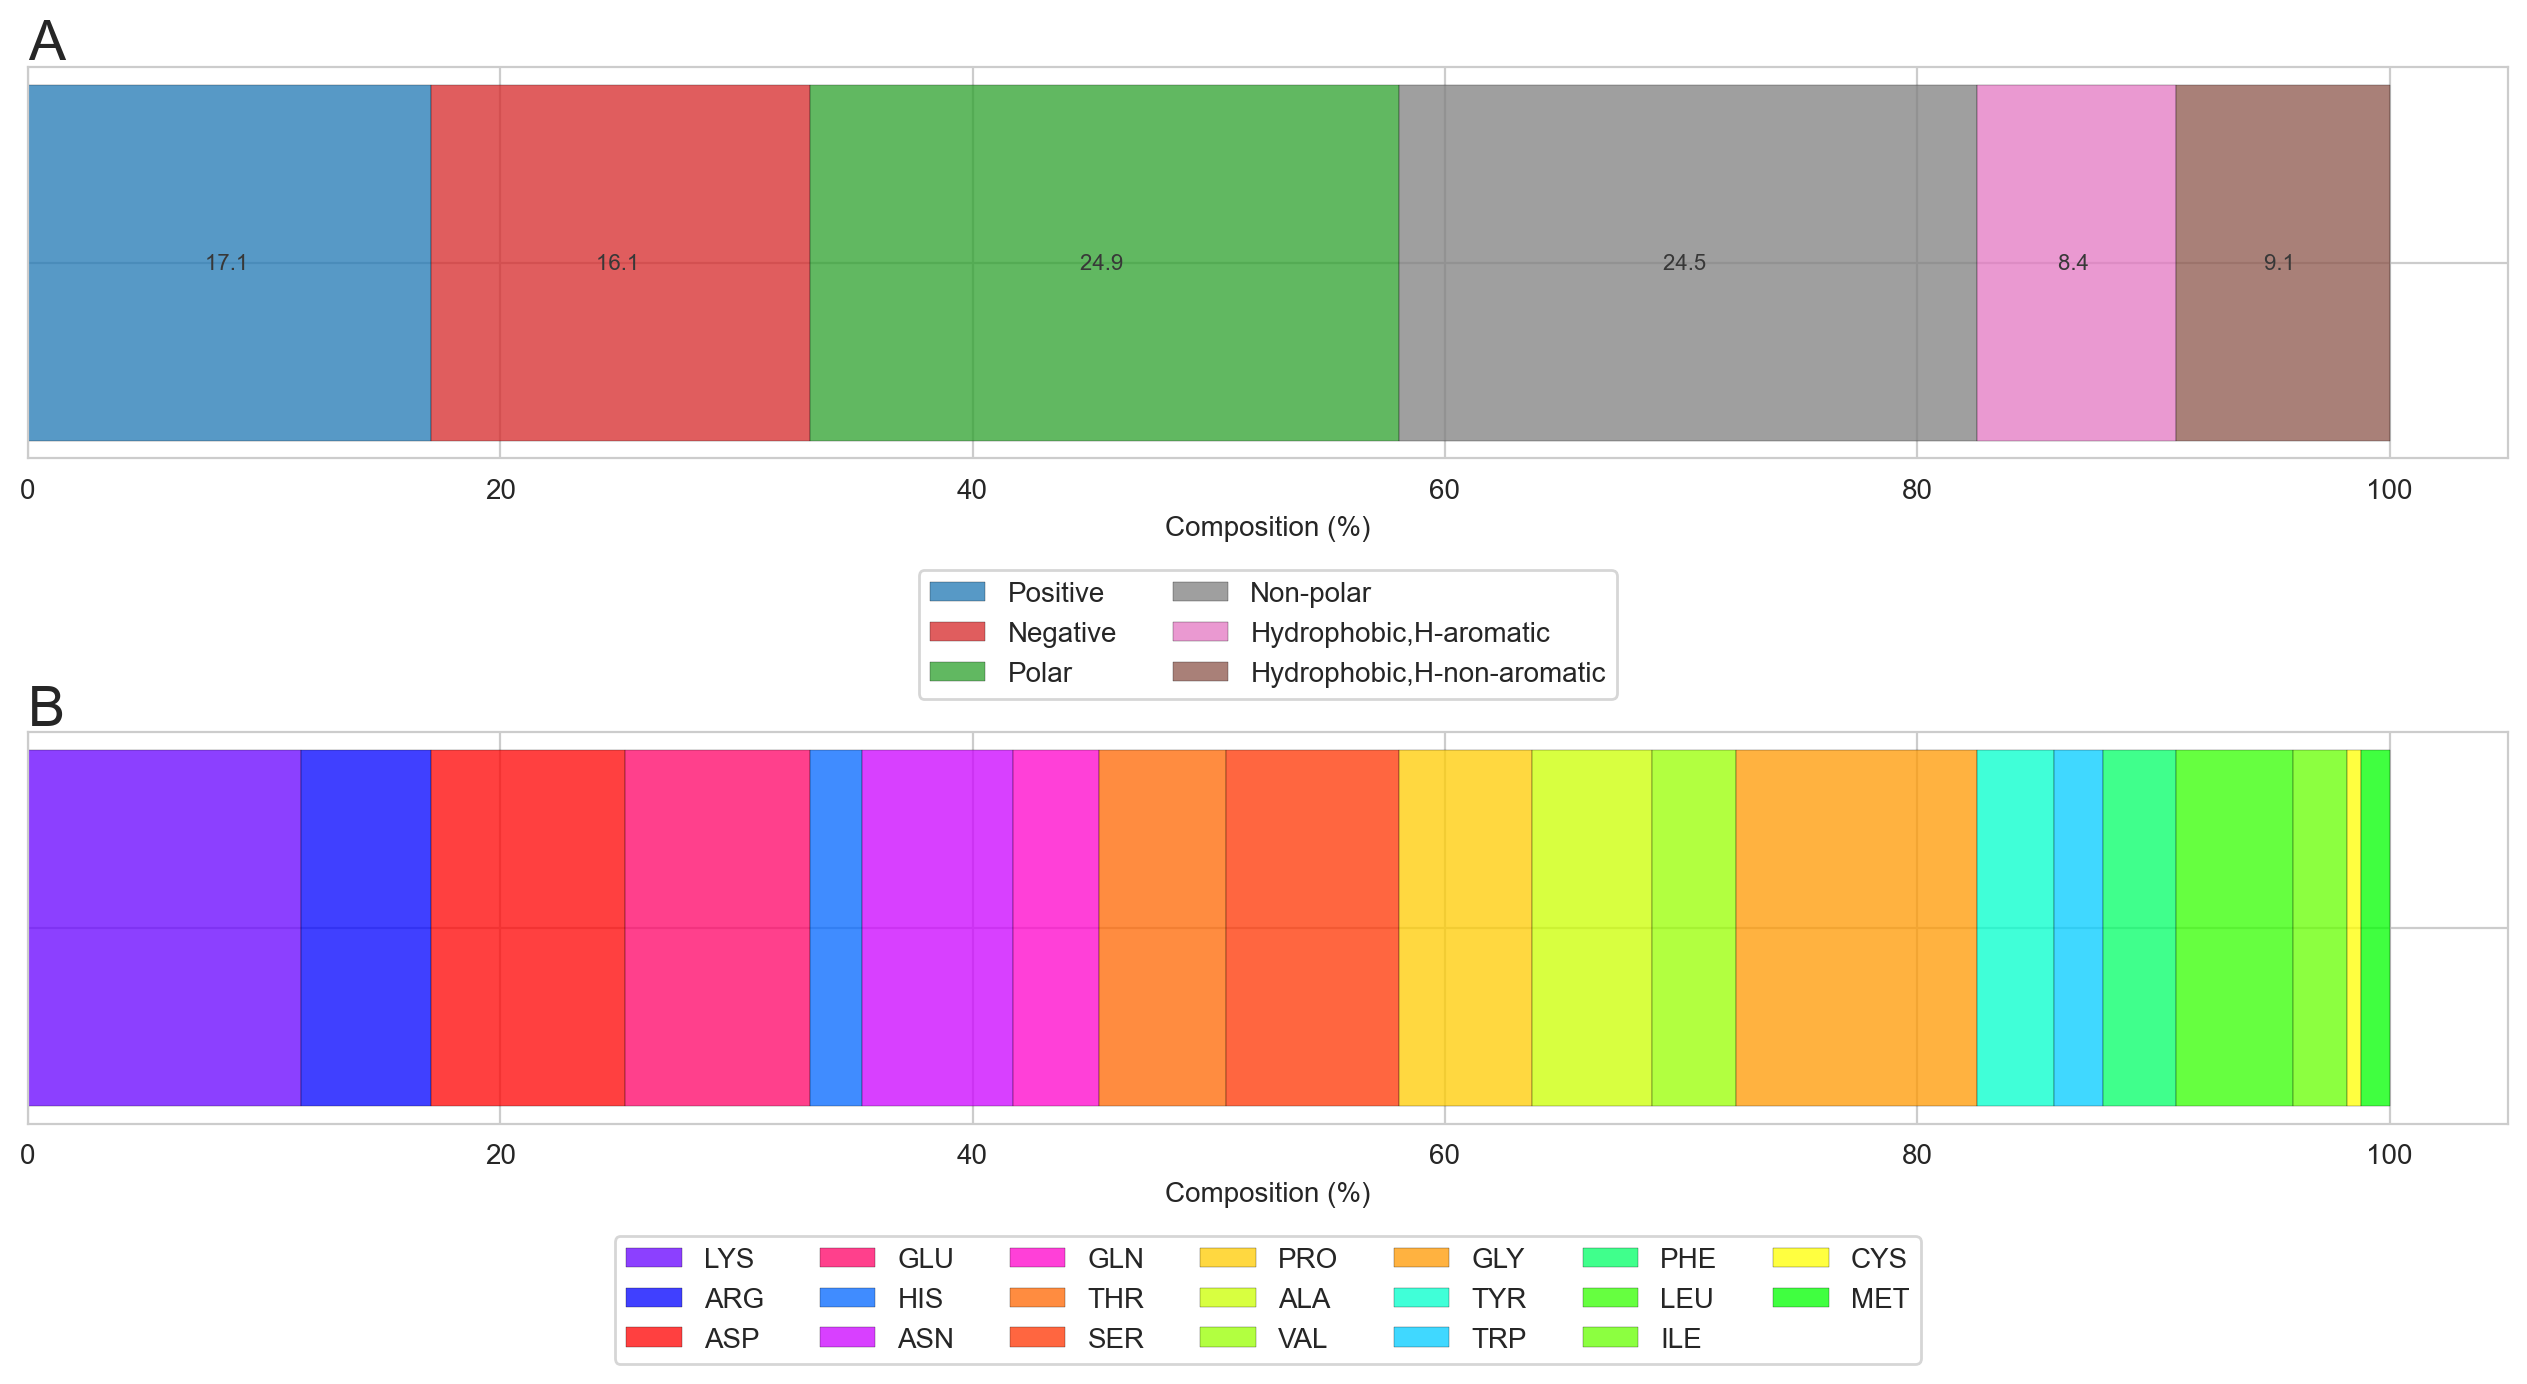

In [15]:
def composition_of_exposed_IBS(data, ax=None, PERTYPE=False):
    graph_data = data.to_frame()
    if PERTYPE:
        order_legend=["Positive",
                      "Negative",
                      "Polar",
                      "Non-polar",
                      "Hydrophobic,H-aromatic",
                      "Hydrophobic,H-non-aromatic",
                     ]
        color_palette=colorsPerType
        hue="type"
        weights="Percentage_Type"
        # graph_res_data=graph_res_data.drop_duplicates(["domain","type","Percentage_Type"])
    else:
        order_legend=["LYS","ARG",
                      "ASP","GLU",
                      "HIS","ASN","GLN","THR","SER",
                      "PRO","ALA","VAL","GLY",
                       "TYR","TRP","PHE",
                       "LEU","ILE","CYS","MET",
                     ]
        color_palette = {x:COLORS_taylor[x] for x in list(COLORS_taylor.keys())}
        hue='residue_name'
        weights='Percentage'

    
    graph_data.reset_index(inplace=True)
    graph_data.columns = ["residue_name","Percentage"]

    graph_data["type"] = graph_data["residue_name"].apply(lambda x: AATYPE[x])

    graph_data = graph_data.set_index(["type"])
    graph_data["Percentage_Type"] = graph_data.groupby("type").Percentage.sum()
    graph_data.reset_index(inplace=True)

    graph_data["data"] = "data"

    if PERTYPE:
        graph_data = graph_data.drop_duplicates("type")
    graph = sns.histplot(graph_data, y="data",hue=hue,weights=weights, multiple='stack', hue_order=order_legend[::-1], edgecolor='k',linewidth=0.1, palette=color_palette, legend=True, ax=ax)
    graph.set(ylabel="")
    graph.set_yticklabels("")

    if PERTYPE:
        for rec, label in zip(graph.patches,graph_data['Percentage_Type'].round(1).astype(str)):
                    height = rec.get_height()
                    width = rec.get_width()
                    val = f"{rec.get_width():.1f} "
                    size=8
        #             if PERTYPE:
        #                 size = 8
        #             else:
        #                 size = 4
                    ax.text((rec.xy[0]+rec.get_width()/2), (rec.xy[1]+rec.get_height()/2), val, size=size, color="#383838",
                            ha = 'center', va='center',
                        )

    #From https://github.com/mwaskom/seaborn/issues/2280#issuecomment-692350136
    def move_legend(ax, new_loc, title=None, invert=True, order=None, **kws):
            old_legend = ax.legend_
            handles = old_legend.legendHandles
            labels = [t.get_text() for t in old_legend.get_texts()]

            labels_handles = dict(zip(labels,handles))

            if invert:
                    handles=handles[::-1]
                    labels=labels[::-1]
            if title == None:
                    title = old_legend.get_title().get_text()

            if order:
                    handles = [labels_handles[x] for x in order]
                    labels = order

            ax.legend(handles, labels, loc=new_loc, title=title, **kws)


    move_legend(graph, 
        new_loc='center', 
        title="",
        order=order_legend,
        ncol=math.ceil(len(order_legend)/3), 
        bbox_to_anchor=(0.5,-0.45))


    graph.set(xlabel="Composition (%)")


dataCath = MERGED.domainDf.query("IBS == True and exposed == True").drop_duplicates(['residue_name', 'residue_number', 'cathpdb']).residue_name.value_counts(normalize=True)*100


plt.subplots(figsize=(16, 7))
gs = gridspec.GridSpec(ncols=1, nrows=2)
gs.update(hspace=0.7)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
composition_of_exposed_IBS(dataCath, ax=ax0, PERTYPE=True)
composition_of_exposed_IBS(dataCath, ax=ax1, PERTYPE=False)
_ = ax0.text(0,1.02, "A", transform=ax0.transAxes, fontsize=20)
_ = ax1.text(0,1.02, "B", transform=ax1.transAxes, fontsize=20)

save_fig("Fig 1",format="tif")






## Figure 2 - Protrusions and hydrophobic protrusions in the dataset 

### Figure

In [9]:
def count_protrusion_per_pdb(group):
    N = group.query("protrusion == True")
    return len(N)


def count_hydr_protrusion_per_pdb(group):
    N = group.query("protrusion == True and type.str.contains('Hydrophobic')", engine='python')
    return len(N)


def count_polar_protrusion_per_pdb(group):
    N = group.query("protrusion == True and type.str.contains('Polar')", engine='python')
    return len(N)

def count_nonpolar_protrusion_per_pdb(group):
    N = group.query("protrusion == True and type.str.contains('Non-polar')", engine='python')
    return len(N)

def count_negative_protrusion_per_pdb(group):
    N = group.query("protrusion == True and type.str.contains('Negative')", engine='python')
    return len(N)

def count_positive_protrusion_per_pdb(group):
    N = group.query("protrusion == True and type.str.contains('Positive')", engine='python')
    return len(N)

def calc_fract(group, property1, property2):
    """
    Calc the fraction to get property1 IN property2
    """
    total = len(group.query(property2, engine='python'))
    pr1 = len(group.query(f"{property1} and {property2}", engine='python'))
    if total == 0:
        return 0
    return pr1/total

#dataset25 = MERGED.domainDf.progress_apply(lambda x: reasigning_protrusion(x, 25), axis=1)
#dataset22 = MERGED.domainDf.progress_apply(lambda x: reasigning_protrusion(x, 22), axis=1)


In [10]:
count_protr_whole = MERGED.domainDf.query('atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_protrusion_per_pdb(group)).to_frame("count") 
count_hydr_protr_whole = MERGED.domainDf.query('atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_hydr_protrusion_per_pdb(group)).to_frame("count") 
# count_polar_protr_whole = MERGED.domainDf.query('atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_polar_protrusion_per_pdb(group)).to_frame("count") 
# count_nonpolar_protr_whole = MERGED.domainDf.query('atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_nonpolar_protrusion_per_pdb(group)).to_frame("count") 
# count_positive_protr_whole = MERGED.domainDf.query('atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_positive_protrusion_per_pdb(group)).to_frame("count") 
# count_negative_protr_whole = MERGED.domainDf.query('atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_negative_protrusion_per_pdb(group)).to_frame("count") 


count_protr_IBS = MERGED.domainDf.query('IBS == True and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_protrusion_per_pdb(group)).to_frame("count") 
count_hydr_protr_IBS = MERGED.domainDf.query('IBS == True and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_hydr_protrusion_per_pdb(group)).to_frame("count") 
# count_polar_protr_IBS = MERGED.domainDf.query('IBS == True and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_polar_protrusion_per_pdb(group)).to_frame("count") 
# count_nonpolar_protr_IBS = MERGED.domainDf.query('IBS == True and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_nonpolar_protrusion_per_pdb(group)).to_frame("count") 
# count_positive_protr_IBS = MERGED.domainDf.query('IBS == True and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_positive_protrusion_per_pdb(group)).to_frame("count") 
# count_negative_protr_IBS = MERGED.domainDf.query('IBS == True and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_negative_protrusion_per_pdb(group)).to_frame("count") 


count_protr_nonIBS = MERGED.domainDf.query('IBS == False and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_protrusion_per_pdb(group)).to_frame("count") 
count_hydr_protr_nonIBS = MERGED.domainDf.query('IBS == False and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_hydr_protrusion_per_pdb(group)).to_frame("count") 
# count_polar_protr_nonIBS = MERGED.domainDf.query('IBS == False and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_polar_protrusion_per_pdb(group)).to_frame("count") 
# count_nonpolar_protr_nonIBS = MERGED.domainDf.query('IBS == False and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_nonpolar_protrusion_per_pdb(group)).to_frame("count") 
# count_positive_protr_nonIBS = MERGED.domainDf.query('IBS == False and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_positive_protrusion_per_pdb(group)).to_frame("count") 
# count_negative_protr_nonIBS = MERGED.domainDf.query('IBS == False and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_negative_protrusion_per_pdb(group)).to_frame("count") 




freqs_hydro_protrusion_whole = MERGED.domainDf.query('atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: calc_fract(group,"type.str.contains('Hydrophobic')", "protrusion == True")).to_frame("count") 
freqs_hydro_protrusion_IBS = MERGED.domainDf.query('atom_name == "CB" and IBS == True').groupby('cathpdb').progress_apply(lambda group: calc_fract(group,"type.str.contains('Hydrophobic')", "protrusion == True")).to_frame("count") 
freqs_hydro_protrusion_nonIBS = MERGED.domainDf.query('atom_name == "CB" and IBS == False').groupby('cathpdb').progress_apply(lambda group: calc_fract(group,"type.str.contains('Hydrophobic')", "protrusion == True")).to_frame("count") 


[Text(0.5, 0, 'Number of protrusions'),
 Text(0, 0.5, 'Number of structures'),
 (0.0, 575.0),
 (0.0, 48.0)]

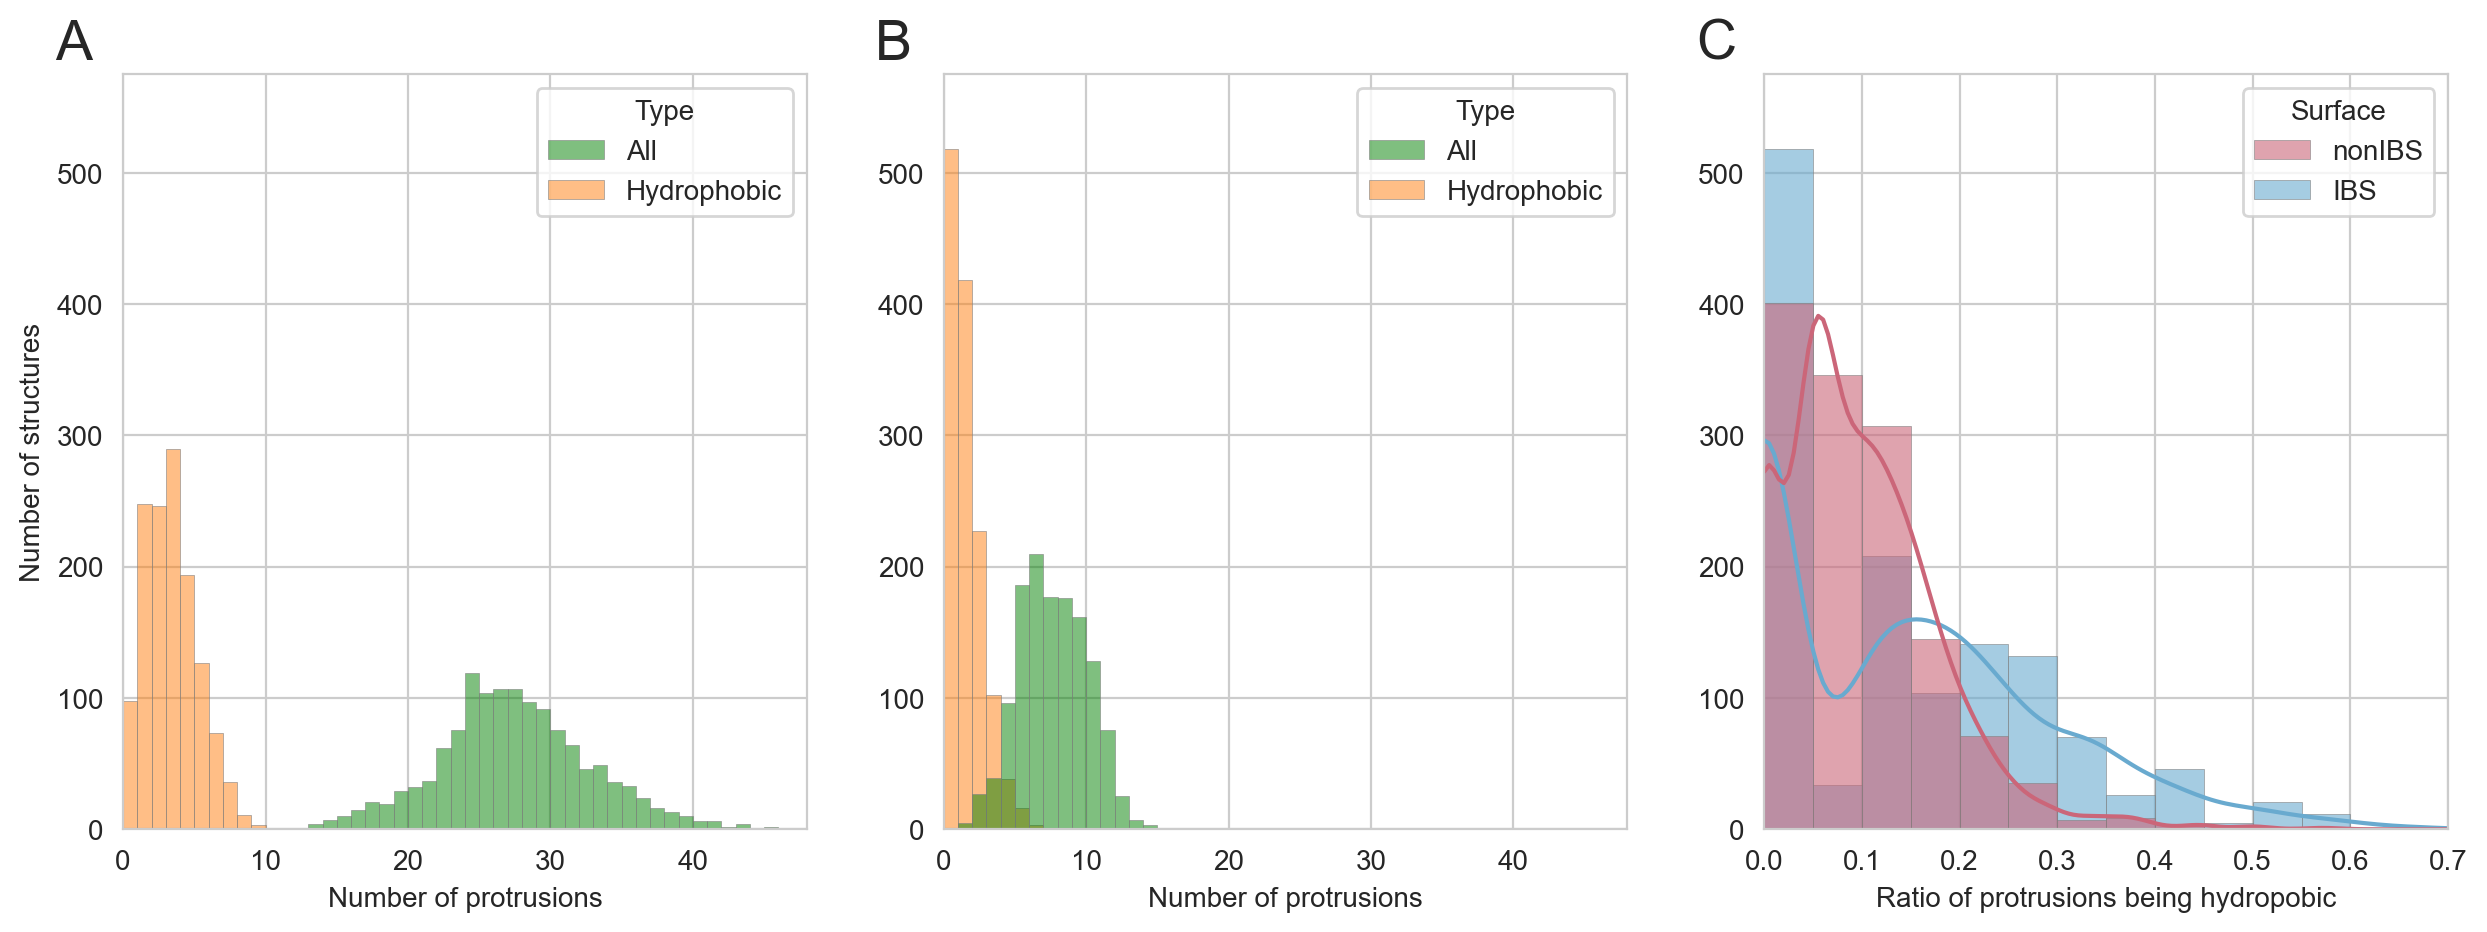

In [11]:


count_protr_whole["surface"] = "whole"
count_hydr_protr_whole["surface"] = "whole"
count_hydr_protr_IBS["surface"] = "IBS"
count_protr_IBS["surface"] = "IBS"
count_hydr_protr_nonIBS["surface"] = "nonIBS"
count_protr_nonIBS["surface"] = "nonIBS"

#WHOLE
count_protr_whole["Type"] = "All"
count_hydr_protr_whole["Type"] = "Hydrophobic"
# count_positive_protr_whole["Type"] = "positive"
# count_polar_protr_whole["Type"] = "polar"
# count_nonpolar_protr_whole["Type"] = "nonpolar"
# count_negative_protr_whole["Type"] = "negative"

#IBS
count_protr_IBS["Type"] = "All"
count_hydr_protr_IBS["Type"] = "Hydrophobic"
# count_positive_protr_IBS["Type"] = "positive"
# count_polar_protr_IBS["Type"] = "polar"
# count_nonpolar_protr_IBS["Type"] = "nonpolar"
# count_negative_protr_IBS["Type"] = "negative"

#non IBS
count_protr_nonIBS["Type"] = "All"
count_hydr_protr_nonIBS["Type"] = "Hydrophobic"
# count_positive_protr_nonIBS["Type"] = "positive"
# count_polar_protr_nonIBS["Type"] = "polar"
# count_nonpolar_protr_nonIBS["Type"] = "nonpolar"
# count_negative_protr_nonIBS["Type"] = "negative"

fig, axs = plt.subplots(1, 3, figsize=(15, 5))


if includeAlfafold:
    ylim=[0,900]
else:
    ylim=[0,575]

#GRAPH A
count_whole = pd.concat([count_protr_whole,
                         count_hydr_protr_whole,
                        #count_positive_protr_whole,
                        #count_polar_protr_whole,
                        #count_nonpolar_protr_whole,
                        #count_negative_protr_whole,
                        ], axis=0).reset_index()
max_x_whole = count_whole["count"].max()


graph_whole = sns.histplot(count_whole, 
                          x="count",
                          hue="Type",
#                           stat="probability",
                          #kind="kde",
                           palette=["green","#ff7F0E"],
                           alpha=0.5,
                          bins=list(range(0,max_x_whole)),
                           edgecolor="gray", linewidth=0.2,
                           common_bins=False,
                           common_norm=False,
                           
                          ax=axs[0],
                          )
_ = sns.despine(left=False, bottom=False, top=False, right=False) #All 4 borders

graph_whole.set(xlabel="Number of protrusions",
                ylabel="Number of structures",
#                 ylim=[0,0.42],
#                 ylim=[0,575]
                 ylim=ylim,
                xlim=[0,48],
               )
# _ = graph_whole.set_title("Whole surface", fontsize=11)

#Graph B
count_IBS = pd.concat([count_protr_IBS,
                       count_hydr_protr_IBS,
                       #count_positive_protr_IBS,
                       #count_polar_protr_IBS,
                       #count_nonpolar_protr_IBS,
                       #count_negative_protr_IBS,
                      ], axis=0).reset_index()
max_x_IBS = count_IBS["count"].max()

graph_IBS = sns.histplot(count_IBS, 
                         x="count",
                         hue="Type",
#                          stat="probability",
                         bins=list(range(0,max_x_IBS)),
                         #kind="kde",
                         alpha=0.5,
                         palette=["green","#ff7F0E"],
                         edgecolor="gray", linewidth=0.2,
                         common_norm=False,
                         ax=axs[1])

_ = graph_IBS.set(xlabel="Number of protrusions",
              ylabel="",
               ylim=ylim,
#                 ylim=[0,575],
               xlim=[0,48],
                 )
#_ = graph_IBS.set_title("IBS surface", fontsize=11)
_ = sns.despine(left=False, bottom=False, top=False, right=False) #All 4 borders

#Write letters



freqs_hydro_protrusion_whole["Surface"] = "whole"
freqs_hydro_protrusion_nonIBS["Surface"] = "nonIBS"
freqs_hydro_protrusion_IBS["Surface"] = "IBS"
ratio_graph_data = pd.concat([freqs_hydro_protrusion_nonIBS,freqs_hydro_protrusion_IBS], axis=0).reset_index()
max_x = ratio_graph_data["count"].max()

#graph1 = sns.histplot(test.query("Surface == 'whole'"), x="count", bins=np.arange(0,0.8,0.05), alpha=0.6,color="#8de5A1", stat="probability",  ax=axs[2], linewidth=0.2,edgecolor="gray")
#graph2 = sns.histplot(test.query("Surface == 'IBS'"), x="count", bins=np.arange(0,0.8,0.05), alpha=0.6, color="#cb6679",stat="probability",ax=axs[2], linewidth=0.2,edgecolor="gray")
graph_ratio = sns.histplot(ratio_graph_data, 
                          hue="Surface", 
                          x="count", 
                          bins=np.arange(0,0.8,0.05), 
                          alpha=0.6,
                          #stat="probability", 
                          palette=["#cb6679","#69aacf"],  
                          ax=axs[2],
                          linewidth=0.2,
                          kde=True,
                          common_norm=False,
                          edgecolor="gray")
#old color = #cb6679 / #69aacf
_ = sns.despine(left=False, bottom=False, top=False, right=False) #All 4 borders

#graph.set(xlabel="Number of protrusions", ylabel="Number of protein",title="Number of hydrophobic protrusions per protein (Whole)")

# ---- Legend ----
#top_bar = mpatches.Patch(color='#8de5a1', label='Whole surface', alpha=0.6, linewidth=0)
#bottom_bar = mpatches.Patch(color='#cb6679', label='IBS surface', alpha=0.6, linewidth=0)
#axs[2].legend(handles=[top_bar, bottom_bar])

_ = axs[2].set(xlabel="Ratio of protrusions being hydropobic",
                ylabel="",
                xlim=[0,0.7],
#                 ylim=[0,575],
                 ylim=ylim,
                )
#_ = axs[2].text(-0.1,1.1, "Ratio of protrusions being hydrophobic", transform=axs[2].transAxes, fontsize=15)
_ = axs[2].tick_params(labelsize=10)

_ = axs[0].text(-0.1,1.02, "A", transform=axs[0].transAxes, fontsize=20)
#_ = axs[0].text(0.5,1.1, "Number of protrusions per structure", transform=axs[0].transAxes, fontsize=15)
_ = axs[1].text(-0.1,1.02, "B", transform=axs[1].transAxes, fontsize=20)
_ = axs[2].text(-0.1,1.02, "C", transform=axs[2].transAxes, fontsize=20)

save_fig(f"Fig 2{filesufix}", transparent=False, format=FORMAT)




### Corresponding Statistical Tests

In [12]:
pop1 = ratio_graph_data.query("Surface == 'IBS'")["count"]
pop2 = ratio_graph_data.query("Surface == 'nonIBS'")["count"]
equality_test(pop1,pop2, "greater")

<span style='color:None'>**STATISTICAL TEST BETWEEN TWO SAMPLES**</span>

<span style='color:None'> - ALTERNATIVE HYPOTHESIS = greater</span>

<span style='color:None'>**NORMALITY TEST (shapiro)**</span>

<span style='color:None'>*The two samples should follow a normal law to use a standard t.test*</span>

<span style='color:red'>---- Sample 1 shapioro test pvalue = 9.38E-33, <= 0.05. This sample DO NOT follow a normal law</span>

<span style='color:red'>---- Sample 1 shapioro test pvalue = 1.16E-27, <= 0.05. This sample DO NOT follow a normal law</span>

<span style='color:None'>One or both sample(s) doesn't follow a normal law.</span>

<span style='color:None'>Performing a Wilcoxon Rank sum test with continuity correction</span>

<span style='color:None'>**WILCOXON RANK SUM TEST WITH CONTINUITY CORRECTION (or Mann-Whitney test)**</span>

<span style='color:None'>  Null hypothesis : the two distribution are equals</span>

<span style='color:None'>  Alternative hypothesis : pop1 > pop2</span>

<span style='color:red'>  pvalue = 2.97E-07 which is <= 0.05. The null hypothesis is rejected. The alternative hypothesis (fgreater) is valid and the two distrubition are different</span>

### Percentage of the dataset without HP

In [13]:
print("-- nonIBS SURFACE --")
print(f" protrusions .............. {count_protr_nonIBS['count'].mean():.2f} ± {count_protr_nonIBS['count'].std():.2f}") 
print(f" hydrophobic protrusions .. {count_hydr_protr_nonIBS['count'].mean():.2f} ± {count_hydr_protr_nonIBS['count'].std():.2f}") 


print("-- IBS SURFACE --")
print(f" protrusions .............. {count_protr_IBS['count'].mean():.2f} ± {count_protr_IBS['count'].std():.2f}") 
print(f" hydrophobic protrusions .. {count_hydr_protr_IBS['count'].mean():.2f} ± {count_hydr_protr_IBS['count'].std():.2f}") 

print("-- whole surface --")
print(f" protrusions .............. {count_protr_whole['count'].mean():.2f} ± {count_protr_whole['count'].std():.2f}") 
print(f" hydrophobic protrusions .. {count_hydr_protr_whole['count'].mean():.2f} ± {count_hydr_protr_whole['count'].std():.2f}")

-- nonIBS SURFACE --
 protrusions .............. 19.82 ± 5.09
 hydrophobic protrusions .. 1.82 ± 1.45
-- IBS SURFACE --
 protrusions .............. 7.18 ± 2.45
 hydrophobic protrusions .. 1.08 ± 1.17
-- whole surface --
 protrusions .............. 26.96 ± 5.40
 hydrophobic protrusions .. 2.90 ± 1.85


In [14]:
print("Percentage of the dataset without hydrophobic protrusions")

perc = ratio_graph_data.groupby("Surface").apply(lambda x: len(x.query("count <0.05")) / len(x) * 100)
vals = ratio_graph_data.groupby("Surface").apply(lambda x: len(x.query("count <0.05")))
print("      percentage")
print(perc)
print("      values")
print(vals)

Percentage of the dataset without hydrophobic protrusions
      percentage
Surface
IBS       39.183056
nonIBS    30.195783
dtype: float64
      values
Surface
IBS       518
nonIBS    401
dtype: int64


In [15]:
ratio_graph_data.groupby("Surface").apply(lambda x: len(x.query("count >=0.05")))

Surface
IBS       804
nonIBS    927
dtype: int64

In [16]:
def count_percentage_of_the_convexhull(pdb):
    """
    evaluate the percentage of the convexhull to be part of the IBS and not IBS.
    """
    df = pdb.query("atom_name == 'CB' and convhull_vertex == True")
    n_vertices = len(df)
    n_vertices_IBS = len(df.query("IBS == True"))
    n_vertices_nonIBS = len(df.query("IBS == False"))

    ret = [n_vertices_IBS/n_vertices*100,n_vertices_nonIBS/n_vertices*100]

    return(pd.DataFrame(ret, index=["fraction_IBS","fraction_nonIBS"]))






res = MERGED.domainDf.groupby("cathpdb", as_index=False).progress_apply(lambda x: count_percentage_of_the_convexhull(x))
print(f"Percentage of the convexhull being part of the IBS: {res.loc[(slice(None), 'fraction_IBS'), :].mean()[0]:.2f}% ± {res.loc[(slice(None), 'fraction_IBS'), :].std()[0]:.2f}%")
print(f"Percentage of the convexhull NOT being part of the IBS: {res.loc[(slice(None), 'fraction_nonIBS'), :].mean()[0]:.2f}% ± {res.loc[(slice(None), 'fraction_nonIBS'), :].std()[0]:.2f}%")





Percentage of the convexhull being part of the IBS: 24.39% ± 7.66%
Percentage of the convexhull NOT being part of the IBS: 75.61% ± 7.66%


In [17]:
def count_fraction_of_IBS(pdb):
    """
    evaluate the percentage of the convexhull to be part of the IBS and not IBS.
    """
    df = pdb.query("atom_name == 'CB' and convhull_vertex == True")
    n_vertices = len(df)
    n_vertices_IBS = len(df.query("IBS == True"))
    n_protrusion = len(df.query("protrusion == True"))

    ret = [n_vertices_IBS/n_vertices*100]

    return(ret)

res = backup_prot_noHPIBS.groupby("cathpdb", as_index=False).progress_apply(lambda x: count_fraction_of_IBS(x))
print(f"Percentage of the IBS covered by protrusion for protreins without hydrophobic protrusions at their IBS: {res.iloc[:,1].mean():.2f}±{res.iloc[:,1].std():.2f}%")


Percentage of the IBS covered by protrusion for protreins without hydrophobic protrusions at their IBS: 21.47±6.95%


## Figure 3 - Composition of the IBS/nonIBS for Protein With HP at IBS

### Composition

     IBS sec_struc  Percentage Surface
0  False         C    0.638851  nonIBS
1  False         H    0.227086  nonIBS
2  False         E    0.134063  nonIBS
3   True         C    0.726891     IBS
4   True         H    0.245798     IBS
5   True         E    0.027311     IBS
  Secondary Structure  oddsratio        pvalue  lower_CI  upper_CI       err
0                Loop   0.408524  3.811020e-07  0.250600  0.566448  0.157924
1            β-strand  -1.707275  1.301495e-27 -2.059273 -1.355277  0.351998
2             α-helix   0.103689  2.374847e-01 -0.068015  0.275394  0.171704


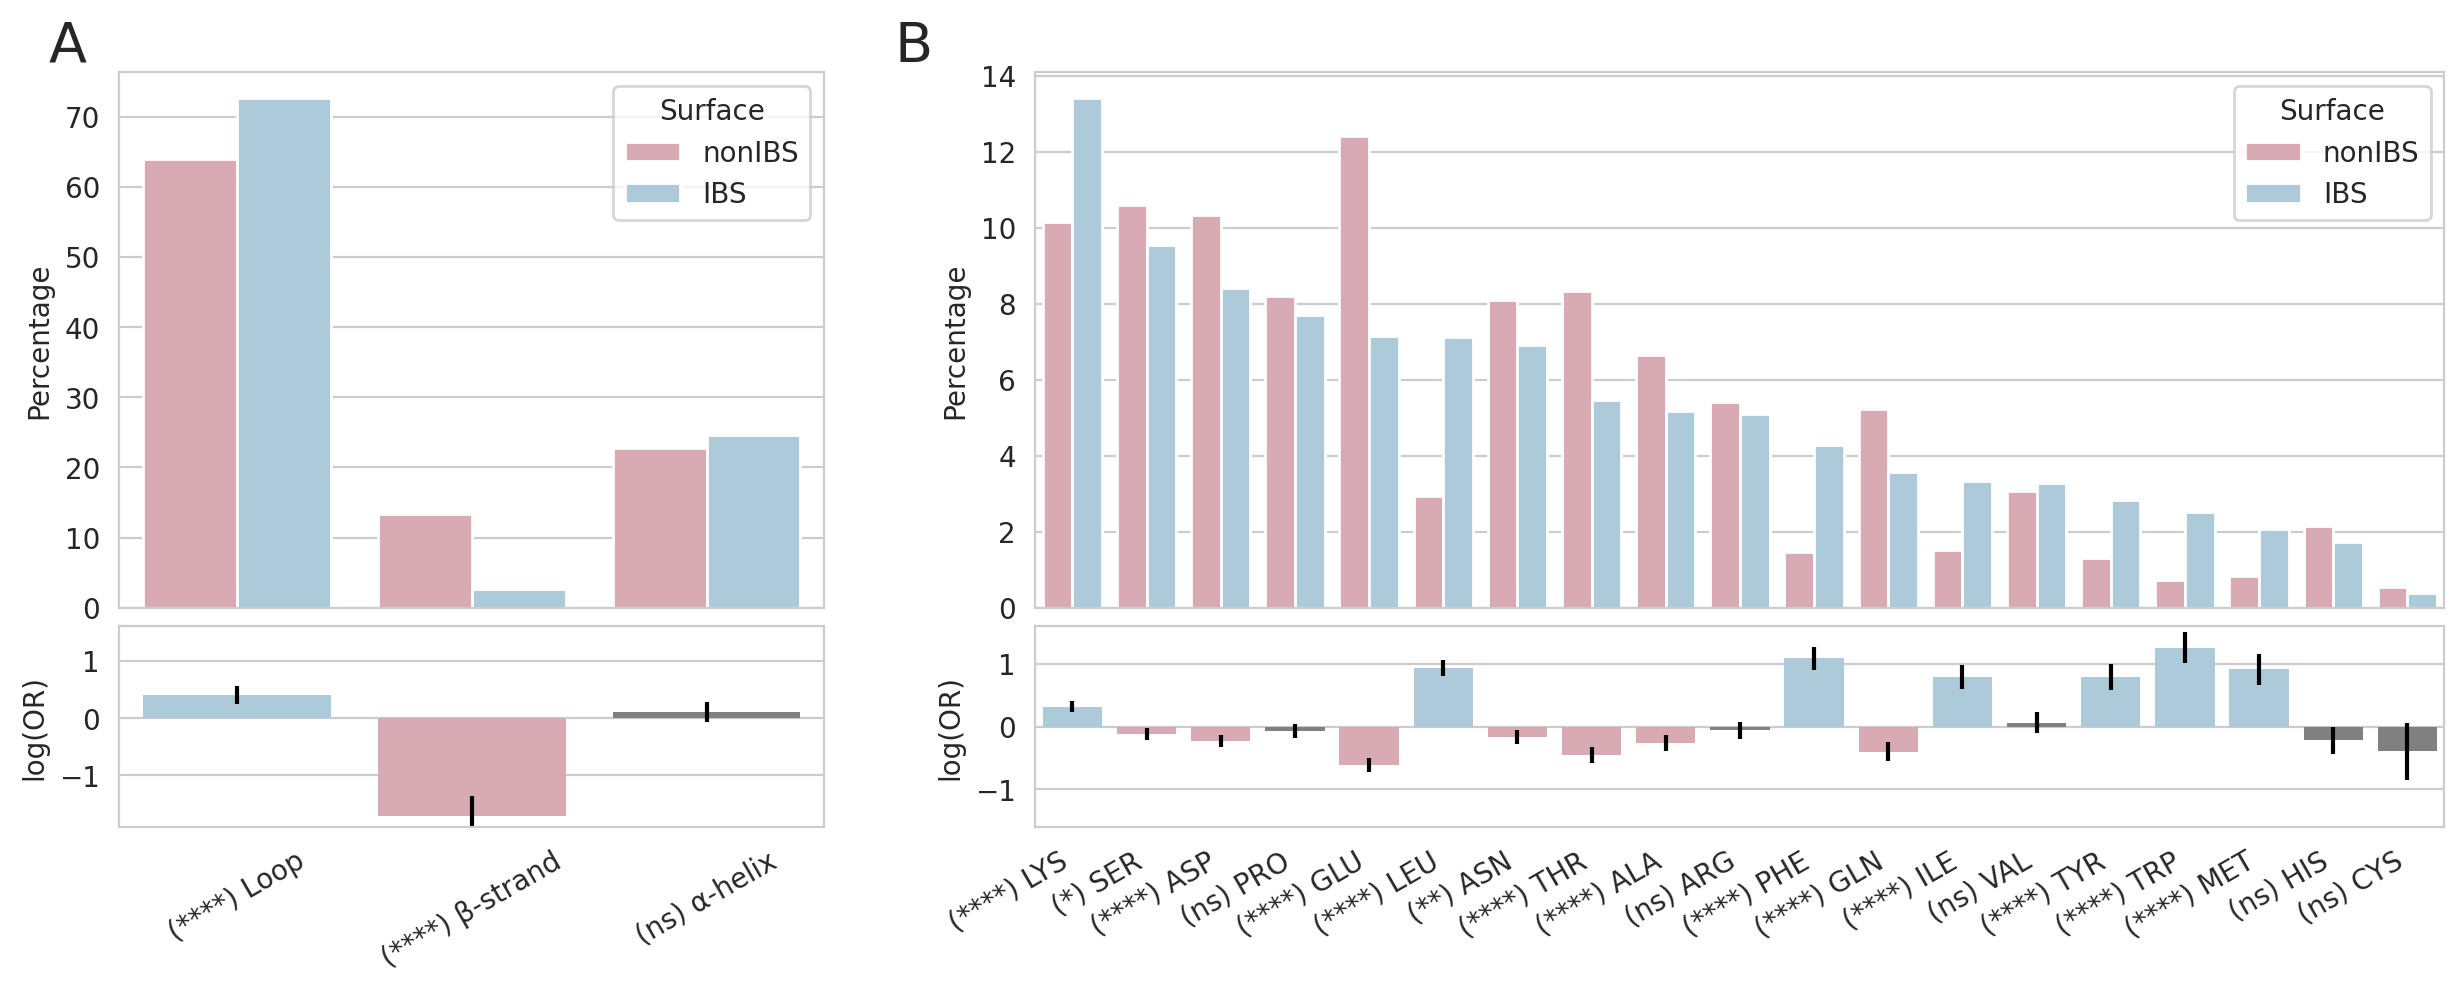

In [18]:
sns.set_style("whitegrid") #Seaborn style
MERGED.domainDf = backup_prot_HPIBS.copy()
plt.rcParams["font.family"] = "DejaVu Sans" #Old = "DejaVu Sans" / "DejaVu Serif"

def adapt_figsize_PLOS(width, height, maximum_width=7.5):
   ratio = height/width
   new_figsize=(maximum_width,height*ratio)
   return(new_figsize)


fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=[1,2], height_ratios=[8,3])
gs.update(hspace=0.05)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])

### Protrusion Secondary Structure
tc_sec_struc = MERGED.domainDf.query("protrusion == True and type in ['Hydrophobic,H-non-aromatic', 'Hydrophobic,H-aromatic']").groupby("IBS").sec_struc.value_counts(normalize=True).to_frame('Percentage').reset_index()
tc_sec_struc["Surface"] = tc_sec_struc["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
labelsdict = {"C":"Loop", "E":"β-strand","H":"α-helix"}

print(tc_sec_struc)
try: #Just pandas update change in output index.
   tc_sec_struc["Secondary Structure"] = tc_sec_struc["sec_struc"].apply(lambda x: labelsdict[x])
except: 
   tc_sec_struc["Secondary Structure"] = tc_sec_struc["level_1"].apply(lambda x: labelsdict[x])

MERGED.domainDf["Secondary Structure"] = MERGED.domainDf["sec_struc"].apply(lambda x: labelsdict[x])
tc_sec_struc["Percentage"] = tc_sec_struc["Percentage"]*100

graph = sns.barplot(data=tc_sec_struc,
                    x="Secondary Structure",
                    y="Percentage",
                    hue="Surface",
                    palette=palette_IBS,
                    ax=ax0)
_= graph.set(title="",#Secondary structure element",
         xlabel="",
            xticklabels=[])

#### Amino acid composition
tc_resname = MERGED.domainDf.query("protrusion == True ").groupby("IBS")["residue_name"].value_counts(normalize=True).to_frame('Percentage').reset_index()
tc_resname["Surface"] = tc_resname["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
tc_resname["Percentage"] = tc_resname["Percentage"]*100
residue_name_order = tc_resname.query("Surface == 'IBS'").sort_values("Percentage", ascending=False).residue_name
graph2 = sns.barplot(data=tc_resname,
                    x="residue_name",
                    y="Percentage",
                    hue="Surface",
                    palette=palette_IBS,  
                    ax=ax1,
                   order = residue_name_order)
_= graph2.set(title="", #Amino acid", 
              xlabel="",
             xticklabels=[],
             )
#_= graph2.set_xticklabels(graph2.get_xticklabels(),rotation=30, size=8)



#save_fig("fig2_protrusions_composition")


### ODDS RATIO SSE
oddratios_SSE = MERGED.analysis.oddsratio_graph(among="HP", feature="Secondary Structure", axs=ax0, title="Log(OR) - Secondary structures", xlim=(-1.5,1.0), return_dataset=True)
print(oddratios_SSE)

oddratios_SSE = significance(oddratios_SSE)

palette = get_palette_OR(oddratios_SSE)
graphOR1 = sns.barplot(data=oddratios_SSE, x="Secondary Structure",y="oddsratio", orient="v", palette=palette, linewidth=0, yerr=oddratios_SSE["err"], ax=ax2)
_= graphOR1.set(ylabel="log(OR)",
               xlabel="",
                ylim=[-1.90,1.6],
               )

#_= graphOR1.set_xticklabels(graphOR1.get_xticklabels(),rotation=30, size=10)
_= graphOR1.set_xticklabels(oddratios_SSE["labels"],rotation=30, size=10)

### ODDS RATIO Amino acids

oddratios_AA = MERGED.analysis.oddsratio_graph(among="protrusions", feature="residue_name", axs=ax1,title="Log(OR) per amino acid",return_dataset=True)
#Reorder the oddratio dataframe according the residue_name_order
oddratios_AA = significance(oddratios_AA)

oddratios_AA = oddratios_AA.set_index("residue_name").loc[residue_name_order].reset_index()
palette = get_palette_OR(oddratios_AA)
graphOR2 = sns.barplot(data=oddratios_AA, x="residue_name",y="oddsratio", orient="v", palette=palette, linewidth=0, yerr=oddratios_AA["err"], ax=ax3)
_= graphOR2.set(ylabel="log(OR)",
                xlabel="",
                ylim=[-1.6,1.6],
               )
#_= graphOR2.set_xticklabels(graphOR2.get_xticklabels(),rotation=30, size=10)
_= graphOR2.set_xticklabels(oddratios_AA["labels"],rotation=30, size=10, horizontalalignment='right')



#Adding labels
#_= ax0.text(1,1.15, "Protrusions composition",transform=ax0.transAxes, fontsize=20)
#_= ax0.text(2,1.15, "(Protreins with HP at IBS)",transform=ax0.transAxes, fontsize=8)

_= ax0.text(-0.1,1.02, "A",transform=ax0.transAxes, fontsize=20)
_= ax1.text(-0.1,1.02, "B",transform=ax1.transAxes, fontsize=20)
# _= ax2.text(-0.1,0.8, "C",transform=ax2.transAxes, fontsize=20)
# _= ax3.text(-0.1,0.8, "D",transform=ax3.transAxes, fontsize=20)

save_fig(f"Fig 3{filesufix}", transparent=False, format=FORMAT)

MERGED.domainDf = backup_all.copy()

In [19]:
# fig = plt.figure(figsize=(15,5))
# gs = gridspec.GridSpec(ncols=2, nrows=1, height_ratios=[8,3])
# gs.update(hspace=0.05)
# ax0 = plt.subplot(gs[0,0])
# ax1 = plt.subplot(gs[0,1])

# #### Amino acid composition
# tc_resname = MERGED.domainDf.query("protrusion == True and type in ['Hydrophobic,H-non-aromatic', 'Hydrophobic,H-aromatic']").groupby("IBS")["residue_name"].value_counts(normalize=True).to_frame('Percentage').reset_index()
# tc_resname["Surface"] = tc_resname["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
# tc_resname["Percentage"] = tc_resname["Percentage"]*100
# residue_name_order = tc_resname.query("Surface == 'IBS'").sort_values("Percentage", ascending=False).residue_name
# graph2 = sns.barplot(data=tc_resname,
#                     x="residue_name",
#                     y="Percentage",
#                     hue="Surface",
#                     palette=palette_IBS,  
#                     ax=ax1,
#                    order = residue_name_order)
# _= graph2.set(title="", #Amino acid", 
#               xlabel="",
#              xticklabels=[],
#              )
# #_= graph2.set_xticklabels(graph2.get_xticklabels(),rotation=30, size=8)

ValueError: Expected the given number of height ratios to match the number of rows of the grid

<Figure size 3000x1000 with 0 Axes>

## Figure 4 -  Neighbourhood composition

In [20]:
MERGED.domainDf = backup_prot_HPIBS.copy()

tableCount, oddratios_AA = MERGED.analysis.oddsratio_graph(among="is_hydrophobic_protrusion", feature="residue_name", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCount.reset_index(inplace=True)
tableCount["Percentage"] = tableCount.groupby(["IBS","residue_name"], as_index=False).apply(lambda x: x.Count/x.total*100).droplevel(0)
tableCount["Surface"] = tableCount["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
#tableCount, oddratios_AA = MERGED.analysis.oddsratio_graph(among="protrusions", feature="residue_name", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCountSSE, oddratios_SSE = MERGED.analysis.oddsratio_graph(among="is_hydrophobic_protrusion", feature="sec_struc", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCountSSE.reset_index(inplace=True)
tableCountSSE["Percentage"] = tableCountSSE.groupby(["IBS","sec_struc"], as_index=False).apply(lambda x: x.Count/x.total*100).droplevel(0)
tableCountSSE["Surface"] = tableCountSSE["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
labelsdict = {"C":"Loop", "E":"β-strand","H":"α-helix"}
tableCountSSE["Secondary Structure"] = tableCountSSE["sec_struc"].apply(lambda x: labelsdict[x])
oddratios_SSE.insert(0, "Secondary Structure", oddratios_SSE["sec_struc"].apply(lambda x: labelsdict[x]))
MERGED.domainDf = backup_all.copy()

518

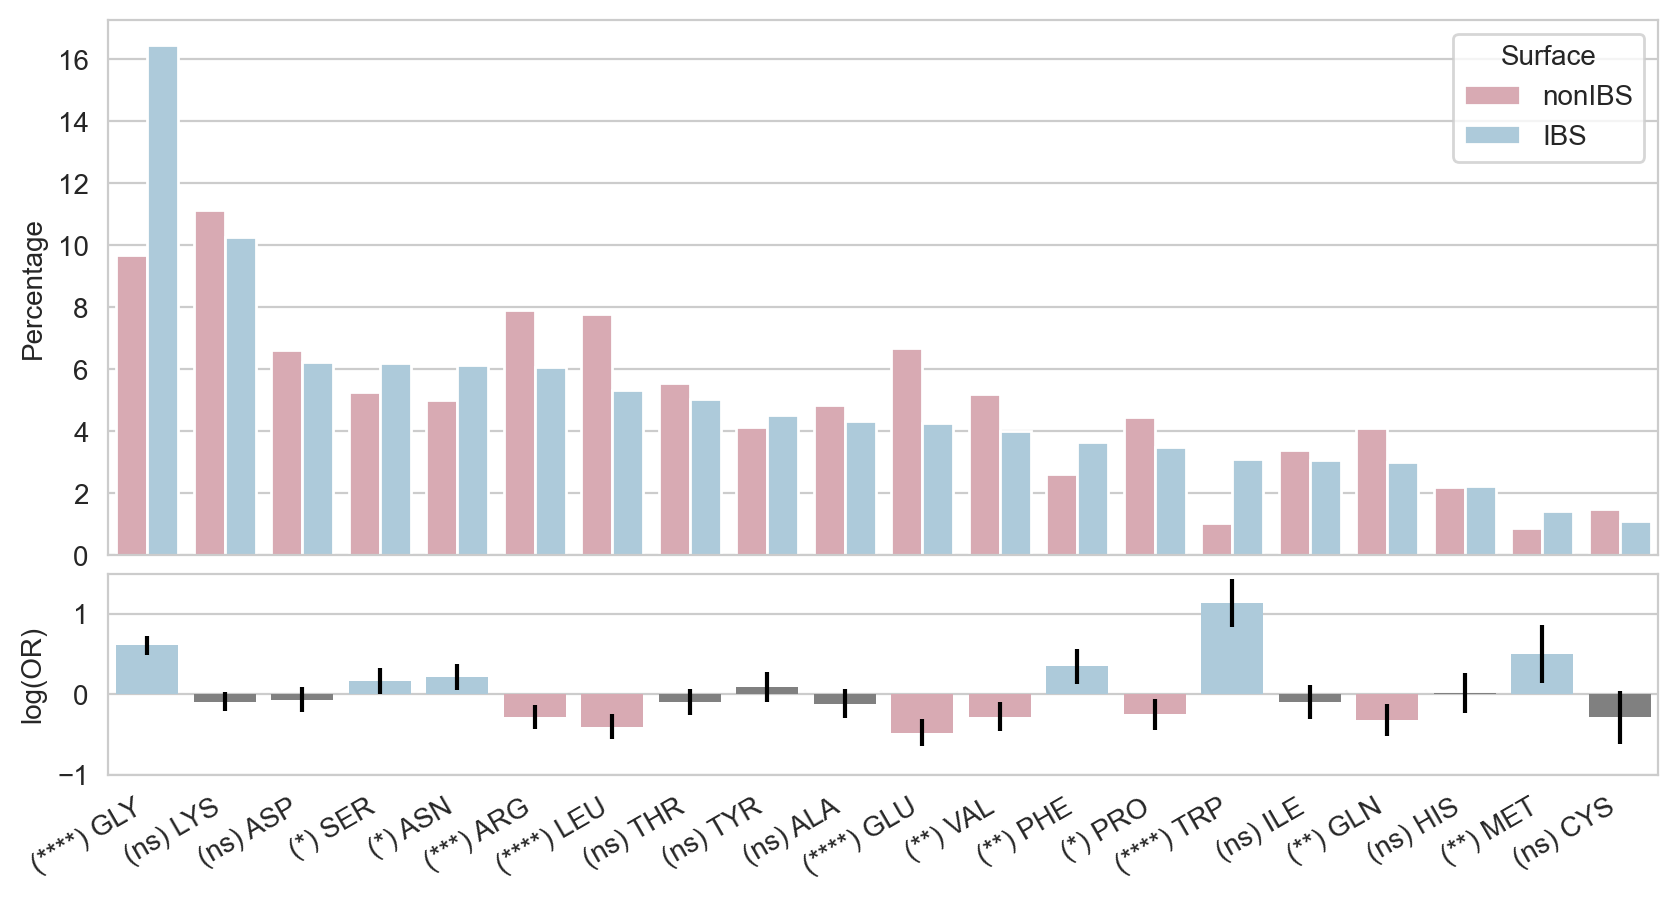

In [21]:
MERGED.domainDf = backup_prot_noHPIBS.copy()
sns.set_style("whitegrid",{'legend.frameon':True}) #Seaborn style

fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(ncols=1, nrows=2, width_ratios=[1], height_ratios=[8,3])
gs.update(hspace=0.05)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])

#### Amino acid composition
tc_resname = tableCount
residue_name_order = tc_resname.query("Surface == 'IBS'").sort_values("Percentage", ascending=False).residue_name
graph2 = sns.barplot(data=tc_resname,
                    x="residue_name",
                    y="Percentage",
                    hue="Surface",
                    palette=palette_IBS,  
                    ax=ax0,
                   order = residue_name_order,
                    )


_= graph2.set(title="", #"Hydrophobic protrusions exposed environment composition", 
              xlabel="",
             xticklabels=[]
             )

### ODDS RATIO Amino acids

#Reorder the oddratio dataframe according the residue_name_order
oddratios_AA = oddratios_AA.set_index("residue_name").loc[residue_name_order].reset_index()
palette = get_palette_OR(oddratios_AA)
graphOR2 = sns.barplot(data=oddratios_AA, x="residue_name",y="oddsratio", orient="v", palette=palette, linewidth=0, yerr=oddratios_AA["err"], ax=ax1)
_= graphOR2.set(ylabel="log(OR)",
                xlabel="",
                ylim=(-1,1.5),
               )


_= graphOR2.set_xticklabels(graphOR2.get_xticklabels(),rotation=30, size=10)
oddratios_AA = significance(oddratios_AA)
_= graphOR2.set_xticklabels(oddratios_AA["labels"], horizontalalignment="right",rotation=30, size=10)



#Adding labels
# _= ax0.text(0.1,1.15, "Hydrophobic protrusions exposed environment composition",transform=ax0.transAxes, fontsize=20)
# _= ax0.text(-0.1,1.02, "A",transform=ax0.transAxes, fontsize=20)
# _= ax1.text(-0.1,1.02, "B",transform=ax1.transAxes, fontsize=20)
# _= ax2.text(-0.1,0.8, "C",transform=ax2.transAxes, fontsize=20)
# _= ax3.text(-0.1,0.8, "D",transform=ax3.transAxes, fontsize=20)

save_fig(f"Fig 4{filesufix}", transparent=False, format=FORMAT)
MERGED.domainDf = backup_all.copy()

## Figure 5. Number of structures with and without HP at IBS and comparison of both datasets

### Figure

In [24]:
count_protr_ibs_HPIBS = backup_prot_HPIBS.query('IBS == True and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_protrusion_per_pdb(group)).to_frame("count")
count_protr_ibs_noHPIBS = backup_prot_noHPIBS.query('IBS == True and atom_name == "CB"').groupby('cathpdb').progress_apply(lambda group: count_protrusion_per_pdb(group)).to_frame("count")

In [25]:
backup_prot_HPIBS.domain.unique()

array(['PH', 'C2', 'START', 'C1', 'C2DIS', 'PX', 'PLD', 'ANNEXIN', 'PLA'],
      dtype=object)

[Text(0.5, 0, 'Number of protrusions'), Text(0, 0.5, 'Frequency')]

    domain  without hydrophobic protrusions  Number of PDBS  percentage
0    C2DIS                              177             325    0.544615
1    START                              114             201    0.567164
2       PH                              103             275    0.374545
3  ANNEXIN                               40             122    0.327869
4       C2                               34             112    0.303571
5      PLD                               25              67    0.373134
6       C1                               11              38    0.289474
7      PLA                                8             141    0.056738
8       PX                                6              47    0.127660


[Text(0, 0, 'ANNEXIN'),
 Text(1, 0, 'C1'),
 Text(2, 0, 'C2'),
 Text(3, 0, 'DIS-C2'),
 Text(4, 0, 'PH'),
 Text(5, 0, 'PLA'),
 Text(6, 0, 'PLC/PLD'),
 Text(7, 0, 'PX'),
 Text(8, 0, 'START')]

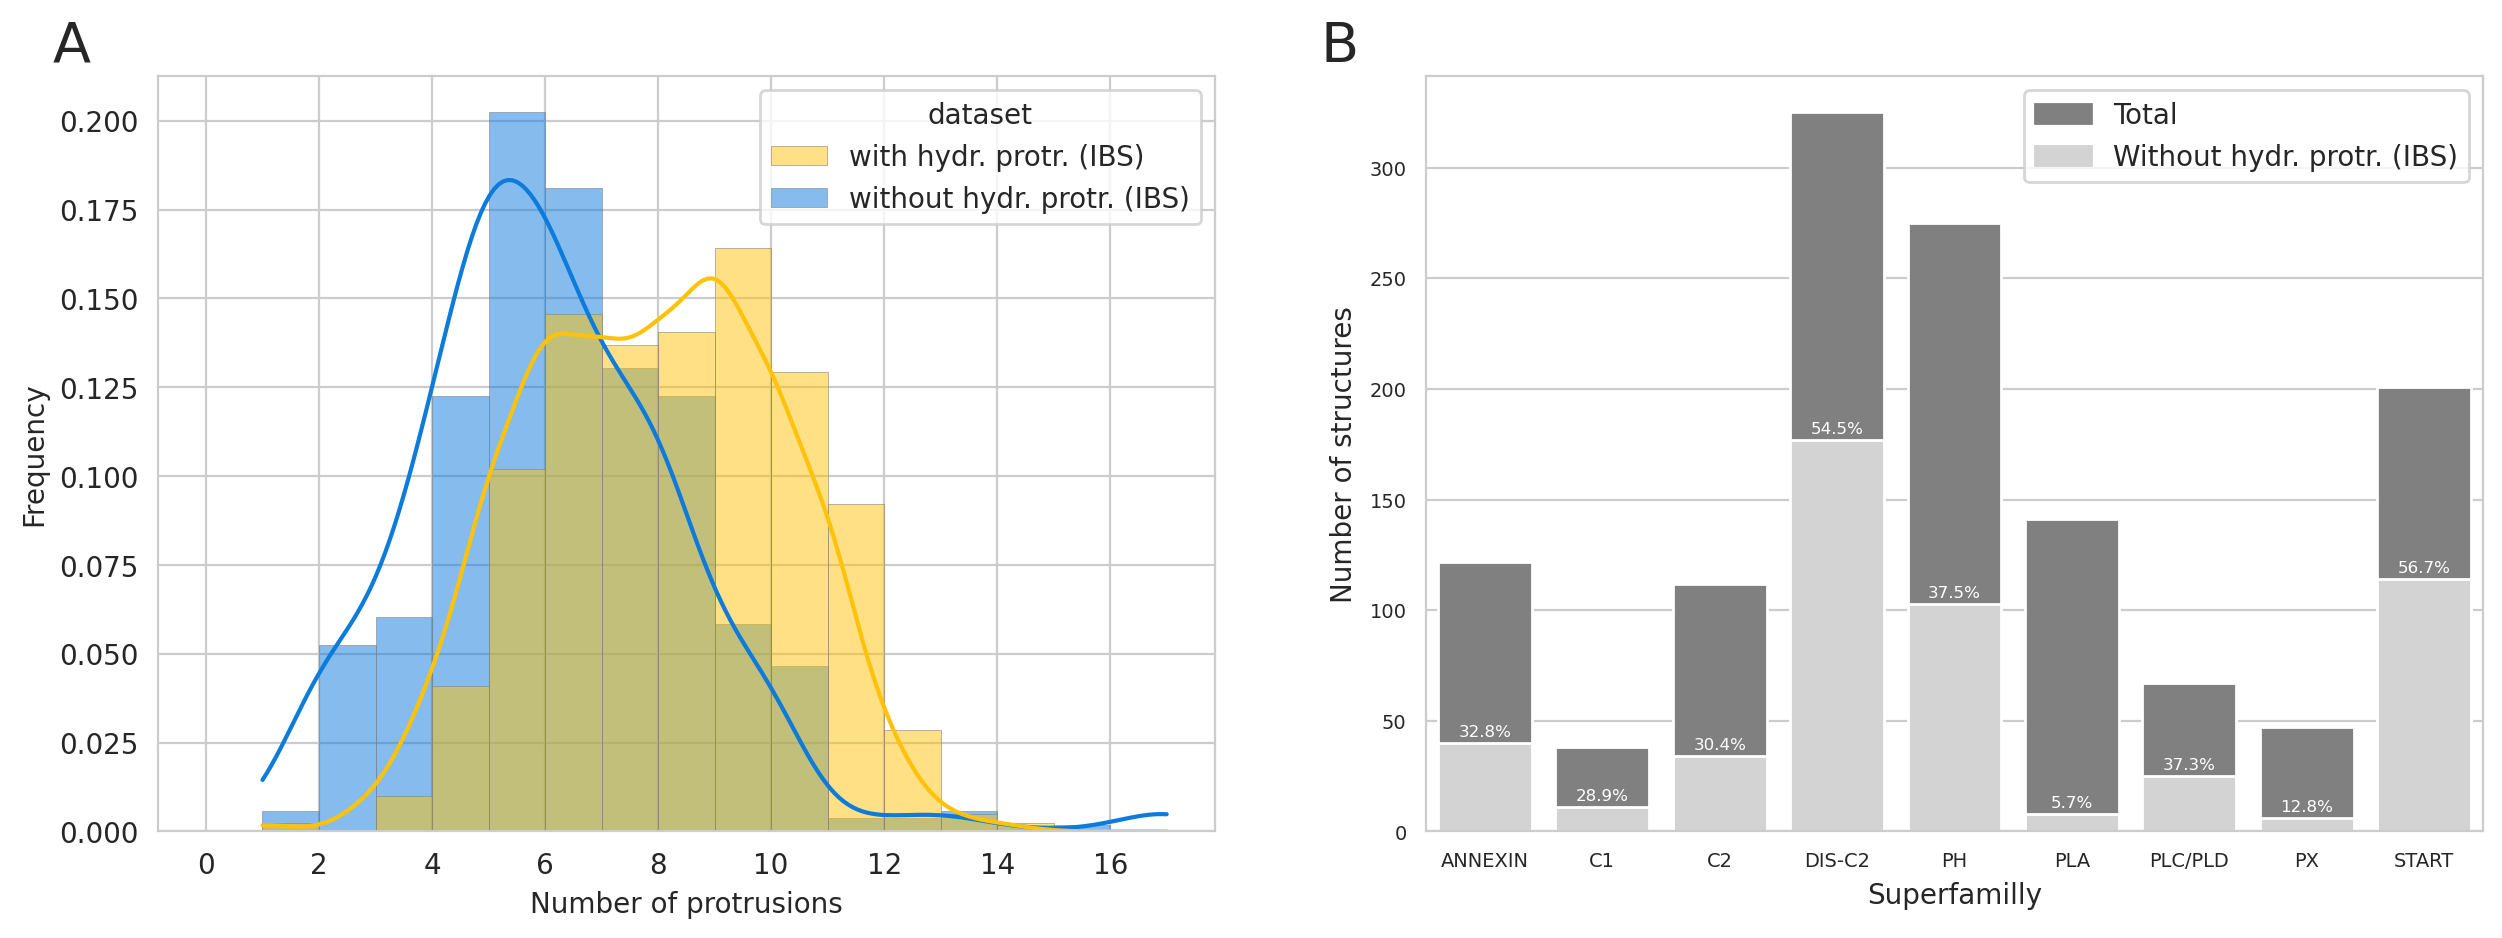

In [87]:
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1,1], height_ratios=[1])
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

sns.set_style("whitegrid",{'legend.frameon':True}) #Seaborn style
plt.rcParams["font.family"] = "DejaVu Sans" #Old = "DejaVu Sans" / "DejaVu Serif"


#Distribution two populations
count_protr_ibs_HPIBS["dataset"] = "with hydr. protr. (IBS)"
count_protr_ibs_noHPIBS["dataset"] = "without hydr. protr. (IBS)"
count_IBS = pd.concat([count_protr_ibs_HPIBS,
                       count_protr_ibs_noHPIBS,
                      ], axis=0)

max_x_IBS = math.ceil(count_IBS["count"].max())

graph_noHPIBS = sns.histplot(count_IBS, 
                         x="count",
                         hue="dataset",
                         stat="probability",
                         bins=list(range(0,max_x_IBS)),
                         #kind="kde",
                         alpha=0.5,
                         palette=["#FFC20A","#0C7BDC"],
                         edgecolor="gray", linewidth=0.2,
                         common_norm=False,
                         kde=True,
                         ax=ax0,
                         )

graph_noHPIBS.set(xlabel="Number of protrusions",
              ylabel="Frequency",
              #ylim=[0,575],
              #xlim=[0,48],f
             )

graph_noHPIBS.set_xticks(range(0,max_x_IBS,2))
# graph_noHPIBS.set_title("Number of protrusion in the IBS per dataset", fontsize=11)
sns.despine(left=False, bottom=False, top=False, right=False) #All 4 borders
###############################################################################
#                     Barplot
###############################################################################

order = ['C2DIS','PH','START','PLA','ANNEXIN','C2','PLD','PX','C1']
order.sort()
count_no_hydr = backup_prot_noHPIBS[["cathpdb","domain"]].drop_duplicates().domain.value_counts().to_frame().reset_index().rename(columns={"index":"domain","domain":"without hydrophobic protrusions"})

# count_no_hydr.set_index('domain')
number_of_structures = MERGED.domainDf[["cathpdb","domain"]].drop_duplicates().domain.value_counts()
#number_of_structures.name = 'Number of PDBS'
number_of_structures = number_of_structures.to_frame().reset_index().rename(columns={'domain':'Number of PDBS','index':'domain'})

count_no_hydr = count_no_hydr.merge(number_of_structures)

count_no_hydr["percentage"] = count_no_hydr["without hydrophobic protrusions"] / count_no_hydr["Number of PDBS"]

#count_no_hydr.sort_values(by="Number of PDBS", inplace=True, ascending=False)

print(count_no_hydr)


if includeAlfafold==True:
    count_no_hydr = count_no_hydr.set_index("domain")

    count_no_hydr = count_no_hydr.loc[order]
    count_no_hydr = count_no_hydr.reset_index()
    
count_no_hydr.domain = count_no_hydr.domain.astype(str)
import matplotlib.patches as mpatches

graphdata_nohydr = count_no_hydr.melt(value_vars=["without hydrophobic protrusions","Number of PDBS"],
                                      id_vars=["domain"],
                                      value_name="count",
                                      var_name="Observation")


bar1 = sns.barplot(x="domain",
                   y="count",
                   data=graphdata_nohydr.query("Observation == 'Number of PDBS'"),
                   color='gray', order=order,
                   ax=ax1) 

bar2 = sns.barplot(x="domain",
                   y="count",
                   data=graphdata_nohydr.query("Observation == 'without hydrophobic protrusions'"),
                   color='lightgray',
                   ci=None, order=order,
                   ax=ax1)


new_labels = [s.replace("C2DIS","DIS-C2") for s in order]
new_labels = [s.replace("PLD","PLC/PLD") for s in new_labels]
bar2.set_xticklabels(new_labels)

groupedvalues=graphdata_nohydr.groupby('domain').sum().reset_index()

#Adding barplot
count_no_hydr = count_no_hydr.reset_index(drop=True)
count_no_hydr = count_no_hydr.set_index("domain").loc[order].reset_index()
for index, row in count_no_hydr.iterrows():
    _ = bar2.text(row.name,
                  row["without hydrophobic protrusions"]+3,
                  f"{row['percentage']*100:.1f}%",
                  color="white",
                  ha="center",
                  size=6)

#Legend
top_bar = mpatches.Patch(color='gray', label='Total')
bottom_bar = mpatches.Patch(color='lightgray', label='Without hydr. protr. (IBS)')
_ = plt.legend(handles=[top_bar, bottom_bar])

_ = ax1.set(title ="",# "Number of structures per superfamilly",
            xlabel="Superfamilly", 
            ylabel="Number of structures", 
            ylim=None,
          )
_ = ax1.tick_params(labelsize=7)

_= ax0.text(-0.1,1.02, "A",transform=ax0.transAxes, fontsize=20)
_= ax1.text(-0.1,1.02, "B",transform=ax1.transAxes, fontsize=20)


save_fig(f"Fig 5{filesufix}", transparent=False, format=FORMAT)

### Raw values

In [27]:
count_no_hydr.query("domain not in ['C2DIS','START','ENTH','PLA','PX']").percentage.mean()

0.33371874962892695

In [28]:
count_no_hydr

,domain,without hydrophobic protrusions,Number of PDBS,percentage
0,ANNEXIN,40,122,0.327869
1,C1,11,38,0.289474
2,C2,34,112,0.303571
3,C2DIS,177,325,0.544615
4,PH,103,275,0.374545
5,PLA,8,141,0.056738
6,PLD,25,67,0.373134
7,PX,6,47,0.127660
8,START,114,201,0.567164


In [29]:
count_no_hydr.percentage.mean()

0.3294189416650071

### Statistical test (difference between the two subsets (HPIBS, noHPIBS))

In [30]:
pop1 = count_protr_ibs_HPIBS["count"]
pop2 = count_protr_ibs_noHPIBS["count"]
equality_test(pop1,pop2, "greater")

<span style='color:None'>**STATISTICAL TEST BETWEEN TWO SAMPLES**</span>

<span style='color:None'> - ALTERNATIVE HYPOTHESIS = greater</span>

<span style='color:None'>**NORMALITY TEST (shapiro)**</span>

<span style='color:None'>*The two samples should follow a normal law to use a standard t.test*</span>

<span style='color:red'>---- Sample 1 shapioro test pvalue = 5.10E-11, <= 0.05. This sample DO NOT follow a normal law</span>

<span style='color:red'>---- Sample 1 shapioro test pvalue = 2.34E-14, <= 0.05. This sample DO NOT follow a normal law</span>

<span style='color:None'>One or both sample(s) doesn't follow a normal law.</span>

<span style='color:None'>Performing a Wilcoxon Rank sum test with continuity correction</span>

<span style='color:None'>**WILCOXON RANK SUM TEST WITH CONTINUITY CORRECTION (or Mann-Whitney test)**</span>

<span style='color:None'>  Null hypothesis : the two distribution are equals</span>

<span style='color:None'>  Alternative hypothesis : pop1 > pop2</span>

<span style='color:red'>  pvalue = 6.88E-44 which is <= 0.05. The null hypothesis is rejected. The alternative hypothesis (fgreater) is valid and the two distrubition are different</span>

## Figure 6 - Composition of the IBS and the protrusion neighbourhood for proteins WITHOUT HP AT IBS

In [31]:
MERGED.domainDf = backup_prot_noHPIBS.copy()

tableCount_noHPIBS, oddratios_AA_noHPIBS_envir = MERGED.analysis.oddsratio_graph(among="protrusions", feature="residue_name", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCount_noHPIBS.reset_index(inplace=True)
tableCount_noHPIBS["Percentage"] = tableCount_noHPIBS.groupby(["IBS","residue_name"], as_index=False).apply(lambda x: x.Count/x.total*100).droplevel(0)
tableCount_noHPIBS["Surface"] = tableCount_noHPIBS["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
#tableCount_noHPIBS, oddratios_AA_noHPIBS_envir = MERGED.analysis.oddsratio_graph(among="protrusions", feature="residue_name", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCountSSE_noHPIBS, oddratios_SSE = MERGED.analysis.oddsratio_graph(among="is_hydrophobic_protrusion", feature="sec_struc", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCountSSE_noHPIBS.reset_index(inplace=True)
tableCountSSE_noHPIBS["Percentage"] = tableCountSSE_noHPIBS.groupby(["IBS","sec_struc"], as_index=False).apply(lambda x: x.Count/x.total*100).droplevel(0)
tableCountSSE_noHPIBS["Surface"] = tableCountSSE_noHPIBS["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
labelsdict = {"C":"Loop", "E":"β-strand","H":"α-helix"}
tableCountSSE_noHPIBS["Secondary Structure"] = tableCountSSE_noHPIBS["sec_struc"].apply(lambda x: labelsdict[x])
oddratios_SSE.insert(0, "Secondary Structure", oddratios_SSE["sec_struc"].apply(lambda x: labelsdict[x]))
MERGED.domainDf = backup_all.copy()

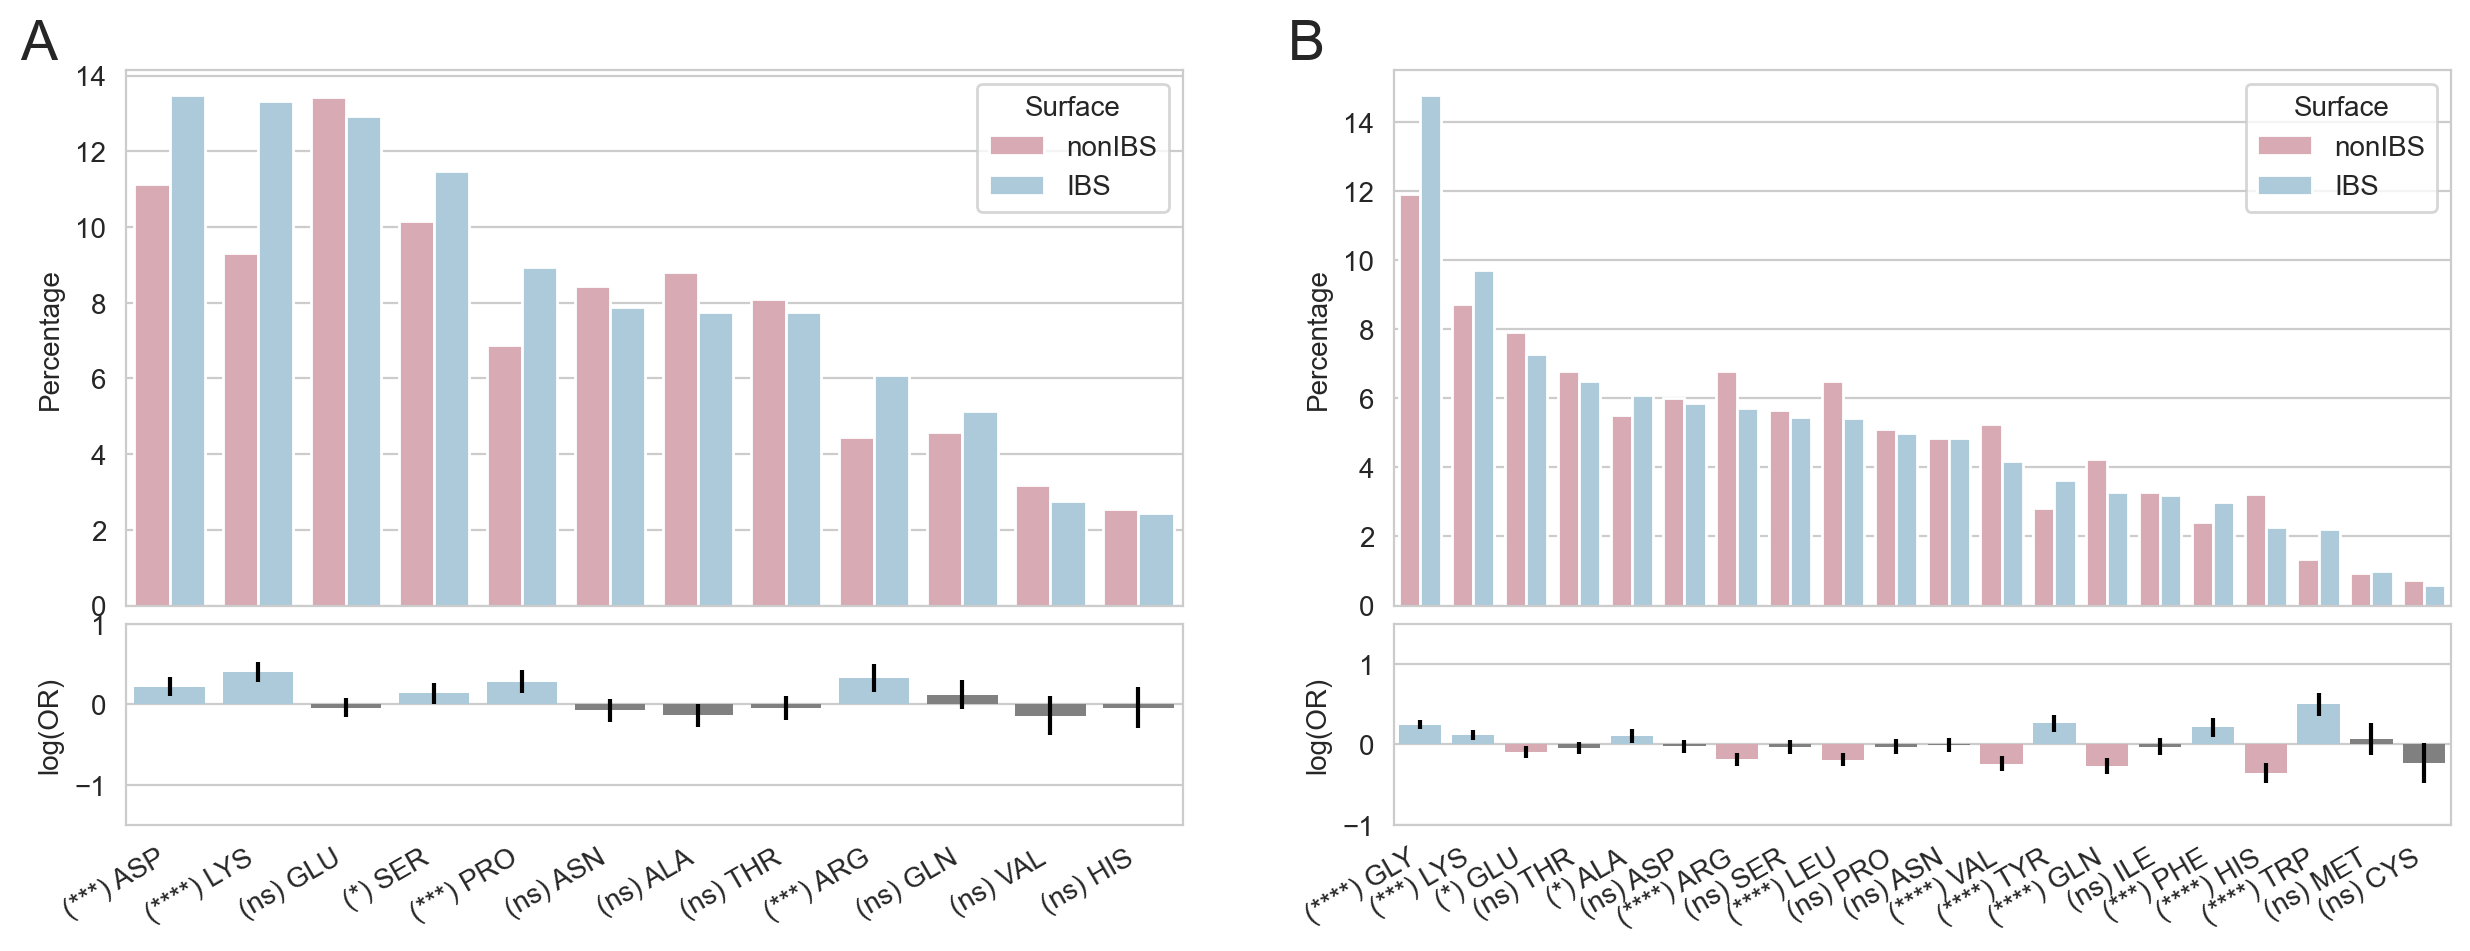

In [32]:
MERGED.domainDf = backup_prot_noHPIBS.copy()
sns.set_style("whitegrid") #Seaborn style

fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=[1,1], height_ratios=[8,3])
gs.update(hspace=0.05)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])

#1. Protrusions compositions
#1.1 AA composition

tc_resname_protrusions = MERGED.domainDf.query("protrusion == True").groupby("IBS")["residue_name"].value_counts(normalize=True).to_frame('Percentage').reset_index()
tc_resname_protrusions["Surface"] = tc_resname_protrusions["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
tc_resname_protrusions["Percentage"] = tc_resname_protrusions["Percentage"]*100
residue_name_order = tc_resname_protrusions.query("Surface == 'IBS'").sort_values("Percentage", ascending=False).residue_name
graph_protrusions = sns.barplot(data=tc_resname_protrusions,
                    x="residue_name",
                    y="Percentage",
                    hue="Surface",
                    palette=palette_IBS,  
                    ax=ax0,
                   order = residue_name_order)
_= graph_protrusions.set(title="", #Protrusion composition", 
              xlabel="",
             xticklabels=[],
                        )

#2. OR values
oddratios_AA_protrusions = MERGED.analysis.oddsratio_graph(among="protrusions", feature="residue_name", axs=ax1,title="Log(OR) per amino acid",return_dataset=True)
#Reorder the oddratio dataframe according the residue_name_order
oddratios_AA_protrusions = oddratios_AA_protrusions.set_index("residue_name").loc[residue_name_order].reset_index()
palette = get_palette_OR(oddratios_AA_protrusions)
graphOR2 = sns.barplot(data=oddratios_AA_protrusions, x="residue_name",y="oddsratio", orient="v", palette=palette, linewidth=0, yerr=oddratios_AA_protrusions["err"], ax=ax2)
_= graphOR2.set(ylabel="log(OR)",
                xlabel="",
                ylim=(-1.5,1),
               )
_= graphOR2.set_xticklabels(graphOR2.get_xticklabels(),rotation=30, size=10)
oddratios_AA_protrusions = significance(oddratios_AA_protrusions)
_= graphOR2.set_xticklabels(oddratios_AA_protrusions["labels"], horizontalalignment="right",rotation=30, size=10)

#2.1Environment protrusions
##2.1 Calculating data
# ( Made in previous cell)
                         
#2.2 Graph
tc_resname_envir = tableCount_noHPIBS
residue_name_order = tc_resname_envir.query("Surface == 'IBS'").sort_values("Percentage", ascending=False).residue_name
graph2 = sns.barplot(data=tc_resname_envir,
                    x="residue_name",
                    y="Percentage",
                    hue="Surface",
                    palette=palette_IBS,  
                    ax=ax1,
                   order = residue_name_order,
                    )


_= graph2.set(title="", #Protrusion environment composition", 
              xlabel="",
             xticklabels=[]
             )

                         
oddratios_AA_noHPIBS_envir = oddratios_AA_noHPIBS_envir.set_index("residue_name").loc[residue_name_order].reset_index()
palette = get_palette_OR(oddratios_AA_noHPIBS_envir)
graphOR2 = sns.barplot(data=oddratios_AA_noHPIBS_envir, x="residue_name",y="oddsratio", orient="v", palette=palette, linewidth=0, yerr=oddratios_AA_noHPIBS_envir["err"], ax=ax3)
_= graphOR2.set(ylabel="log(OR)",
                xlabel="",
                ylim=(-1,1.5),
               )


_= graphOR2.set_xticklabels(graphOR2.get_xticklabels(),rotation=30, size=10)
oddratios_AA_noHPIBS_envir = significance(oddratios_AA_noHPIBS_envir)
_= graphOR2.set_xticklabels(oddratios_AA_noHPIBS_envir["labels"], horizontalalignment="right",rotation=30, size=10)


#Adding labels
#_= ax0.text(0.6,1.15, "Protrusions composition (protein without HP at IBS)",transform=ax0.transAxes, fontsize=20)
_= ax0.text(-0.1, 1.02, "A", transform=ax0.transAxes, fontsize=20)
_= ax1.text(-0.1, 1.02, "B", transform=ax1.transAxes, fontsize=20)
# _= ax2.text(-0.1,0.8, "C",transform=ax2.transAxes, fontsize=20)
# _= ax3.text(-0.1,0.8, "D",transform=ax3.transAxes, fontsize=20)

save_fig(f"Fig 6{filesufix}", transparent=False, format=FORMAT)
MERGED.domainDf = backup_all.copy()

---
## Preparation of AlphaFold data insertion

In [11]:
MERGEDAF = Dataset(pd.read_pickle(f"{WORKDIR}/DATASET_peprmint_d25.pkl"),
                      PEPRMINT_FOLDER)
MERGEDAF.load_dataset(f"MERGED_cath-AF")
MERGEDAF.domainDf["type"] = MERGEDAF.domainDf.residue_name.apply(lambda x: AATYPE[x])
#MERGEDAF.domainDf[["type","residue_name"]].drop_duplicates()
MERGEDAF.domainDf.residue_name = MERGEDAF.domainDf.residue_name.astype(str)
MERGEDAF.domainDf.domain = MERGEDAF.domainDf.domain.astype(str)
MERGEDAF.domainDf = MERGEDAF.domainDf.replace("C2DIS",'C2DIS')

backup_all_AF = MERGEDAF.domainDf.copy()

## QUICK FIX, REMOVE ENTH
## REMOVE ENTH
MERGEDAF.domainDf = MERGEDAF.domainDf.query("domain != 'ENTH'")
# -----------------------------------------------------------------
def count_hydr_protr_perpdb(group):
    g = group.query("protrusion == True and atom_name == 'CB' and type.str.contains('Hydrophobic')", engine="python")
    return (len(g))
    
l = MERGEDAF.domainDf.query('IBS == True and atom_name == "CB"').groupby("cathpdb").progress_apply(lambda group: count_hydr_protr_perpdb(group))
nohydrprotrpdbs_AF = list(l[l==0].index)
backup_prot_HPIBS_AF = MERGEDAF.domainDf.query("cathpdb not in @nohydrprotrpdbs_AF")
backup_prot_noHPIBS_AF = MERGEDAF.domainDf.query("cathpdb in @nohydrprotrpdbs_AF")
# backup_all_AF = MERGEDAF.domainDf.copy()


## Figure 7 - Increasing our dataset size by integrating Alphafold2 models.

In [12]:
N_HPIBS = len(backup_prot_HPIBS_AF.cathpdb.unique())
N_noHPIBS = len(backup_prot_noHPIBS_AF.cathpdb.unique())
print(f"Percentage of AF2+CATH subset without HP At the IBS = {N_noHPIBS/(N_noHPIBS+N_HPIBS)*100:.2f}")

Percentage of AF2+CATH subset without HP At the IBS = 29.51


In [13]:
N_HPIBS = len(backup_prot_HPIBS_AF.query("data_type == 'alfafold'").cathpdb.unique())
N_noHPIBS = len(backup_prot_noHPIBS_AF.query("data_type == 'alfafold'").cathpdb.unique())
print(f"Percentage of AF2 subset without HP At the IBS = {N_noHPIBS/(N_noHPIBS+N_HPIBS)*100:.2f}")

Percentage of AF2 subset without HP At the IBS = 20.47


In [14]:
EXCLUDE_AF_FOR_DOMAIN = ["C1","PLA","PLD"]
idxtoremove = MERGEDAF.domainDf.query("(domain in @EXCLUDE_AF_FOR_DOMAIN and data_type == 'alfafold')").index
MERGEDAF.domainDf = MERGEDAF.domainDf[~MERGEDAF.domainDf.index.isin(idxtoremove)]
backup_prot_HPIBS_AF = MERGEDAF.domainDf.query("cathpdb not in @nohydrprotrpdbs_AF")
backup_prot_noHPIBS_AF = MERGEDAF.domainDf.query("cathpdb in @nohydrprotrpdbs_AF")
backup_all_AF = MERGEDAF.domainDf.copy()

In [15]:
N = len(MERGEDAF.domainDf.query("data_type == 'alfafold'").cathpdb.unique())
print(f"Number of structure alphafold = {N}")

N = len(MERGEDAF.domainDf.query("data_type == 'cathpdb'").cathpdb.unique())
print(f"Number of structure CATH = {N}")

Number of structure alphafold = 1194
Number of structure CATH = 1328


                   Percentage              range
90 < pLDTT <= 100   58.118198  90 < pLDTT <= 100
70 < pLDTT <= 90    32.301261   70 < pLDTT <= 90
50 < pLDTT <= 70     6.652252   50 < pLDTT <= 70
pLDTT <= 50          2.928288        pLDTT <= 50


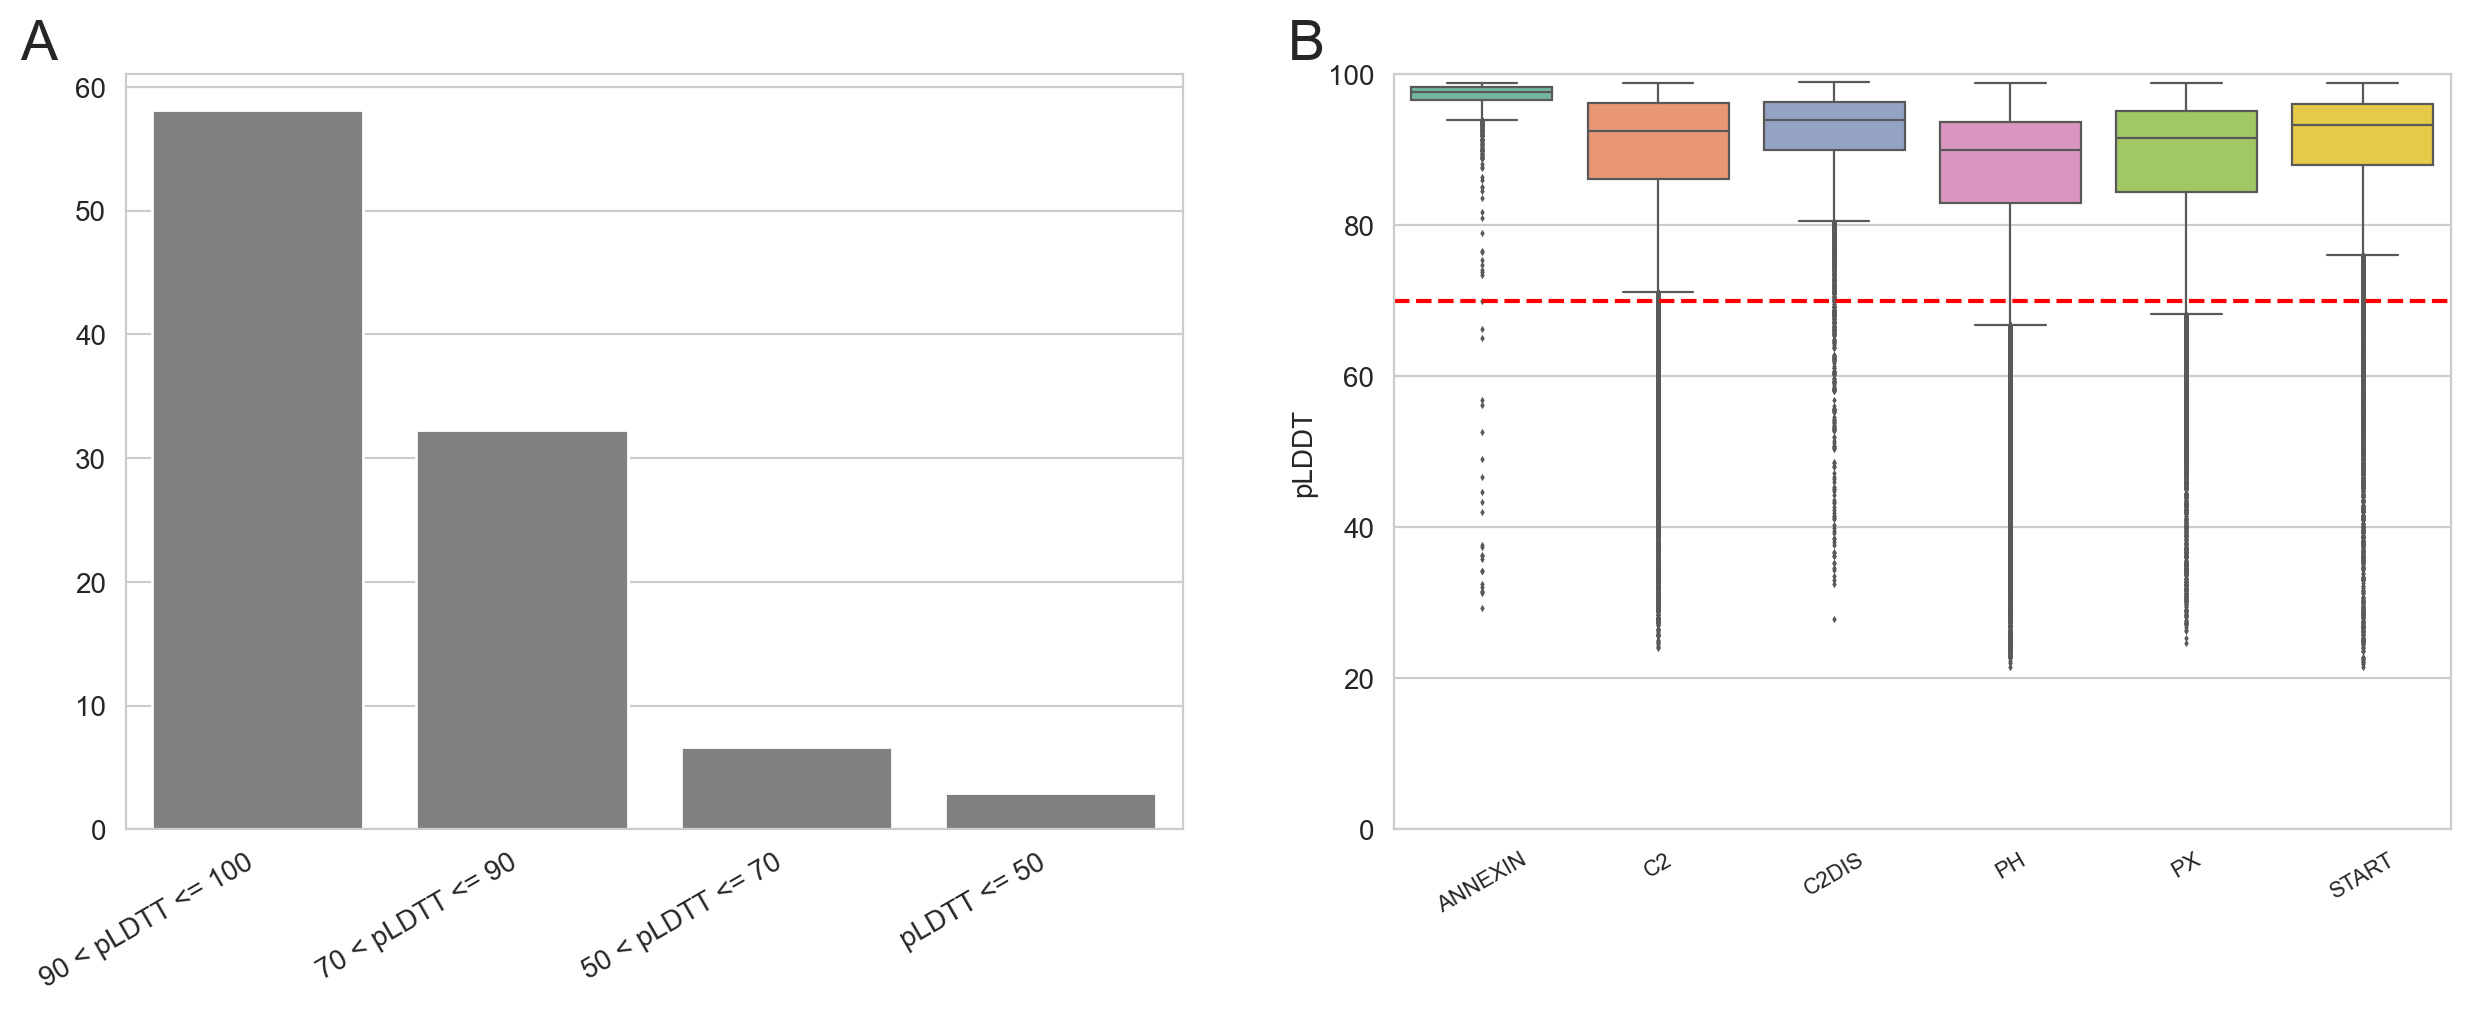

In [38]:
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1,1], height_ratios=[1])
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])


### GRAPH 1
nRes = len(MERGEDAF.domainDf.query("data_type == 'alfafold' and atom_name == 'CA'"))
r_under_50 = len(MERGEDAF.domainDf.query("data_type == 'alfafold' and atom_name == 'CA' and b_factor <= 50"))/nRes*100
r_50_70 = len(MERGEDAF.domainDf.query("data_type == 'alfafold' and atom_name == 'CA' and 50 < b_factor <= 70"))/nRes*100
r_70_90 = len(MERGEDAF.domainDf.query("data_type == 'alfafold' and atom_name == 'CA' and 70 < b_factor <= 90"))/nRes*100
r_90_100 = len(MERGEDAF.domainDf.query("data_type == 'alfafold' and atom_name == 'CA' and 90 < b_factor <= 100"))/nRes*100

labels=['90 < pLDTT <= 100','70 < pLDTT <= 90','50 < pLDTT <= 70','pLDTT <= 50']
pLDDT = pd.DataFrame([r_90_100,r_70_90,r_50_70,r_under_50],
            columns=["Percentage"],
            index=labels,
            )
pLDDT["range"] = labels
print(pLDDT)
graph_pLDDT = sns.barplot(y="Percentage",
                          x="range",
                         data=pLDDT,
                          color='gray',
                          ax=ax0,
                         )

_= graph_pLDDT.set_xticklabels(labels,rotation=30, size=10, horizontalalignment='right')
_ = graph_pLDDT.set(title="",#"Distribution of the pLDDT per residue",
                ylabel="",
                xlabel="",
               )


### GRAPH2
order = MERGEDAF.domainDf.query("data_type == 'alfafold'").domain.unique()
order.sort()
graph = sns.boxplot(x="domain",
              y='b_factor',
              data=MERGEDAF.domainDf.query("data_type == 'alfafold' and atom_name == 'CA'"),
               linewidth=0.8,
               fliersize=0.5,
                    palette=sns.color_palette("Set2"),
                    order=order,
                    ax=ax1,
            )

_ = graph.set(title='',#'pLDDT distribution per superfamilies',
         ylabel='pLDDT',
         xlabel='',
         ylim=[0,100],
             )

_ = graph.axes.axhline(70, ls='--', color='r')
_ = graph.set_xticklabels(graph.get_xticklabels(),rotation=30, size=8)

_= ax0.text(-0.1,1.02, "A",transform=ax0.transAxes, fontsize=20)
_= ax1.text(-0.1,1.02, "B",transform=ax1.transAxes, fontsize=20)

save_fig("Fig 7", transparent=False, format=FORMAT)

## Figure 8 - Superfamily decomposition of Exposed environment of hydrophobic protrusions at the IBS 

In [79]:
def make_ibs_perdomain_graph(data,MERGED, PERTYPE,nrow,title,outputname, ax=None, legend=True,showstat=None, return_data=False, envir=False, alldom=True, legend_loc='center', among="protrusions", subset="IBS", savedata=None):
    sns.set_style("whitegrid") #Seaborn style
    plt.rcParams["font.family"] = "DejaVu Sans" #Old = "DejaVu Sans" / "DejaVu Serif"



    domlist=[
            "C2DIS",
            "START",
             "PH",
             "ANNEXIN",
            #  "ENTH",
             "C2",
             "PLD",
             "C1",
             "PLA",
             "PX"
            ]
    domlist.sort()

    # Fetch the dataset
    if subset == "IBS":
        dfibs = data.query("IBS == True and exposed == True and domain in @domlist")
    if subset == "protrusion":
        dfibs = data.query("IBS == True and protrusion == True and domain in @domlist")
    dfibs.residue_name = dfibs.residue_name.astype(str)

    #Set colors
    graph_res_data = dfibs.residue_name.value_counts(normalize=True).to_frame()*100
    colors_per_type = {x:colorsPerType[AATYPE[x]] for x in list(graph_res_data.index)}
    colors_per_type_and_aa = {x:COLORS_taylor[x] for x in list(COLORS_taylor.keys())}


    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 5))
    
        

    if envir==False:
        graph_res_data = dfibs.groupby("domain").residue_name.value_counts(normalize=True).to_frame("Percentage")*100
    else:
        backup = MERGED.domainDf.copy()
        MERGED.domainDf = data
        graph_res_data = MERGED.analysis.oddsratio_graph(among=among, feature="residue_name", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True, envirPerDomain=True)

    #Set Domains order
    if alldom == True:
        order_domains=["ANNEXIN",'PH','C2','PX','PLA','START','PLD','C2DIS','C1']
        # order_domains=["ENTH", "ANNEXIN",'PH','C2','PX','PLA','START','PLD','C2DIS','C1']
        order_domains.sort()

    else:
        order_domains=["C2DIS","PH",'START']
    

    graph_res_data.reset_index(inplace=True)
    graph_res_data["type"] = graph_res_data["residue_name"].apply(lambda x: AATYPE[x])
    graph_res_data = graph_res_data.set_index(["domain","type"])
    graph_res_data["Percentage_Type"] = graph_res_data.groupby(["domain","type"]).Percentage.sum()
    graph_res_data.reset_index(inplace=True)




    if PERTYPE:
        order_legend=["Positive",
                      "Negative",
                      "Polar",
                      "Non-polar",
                      "Hydrophobic,H-aromatic",
                      "Hydrophobic,H-non-aromatic",
                     ]
        color_palette=colorsPerType
        hue="type"
        weights="Percentage_Type"
        graph_res_data=graph_res_data.drop_duplicates(["domain","type","Percentage_Type"])
        outputname+="_pertype"
    else:
        order_legend=["LYS","ARG",
                      "ASP","GLU",
                      "HIS","ASN","GLN","THR","SER",
                      "PRO","ALA","VAL","GLY",
                       "TYR","TRP","PHE",
                       "LEU","ILE","CYS","MET",
                     ]

        color_palette = colors_per_type_and_aa
        hue='residue_name'
        weights='Percentage'
        outputname+="_perres"



    #Remove what's not in the dataset
    Labels = graph_res_data[hue].unique()
    order_legend = [x for x in order_legend if x in Labels]
    color_palette =  { key: color_palette[key] for key in Labels}

#     print(graph_res_data)
    graph_res_data=graph_res_data.set_index("domain").loc[order_domains].reset_index()

    graph_res = sns.histplot(graph_res_data, 
                             y='domain',
                             hue=hue,
                             weights=weights,
                             multiple='stack',
    #                          palette='tab20c_r',
                             shrink=0.8,
    #                          alpha=1,
                             ax=ax,
                              hue_order=order_legend[::-1],
                             edgecolor='k', linewidth=0.1,
                              palette=color_palette,
                             legend=legend,
                            )

    domains_in_graph = list(graph_res_data.domain.unique())
    new_labels = [s.replace("C2DIS","DIS-C2") for s in order_domains]
    new_labels = [s.replace("PLD","PLC/PLD") for s in new_labels]
    graph_res.set_yticklabels(new_labels)

    if PERTYPE:
        for rec, label in zip(graph_res.patches,graph_res_data['Percentage_Type'].round(1).astype(str)):
            height = rec.get_height()
            width = rec.get_width()
            val = f"{rec.get_width():.1f} "
            size=8
#             if PERTYPE:
#                 size = 8
#             else:
#                 size = 4
            ax.text((rec.xy[0]+rec.get_width()/2), (rec.xy[1]+rec.get_height()/2), val, size=size, color="#383838",
                    ha = 'center', va='center',
                   )

    if savedata != None:
        graph_res_data.to_excel(f"{FIGURESFOLDER}article/{savedata}.xlsx")


    #From https://github.com/mwaskom/seaborn/issues/2280#issuecomment-692350136
    def move_legend(ax, new_loc, title=None, invert=True, order=None, **kws):
        old_legend = ax.legend_
        handles = old_legend.legendHandles
        labels = [t.get_text() for t in old_legend.get_texts()]

        labels_handles = dict(zip(labels,handles))

        if invert:
            handles=handles[::-1]
            labels=labels[::-1]
        if title == None:
            title = old_legend.get_title().get_text()

        if order:
            handles = [labels_handles[x] for x in order]
            labels = order

        ax.legend(handles, labels, loc=new_loc, title=title, **kws)


    if legend:
        move_legend(graph_res, 
                    legend_loc, 
                    title="",
                    order=order_legend,
                    ncol=math.ceil(len(Labels)/nrow), 
                    bbox_to_anchor=(0.5,-0.23))



    _ = graph_res.set(title=title, 
                      xlabel="Percentage", 
                      ylabel="",
                      xlim=(-1,101),
                     )

    #Add Groups
#     import matplotlib.patches as patches
#     rect1 = patches.Rectangle((-0.5, -0.5), 101, 2.95, linewidth=0.5, edgecolor='k', facecolor='none', linestyle="-")
#     rect2 = patches.Rectangle((-0.5, 2.55), 101, 3.9, linewidth=0.5, edgecolor='k', facecolor='none', linestyle="-")
#     rect3 = patches.Rectangle((-0.5, 6.55), 101, 2.9, linewidth=0.5, edgecolor='k', facecolor='none', linestyle="-")
#     _ = ax.add_patch(rect1)
#     _ = ax.add_patch(rect2)
#     _ = ax.add_patch(rect3)

    if envir == True:
        MERGED.domainDf = backup.copy()

    if showstat:
        if type(showstat) != type([]):
            showstat = [showstat]
        for typequery in showstat:
            print(typequery)
            print(graph_res_data.query("type == @typequery").describe())
            print(graph_res_data.query("type == @typequery").describe())

    if return_data:
        plt.close()
        return(graph_res_data)

    if ax==None:
        save_fig(outputname)
    else:
        return graph_res


In [54]:
index_bellow_50 = backup_prot_HPIBS_AF.query("data_type == 'alfafold' and b_factor <= 50").index
all_index = backup_prot_HPIBS_AF.index
index_over_50 = list(set(index_bellow_50) ^ set(all_index))



(<Figure size 2800x1000 with 1 Axes>, <AxesSubplot:>)

                             type residue_name
12                          Polar          ASN
2386                        Polar          SER
6803                    Non-polar          VAL
10752                    Negative          ASP
14040  Hydrophobic,H-non-aromatic          LEU
20193                       Polar          THR
23200                   Non-polar          GLY
25083      Hydrophobic,H-aromatic          PHE
27963                   Non-polar          PRO
30543                    Positive          LYS
35347  Hydrophobic,H-non-aromatic          ILE
38988                       Polar          GLN
41766                    Positive          ARG
45385                       Polar          HIS
46888  Hydrophobic,H-non-aromatic          MET
47796      Hydrophobic,H-aromatic          TYR
50131      Hydrophobic,H-aromatic          TRP
51421                   Non-polar          ALA
55221                    Negative          GLU
59785  Hydrophobic,H-non-aromatic          CYS


/Users/thibault/miniconda3/envs/peprmint/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/thibault/miniconda3/envs/peprmint/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator


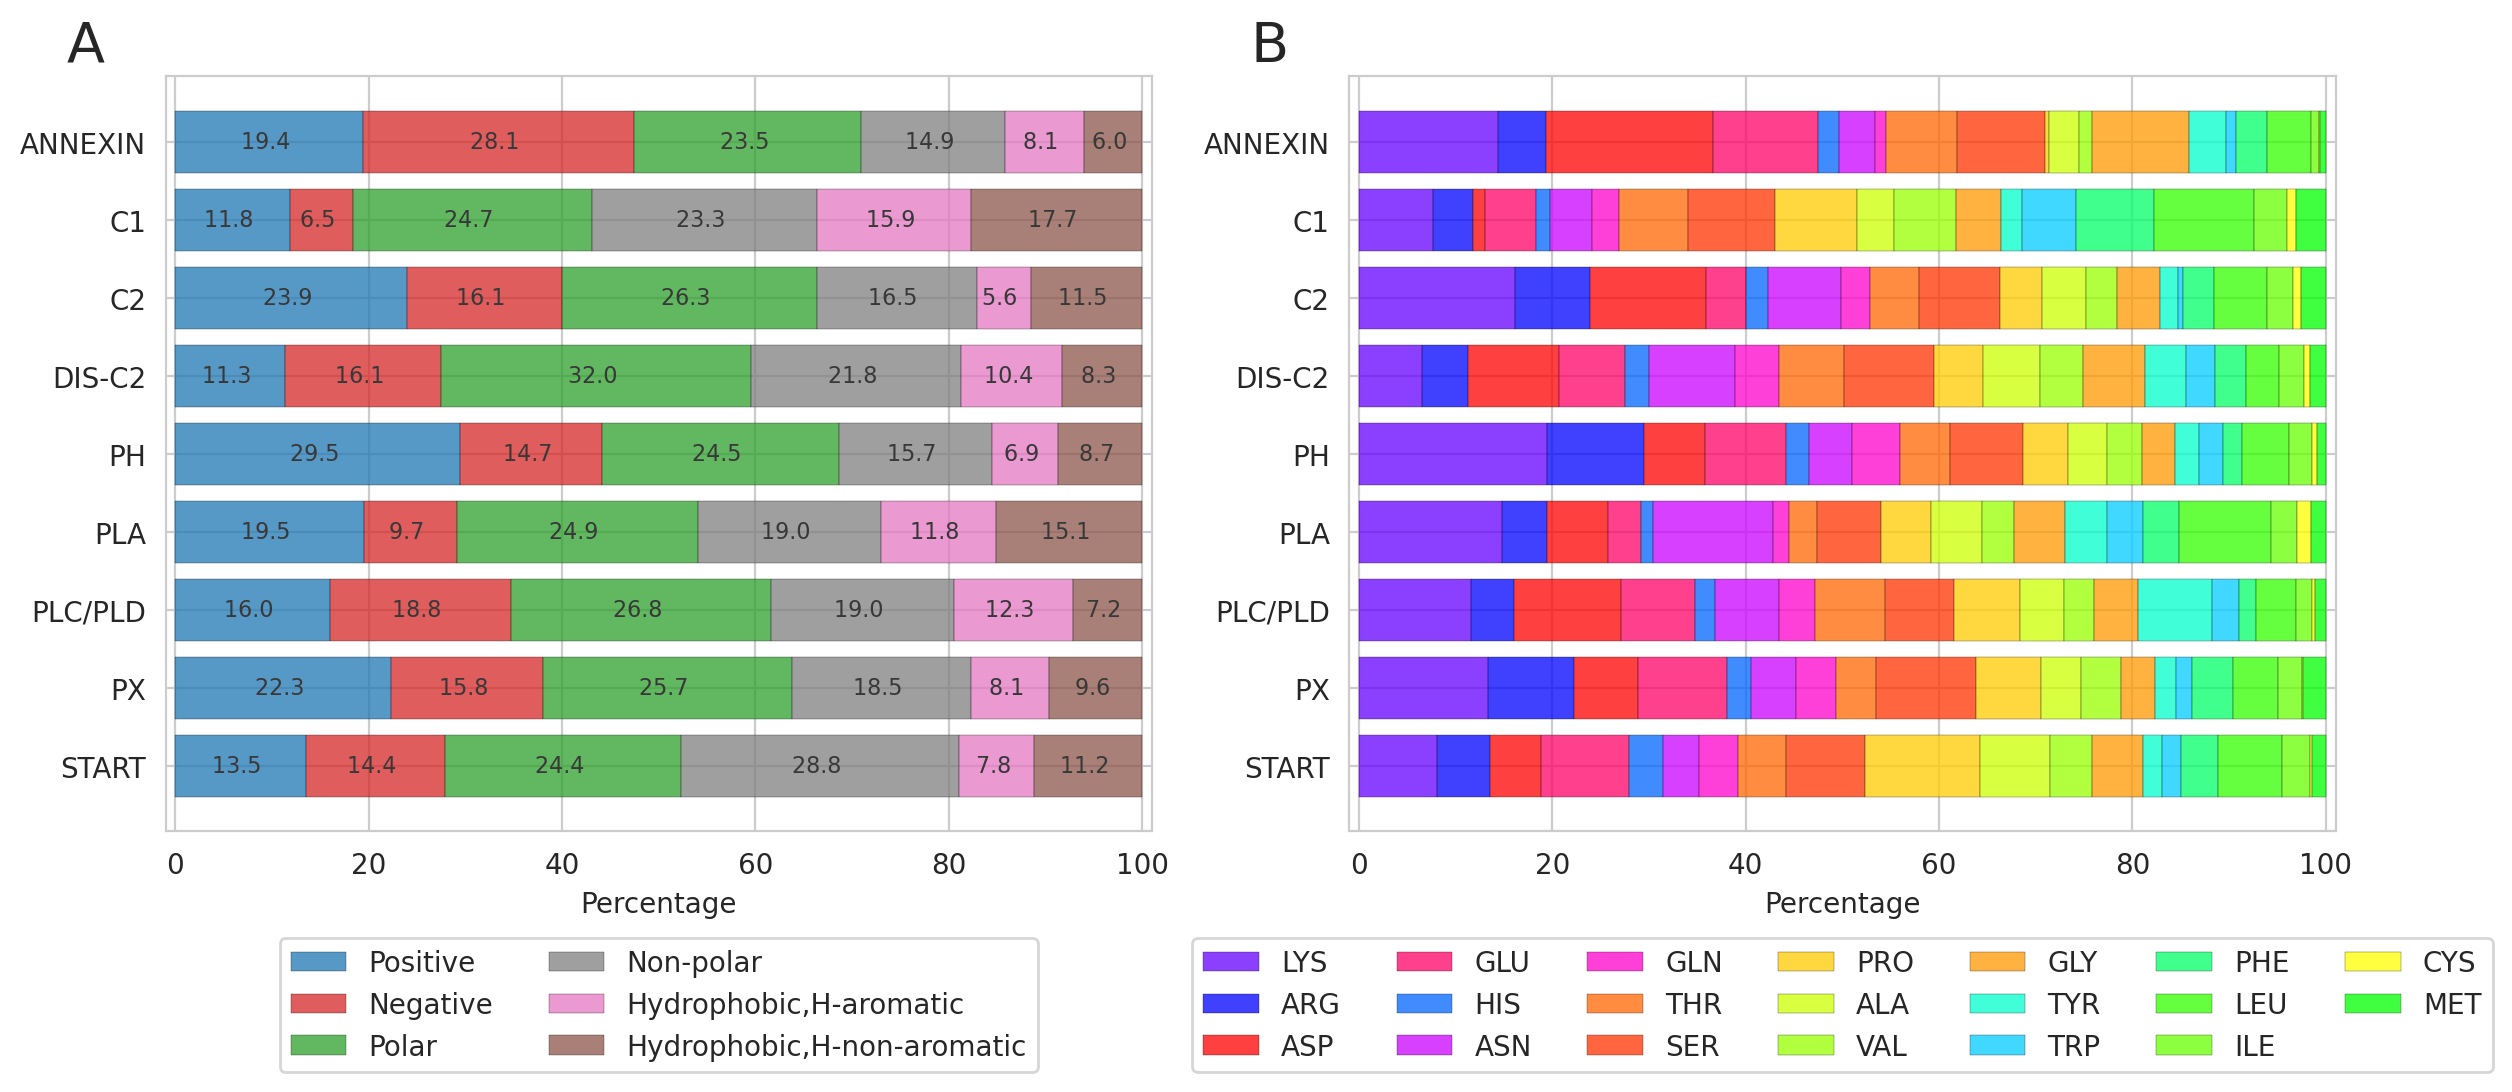

In [80]:
plt.subplots(figsize=(14, 5))

gs = gridspec.GridSpec(ncols=2, nrows=1)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

backup_prot_HPIBS_AF["type"] = backup_prot_HPIBS_AF.residue_name.apply(lambda x: AATYPE[x])
print(backup_prot_HPIBS_AF[["type","residue_name"]].drop_duplicates())

graph_superfamilies_type = make_ibs_perdomain_graph(data=backup_all_AF.query("(data_type == 'cathpdb') or (data_type == 'alfafold' and b_factor >= 70)"),
                         MERGED=MERGEDAF,
                         PERTYPE=True,
                         nrow=3,
                         title="",#Hydrophobic protrusions exposed environment at the IBS",
                          outputname="IBS_protrusions_composition_HYDRO_perdomain2",
                         ax=ax0,
                         legend=True,
                              envir=False,
                         alldom=True,
                         subset="IBS",
#                               showstat=["Negative","Positive", "Polar","Non-polar", "Hydrophobic,H-aromatic","Hydrophobic,H-non-aromatic"],
                        )


graph_superfamilies_aa = make_ibs_perdomain_graph(data=backup_all_AF.query("(data_type == 'cathpdb') or (data_type == 'alfafold' and b_factor >= 70)"),
                         MERGED=MERGEDAF,
                         PERTYPE=False,
                         nrow=3,
                         title="",#Hydrophobic protrusions exposed environment at the IBS",
                          outputname="IBS_protrusions_composition_HYDRO_perdomain2",
                         ax=ax1,
                         legend=True,
                              envir=False,
                         alldom=True,
                         subset="IBS",
                         savedata="Fib9B_data"
#                               showstat=["Negative","Positive", "Polar","Non-polar", "Hydrophobic,H-aromatic","Hydrophobic,H-non-aromatic"],
                        )

_= ax0.text(-0.1,1.02, "A",transform=ax0.transAxes, fontsize=20)
_= ax1.text(-0.1,1.02, "B",transform=ax1.transAxes, fontsize=20)

save_fig(f"Fig 9", transparent=False, format=FORMAT)

In [71]:
order_domains=["ANNEXIN",'PH','C2','PX','PLA','START','PLD','C2DIS','C1']
[s.replace("C2DIS","DISC2") for s in order_domains]

['ANNEXIN', 'PH', 'C2', 'PX', 'PLA', 'START', 'PLD', 'DISC2', 'C1']

## New figure 1

(<Figure size 2800x800 with 1 Axes>, <AxesSubplot:>)

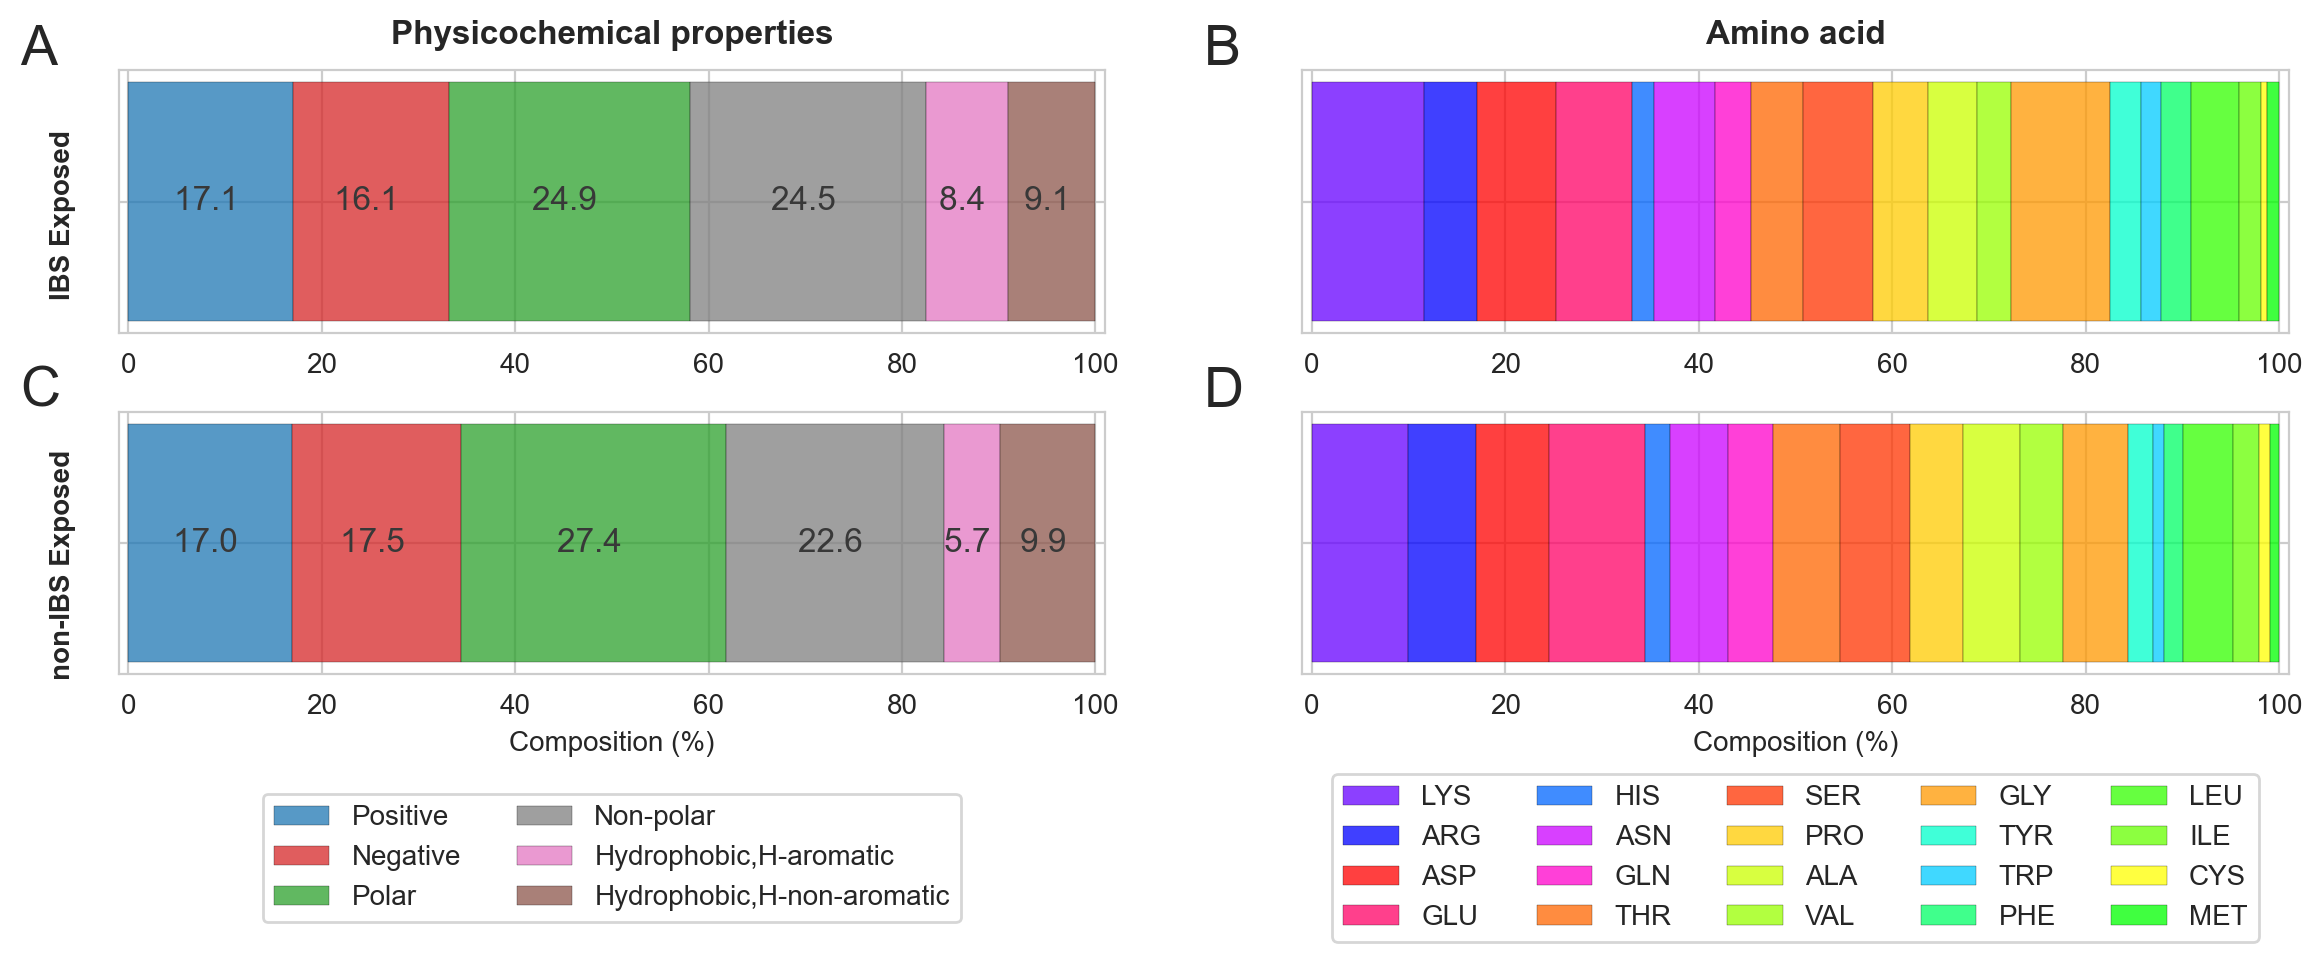

In [9]:
def composition_of_exposed_IBS(data, ax=None, PERTYPE=False, putLegend=True, xlabel="Composition (%)"):
    graph_data = data.to_frame()
    if PERTYPE:
        order_legend=["Positive",
                      "Negative",
                      "Polar",
                      "Non-polar",
                      "Hydrophobic,H-aromatic",
                      "Hydrophobic,H-non-aromatic",
                     ]
        color_palette=colorsPerType
        hue="type"
        weights="Percentage_Type"
        # graph_res_data=graph_res_data.drop_duplicates(["domain","type","Percentage_Type"])
    else:
        order_legend=["LYS","ARG",
                      "ASP","GLU",
                      "HIS","ASN","GLN","THR","SER",
                      "PRO","ALA","VAL","GLY",
                       "TYR","TRP","PHE",
                       "LEU","ILE","CYS","MET",
                     ]
        color_palette = {x:COLORS_taylor[x] for x in list(COLORS_taylor.keys())}
        hue='residue_name'
        weights='Percentage'

    
    graph_data.reset_index(inplace=True)
    graph_data.columns = ["residue_name","Percentage"]

    graph_data["type"] = graph_data["residue_name"].apply(lambda x: AATYPE[x])

    graph_data = graph_data.set_index(["type"])
    graph_data["Percentage_Type"] = graph_data.groupby("type").Percentage.sum()
    graph_data.reset_index(inplace=True)

    graph_data["data"] = "data"

    if PERTYPE:
        graph_data = graph_data.drop_duplicates("type")
    graph = sns.histplot(graph_data,
                         y="data",
                         hue=hue,
                         weights=weights,
                         multiple='stack',
                         hue_order=order_legend[::-1],
                         edgecolor='k',
                         linewidth=0.1,
                         palette=color_palette,
                         legend=putLegend,
                         ax=ax)
    graph.set(ylabel="", xlabel=xlabel)
    graph.set_yticklabels("")
    graph.set(xlim=[-1,101])

    if PERTYPE:
        for rec, label in zip(graph.patches,graph_data['Percentage_Type'].round(1).astype(str)):
                    height = rec.get_height()
                    width = rec.get_width()
                    val = f"{rec.get_width():.1f} "
                    size=12
        #             if PERTYPE:
        #                 size = 8
        #             else:
        #                 size = 4
                    ax.text((rec.xy[0]+rec.get_width()/2), (rec.xy[1]+rec.get_height()/2), val, size=size, color="#383838",
                            ha = 'center', va='center',
                        )

    #From https://github.com/mwaskom/seaborn/issues/2280#issuecomment-692350136
    def move_legend(ax, new_loc, title=None, invert=True, order=None, **kws):
            old_legend = ax.legend_
            handles = old_legend.legendHandles
            labels = [t.get_text() for t in old_legend.get_texts()]

            labels_handles = dict(zip(labels,handles))

            if invert:
                    handles=handles[::-1]
                    labels=labels[::-1]
            if title == None:
                    title = old_legend.get_title().get_text()

            if order:
                    handles = [labels_handles[x] for x in order]
                    labels = order

            ax.legend(handles, labels, loc=new_loc, title=title, **kws)


    if putLegend==True:
        move_legend(graph, 
            new_loc='center', 
            title="",
            order=order_legend,
            ncol=math.ceil(len(order_legend)/4), 
            bbox_to_anchor=(0.5,-0.7))




dataCathIBS = MERGED.domainDf.query("IBS == True and exposed == True").drop_duplicates(['residue_name', 'residue_number', 'cathpdb']).residue_name.value_counts(normalize=True)*100
dataCathnoIBS = MERGED.domainDf.query("IBS == False and exposed == True").drop_duplicates(['residue_name', 'residue_number', 'cathpdb']).residue_name.value_counts(normalize=True)*100
#dataAF = MERGEDAF.domainDf.query("IBS == True and exposed == True").drop_duplicates(['residue_name', 'residue_number', 'cathpdb']).residue_name.value_counts(normalize=True)*100


plt.subplots(figsize=(14, 4), )
gs = gridspec.GridSpec(ncols=2, nrows=2)
gs.update(hspace=0.3,)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1])
composition_of_exposed_IBS(dataCathIBS, ax=ax0, PERTYPE=True, putLegend=False, xlabel="")
composition_of_exposed_IBS(dataCathnoIBS, ax=ax1, PERTYPE=True, putLegend=True, )

composition_of_exposed_IBS(dataCathIBS, ax=ax2, PERTYPE=False, putLegend=False, xlabel="")
composition_of_exposed_IBS(dataCathnoIBS, ax=ax3, PERTYPE=False, putLegend=True)
_ = ax0.text(-0.07,0.15, "IBS Exposed", transform=ax0.transAxes, fontsize=10, rotation=90,weight="bold")
_ = ax1.text(-0.07,0, "non-IBS Exposed", transform=ax1.transAxes, fontsize=10, rotation=90, weight="bold")
_ = ax1.text(0.5,1.1,"Physicochemical properties", transform=ax0.transAxes, fontsize=12,  ha="center", weight="bold")
_ = ax1.text(0.5,1.1,"Amino acid", transform=ax2.transAxes, fontsize=12, ha="center", weight="bold")

_= ax0.text(-0.1,1.02, "A",transform=ax0.transAxes, fontsize=20)
_= ax2.text(-0.1,1.02, "B",transform=ax2.transAxes, fontsize=20)
_= ax1.text(-0.1,1.02, "C",transform=ax1.transAxes, fontsize=20)
_= ax3.text(-0.1,1.02, "D",transform=ax3.transAxes, fontsize=20)

save_fig("Fig 1",format="tif")






---
# Tables

*Only tables including computed values are present. Other tables are made directly from the avalables datas*

## Table 1 - Data collection and processing.
| superfamily       | CATH number  | Reference structure (CATHid) | Reference Amino acids | Prosite ID       | Interpro superfamily ID |
| ----------------- | ------------ | ---------------------------- | --------------------- | ---------------- | ----------------------- |
|  |
| PH                | 2.30.29.30   | 2da0A00                      | K19; S42; P50         | PS50003          | SSF50729                |
| PKC-C2            | 2.60.40.150  | 1rsyA00                      | P169; D178; H237      | PS50004/ PS51547 | SSF49562                |
| C1                | 3.30.60.20   | 1ptrA00                      | N237; F243; Q257      | PS50081          | \-                      |
| PX                | 3.30.1520.10 | 1h6hA00                      | R33; G74; E100        | PS50195          | SSF64268                |
| START             | 3.30.530.20  | 2e3mA00                      | G412; T448; N515      | PS50848          | SSF55961                |
| DISCOIDIN-C2      | 2.60.120.260 | 1czsA00                      | K23 ; N45 ; C76       | PS50022          | SSF49785                |
| PHOSPHOLIPASE C/D | 3.20.20.190  | 3rlhA00                      | K59 ; I198 ; G205     | PS50035          | SSF51695                |
| PHOSPHOLIPASE A   | 1.20.90.10   | 1pocA00                      | L7 ; D76; D92         | PS00118          | G3DSA:1.20.90.10        |
| ANNEXIN           | 1.10.220.10  | 1a8aA01                      | A25 ; K68 ; K77       | PS00223          | SSF47874                |

## Table 2 - Classification of amino acids
| Type        |              | Amino acids        |
|-------------|--------------|--------------------|
| Hydrophobic | aromatic     | TYR; LYS; ARG      |
|             | non aromatic | LEU; ILE; CYS; MET |
| Positive    |              | HIS; LYS; ARG      |
| Negative    |              | GLU; ASP           |
| Non-Polar   |              | VAL; ALA; GLY; PRO |
| Polar       |              | SER; ASN; GLN; THR |

## Table 3 - Description of the properties observed (A) among sub-dataset (B) used in the odds ratio calculation (equation X).

| OR(A∩B)                           | Observerd property (A)                     |  Among (B)                          |
|-----------------------------------|--------------------------------------------|-------------------------------------|
| Protrusion                        | CB is a protrusion                         | CB is a convex hull vertex          |
| Hydrophobic protrusion            | CB is a protrusion AND hydrophobic         | CB is a convex hull vertex          |
| Protrusion’s environment per type | CB in protrusion’s environment with type T | All CB in protrusion’s environment. |

## Table 4 - P-values of Wilcoxon signed rank test between the pairwise samples of the number of hydrophobic protrusions between CATH structures and alphafold models

In [30]:
COMPARISONMODE=True
DATATYPE='cath'
%run tools/GENERATE_IBS_DATASETS.ipynb
MERGEDcath = merge_dataset(PH=PH, 
                           C2=C2, 
                           START=STARTo1,
                           C1=C1,
                           C2DIS=C2DIS,
                           PX=PX,
                           PLD=PLDopm,
                           ANNEXIN=ANNEXIN,
                           PLA=PLA,
                          )

DATATYPE='alfafold'
%run tools/GENERATE_IBS_DATASETS.ipynb             
MERGEDAF_test = merge_dataset(PH=PH, 
                           C2=C2, 
                           START=STARTo1,
                           C1=C1,
                           C2DIS=C2DIS,
                           PX=PX,
                           PLD=PLDopm,
                           ANNEXIN=ANNEXIN,
                           PLA=PLA,
                          )

/Users/thibault/miniconda3/envs/peprmint/lib/python3.7/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


PH
C2
START
C1
C2DIS
PX
PLD
ANNEXIN
PLA


/Users/thibault/miniconda3/envs/peprmint/lib/python3.7/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


PH
C2
START
C1
C2DIS
PX
PLD
ANNEXIN
PLA


In [37]:


def test_difference_for_domain(dom, resultsTests=None, debug=False):
    if resultsTests == None:
        from collections import defaultdict
        resultsTests = defaultdict(dict)

    def get_protrusions(dataset):
        def return_num_protrusion(group):
            return(len(group.query("protrusion == True and atom_name == 'CB'")))
        num_protrusion = dataset.groupby('uniprot_acc').apply(lambda x: return_num_protrusion(x))
        return num_protrusion

    protrusions_per_structure_CATH = get_protrusions(MERGEDcath.domainDf.query("domain == @dom and IBS == True"))
    protrusions_per_structure_AF = get_protrusions(MERGEDAF_test.domainDf.query("domain == @dom and IBS == True"))
    common = set(list(protrusions_per_structure_CATH.index)).intersection(list(protrusions_per_structure_AF.index))
    number_in_common = len(common)
    if debug == True:
        print(len(common))
    try:
        pval = equality_test(protrusions_per_structure_CATH[common],protrusions_per_structure_AF[common],
                    pairwised=True, silent = True, returnPval=True)  
        if pval > 0.001:
            pval = np.round(pval,2)
    except:
        if number_in_common == 0:
            pval = "No overlaps"    
        else: 
            pval = "Samples are equals"

    # print(f"Domain {dom} : pvalue: {pval} | Number in common: {number_in_common}")
    resultsTests[dom]["pval"] = pval
    resultsTests[dom]["common"] = number_in_common
    return resultsTests

    

from collections import defaultdict
resultsTests = defaultdict(dict)
for dom in MERGEDcath.domainDf.domain.unique():
    resultsTests = test_difference_for_domain(dom, resultsTests)





/Users/thibault/miniconda3/envs/peprmint/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/thibault/miniconda3/envs/peprmint/lib/python3.7/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [38]:
table5string = f"""
| Superfamily | (P.value)                      | Structures in common | 
| ----------- | ------------------------------ | -------------------- |
| PH          | {resultsTests['PH']["pval"]}      | {resultsTests['PH']["common"]} |
| C2          | {resultsTests['C2']["pval"]}      | {resultsTests['C2']["common"]} | 
| START       | {resultsTests['START']["pval"]}   | {resultsTests['START']["common"]} |
| C1          | {resultsTests['C1']["pval"]}      | {resultsTests['C1']["common"]} |
| C2DIS       | {resultsTests['C2DIS']["pval"]}   | {resultsTests['C2DIS']["common"]} |
| PX          | {resultsTests['PX']["pval"]}      | {resultsTests['PX']["common"]} |
| PLD         | {resultsTests['PLD']["pval"]}     | {resultsTests['PLD']["common"]} |
| ANNEXIN     | {resultsTests['ANNEXIN']["pval"]} | {resultsTests['ANNEXIN']["common"]} |
| PLA         | {resultsTests['PLA']["pval"]}     | {resultsTests['PLA']["common"]} |
"""

from IPython.display import Markdown as md
md(table5string)


| Superfamily | (P.value)                      | Structures in common | 
| ----------- | ------------------------------ | -------------------- |
| PH          | 0.69      | 97 |
| C2          | 0.89      | 47 | 
| START       | 0.25   | 9 |
| C1          | 0.03      | 19 |
| C2DIS       | 0.42   | 11 |
| PX          | 0.41      | 25 |
| PLD         | No overlaps     | 0 |
| ANNEXIN     | 0.12 | 11 |
| PLA         | No overlaps     | 0 |


# Supplementary

## Figure S1 - Composition of the exposed IBS (DATASET augmented)

(<Figure size 2800x800 with 1 Axes>, <AxesSubplot:>)

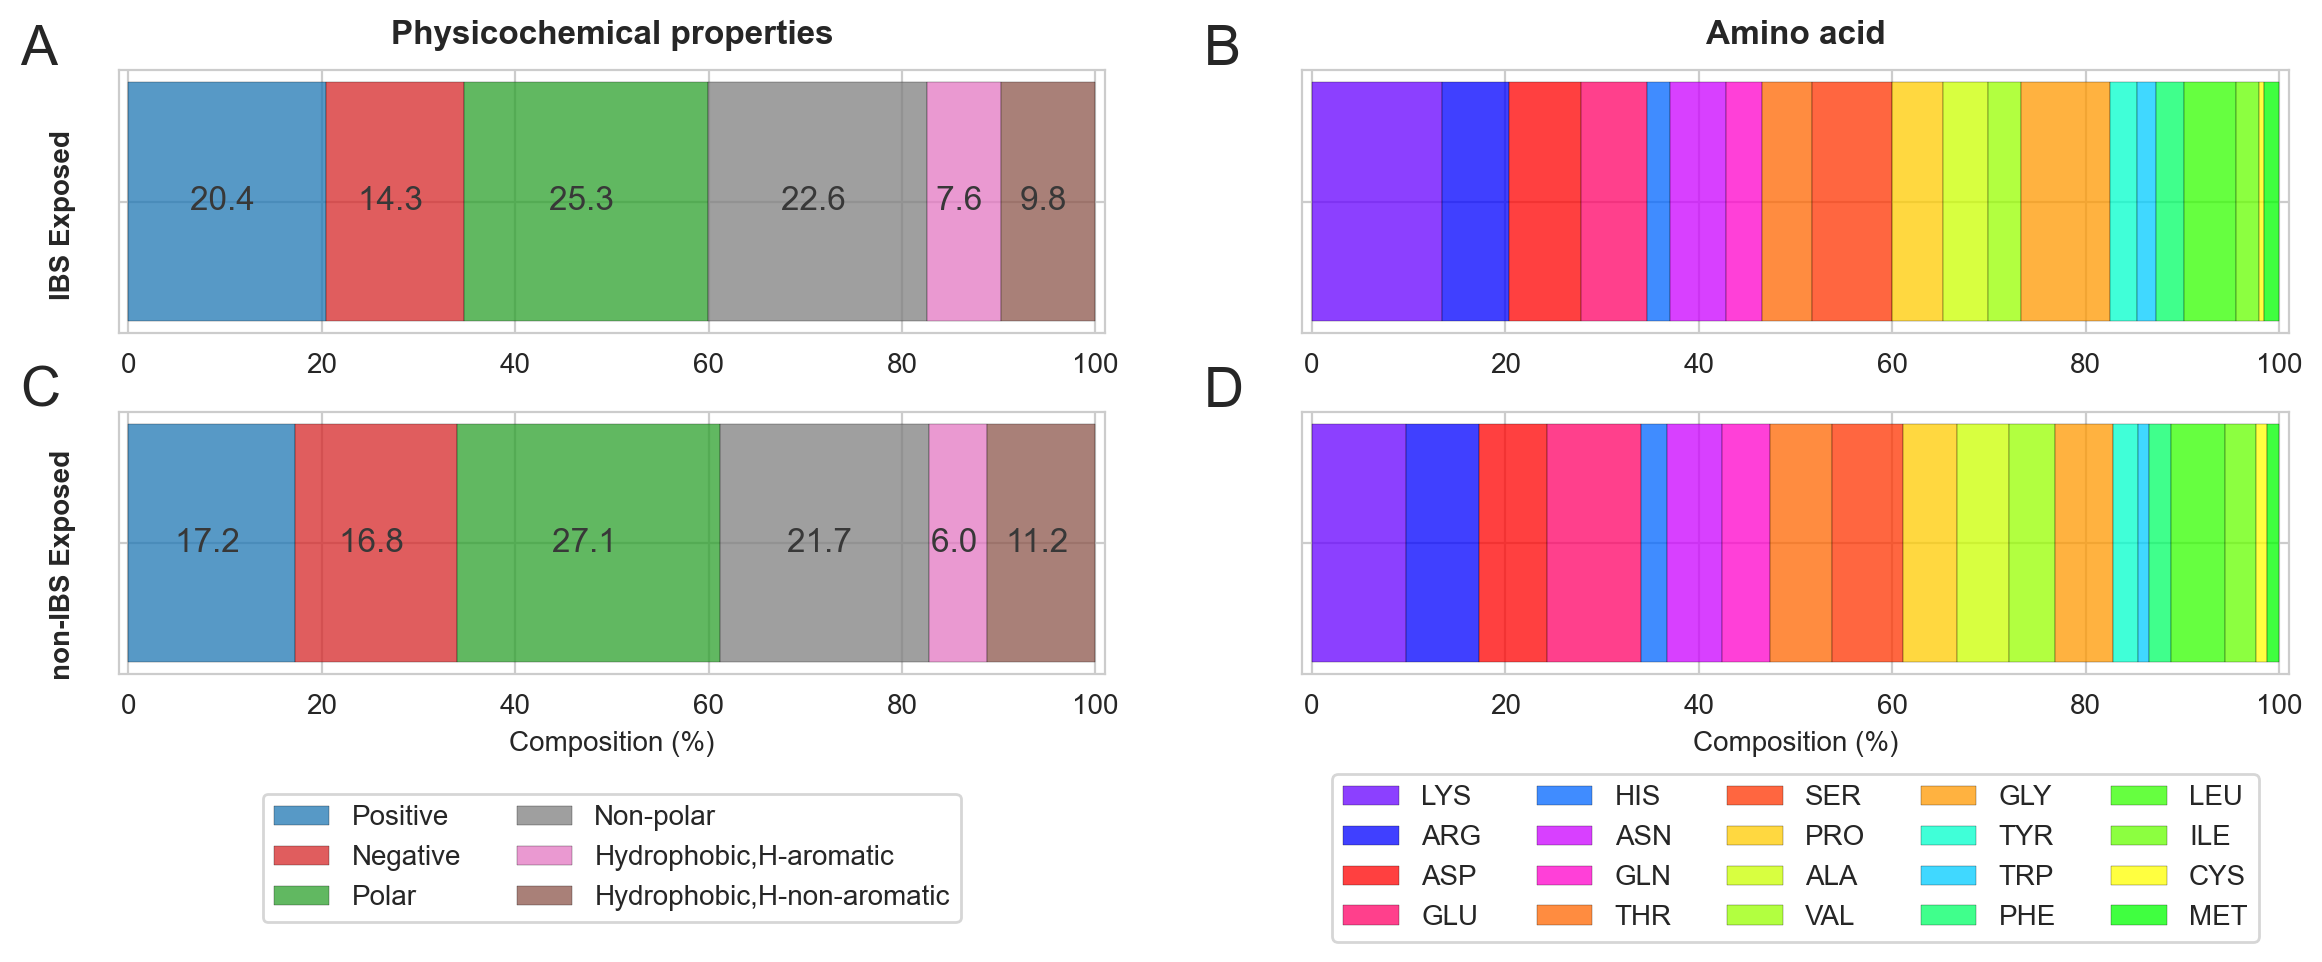

In [18]:
dataCathAFIBS = MERGEDAF.domainDf.query("IBS == True and exposed == True").drop_duplicates(['residue_name', 'residue_number', 'cathpdb']).residue_name.value_counts(normalize=True)*100
dataCathAFnoIBS = MERGEDAF.domainDf.query("IBS == False and exposed == True").drop_duplicates(['residue_name', 'residue_number', 'cathpdb']).residue_name.value_counts(normalize=True)*100
#dataAF = MERGEDAF.domainDf.query("IBS == True and exposed == True").drop_duplicates(['residue_name', 'residue_number', 'cathpdb']).residue_name.value_counts(normalize=True)*100


plt.subplots(figsize=(14, 4), )
gs = gridspec.GridSpec(ncols=2, nrows=2)
gs.update(hspace=0.3,)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1])
composition_of_exposed_IBS(dataCathAFIBS, ax=ax0, PERTYPE=True, putLegend=False, xlabel="")
composition_of_exposed_IBS(dataCathAFnoIBS, ax=ax1, PERTYPE=True, putLegend=True, )

composition_of_exposed_IBS(dataCathAFIBS, ax=ax2, PERTYPE=False, putLegend=False, xlabel="")
composition_of_exposed_IBS(dataCathAFnoIBS, ax=ax3, PERTYPE=False, putLegend=True)
_ = ax0.text(-0.07,0.15, "IBS Exposed", transform=ax0.transAxes, fontsize=10, rotation=90,weight="bold")
_ = ax1.text(-0.07,0, "non-IBS Exposed", transform=ax1.transAxes, fontsize=10, rotation=90, weight="bold")
_ = ax1.text(0.5,1.1,"Physicochemical properties", transform=ax0.transAxes, fontsize=12,  ha="center", weight="bold")
_ = ax1.text(0.5,1.1,"Amino acid", transform=ax2.transAxes, fontsize=12, ha="center", weight="bold")

_= ax0.text(-0.1,1.02, "A",transform=ax0.transAxes, fontsize=20)
_= ax2.text(-0.1,1.02, "B",transform=ax2.transAxes, fontsize=20)
_= ax1.text(-0.1,1.02, "C",transform=ax1.transAxes, fontsize=20)
_= ax3.text(-0.1,1.02, "D",transform=ax3.transAxes, fontsize=20)

save_fig(f"Fig S1{filesufix}", transparent=False, format=FORMAT)

## Figure S2 - Amino acid composition per secondary structures

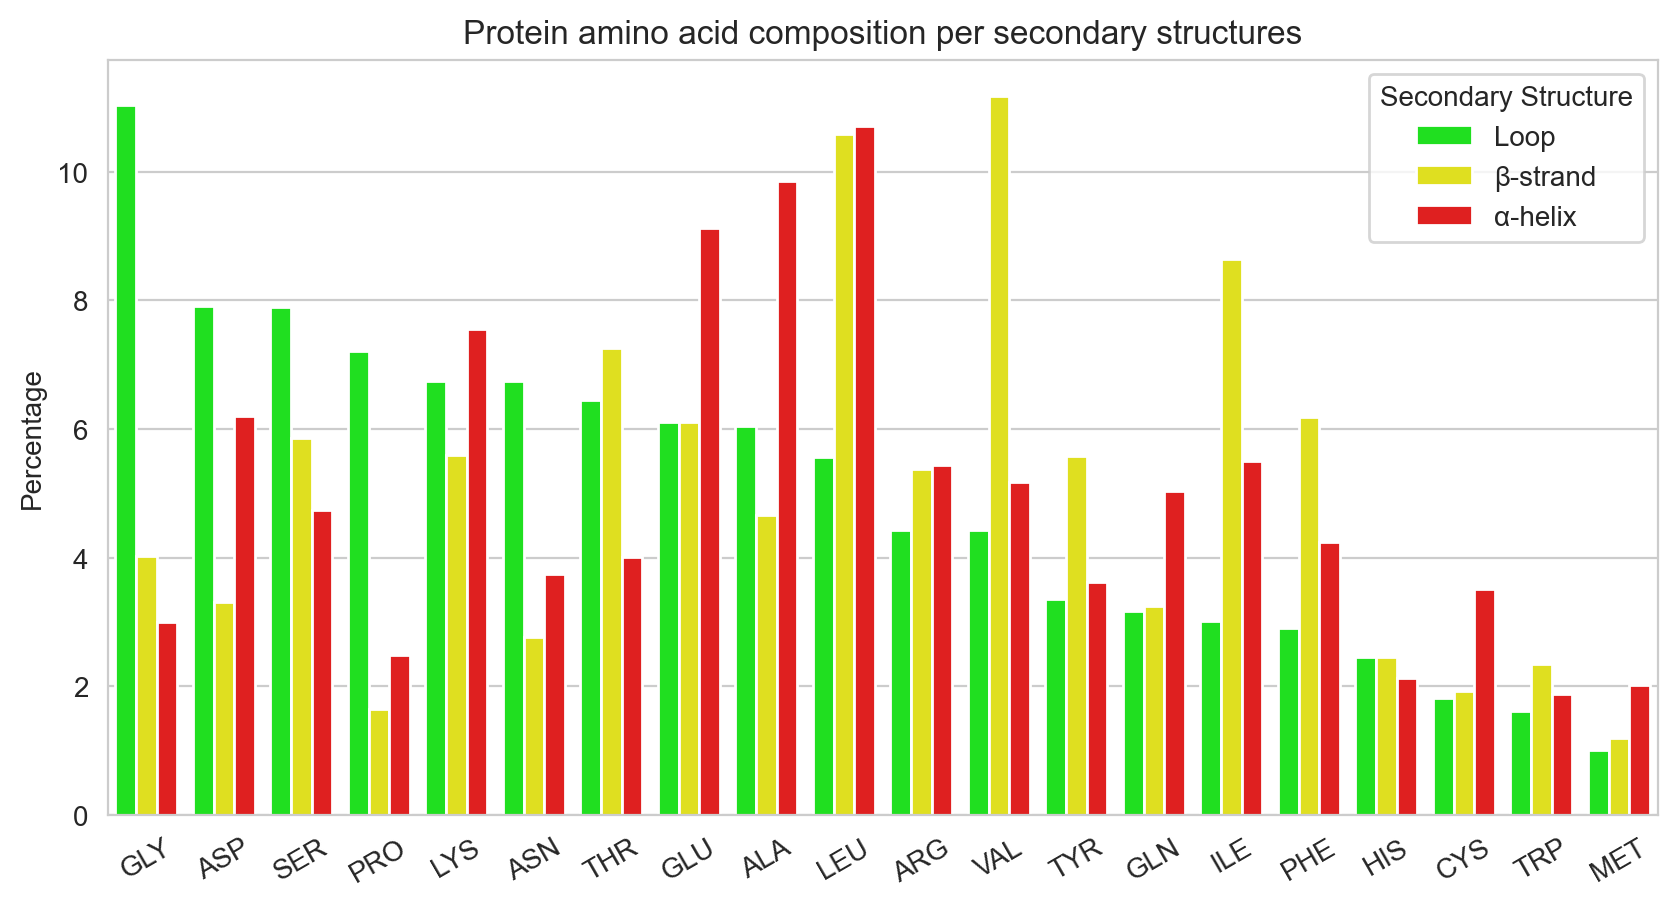

In [93]:
sns.set_style("whitegrid") #Seaborn style
MERGED.domainDf = backup_all.copy()

labelsdict = {"C":"Loop", "E":"β-strand","H":"α-helix"}
MERGED.domainDf["Secondary Structure"] = MERGED.domainDf["sec_struc"].apply(lambda x: labelsdict[x])


fix,ax = plt.subplots(figsize=(10,5))

tc = MERGED.domainDf.query("atom_name == 'CA'").groupby("Secondary Structure").residue_name.value_counts(normalize=True).to_frame("Percentage").reset_index()
tc["Percentage"] = tc["Percentage"]*100
g = sns.barplot(data=tc, x="residue_name",y="Percentage",hue="Secondary Structure", ax=ax, palette=["#00FF00","#FFFF00","#FF0000"])
_= g.set_xticklabels(g.get_xticklabels(),rotation=30, size=10)
_ = g.set(title="Protein amino acid composition per secondary structures",
         xlabel="")

save_fig(f"Fig S2{filesufix}", transparent=False, format=FORMAT)

## Figure S3. Odds ratio for Secondary Structures 

In [43]:

#1. SSE HPIBS ENVIR
MERGED.domainDf = backup_prot_HPIBS.copy()

tableCount_HPIBS, oddratios_AA_HPIBS = MERGED.analysis.oddsratio_graph(among="is_hydrophobic_protrusion", feature="residue_name", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCount_HPIBS.reset_index(inplace=True)
tableCount_HPIBS["Percentage"] = tableCount_HPIBS.groupby(["IBS","residue_name"], as_index=False).apply(lambda x: x.Count/x.total*100).droplevel(0)
tableCount_HPIBS["Surface"] = tableCount_HPIBS["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
#tableCount, oddratios_AA = MERGED.analysis.oddsratio_graph(among="protrusions", feature="residue_name", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCountSSE_HPIBS, oddratios_SSE_HPIBS = MERGED.analysis.oddsratio_graph(among="is_hydrophobic_protrusion", feature="sec_struc", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCountSSE_HPIBS.reset_index(inplace=True)
tableCountSSE_HPIBS["Percentage"] = tableCountSSE_HPIBS.groupby(["IBS","sec_struc"], as_index=False).apply(lambda x: x.Count/x.total*100).droplevel(0)
tableCountSSE_HPIBS["Surface"] = tableCountSSE_HPIBS["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
labelsdict = {"C":"Loop", "E":"β-strand","H":"α-helix"}
tableCountSSE_HPIBS["Secondary Structure"] = tableCountSSE_HPIBS["sec_struc"].apply(lambda x: labelsdict[x])
oddratios_SSE_HPIBS.insert(0, "Secondary Structure", oddratios_SSE_HPIBS["sec_struc"].apply(lambda x: labelsdict[x]))
MERGED.domainDf = backup_all.copy()


tc_sec_struc_HPIBS = MERGED.domainDf.query("protrusion == True").groupby("IBS").sec_struc.value_counts(normalize=True).to_frame('Percentage').reset_index()
tc_sec_struc_HPIBS["Surface"] = tc_sec_struc_HPIBS["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
labelsdict = {"C":"Loop", "E":"β-strand","H":"α-helix"}
tc_sec_struc_HPIBS["Secondary Structure"] = tc_sec_struc_HPIBS["sec_struc"].apply(lambda x: labelsdict[x])
MERGED.domainDf["Secondary Structure"] = MERGED.domainDf["sec_struc"].apply(lambda x: labelsdict[x])
tc_sec_struc_HPIBS["Percentage"] = tc_sec_struc_HPIBS["Percentage"]*100

#2. SSE noHPIBS envir precalculation
MERGED.domainDf = backup_prot_noHPIBS.copy()
tableCount_noHPIBS, oddratios_AA_noHPIBS = MERGED.analysis.oddsratio_graph(among="is_hydrophobic_protrusion", feature="residue_name", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCount_noHPIBS.reset_index(inplace=True)
tableCount_noHPIBS["Percentage"] = tableCount_noHPIBS.groupby(["IBS","residue_name"], as_index=False).apply(lambda x: x.Count/x.total*100).droplevel(0)
tableCount_noHPIBS["Surface"] = tableCount_noHPIBS["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
#tableCount, oddratios_AA = MERGED.analysis.oddsratio_graph(among="protrusions", feature="residue_name", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCountSSE_noHPIBS, oddratios_SSE_noHPIBS = MERGED.analysis.oddsratio_graph(among="is_hydrophobic_protrusion", feature="sec_struc", envir=True, title="Log(OR) per amino acid",return_dataset=True, return_tablecount=True, condition="exposed", exclude_protrusion=True)
tableCountSSE_noHPIBS.reset_index(inplace=True)
tableCountSSE_noHPIBS["Percentage"] = tableCountSSE_noHPIBS.groupby(["IBS","sec_struc"], as_index=False).apply(lambda x: x.Count/x.total*100).droplevel(0)
tableCountSSE_noHPIBS["Surface"] = tableCountSSE_noHPIBS["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
labelsdict = {"C":"Loop", "E":"β-strand","H":"α-helix"}
tableCountSSE_noHPIBS["Secondary Structure"] = tableCountSSE_noHPIBS["sec_struc"].apply(lambda x: labelsdict[x])
oddratios_SSE_noHPIBS.insert(0, "Secondary Structure", oddratios_SSE_noHPIBS["sec_struc"].apply(lambda x: labelsdict[x]))
MERGED.domainDf = backup_all.copy()

tc_sec_struc_noHPIBS_envir = MERGED.domainDf.query("protrusion == True").groupby("IBS").sec_struc.value_counts(normalize=True).to_frame('Percentage').reset_index()
tc_sec_struc_noHPIBS_envir["Surface"] = tc_sec_struc_noHPIBS_envir["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
labelsdict = {"C":"Loop", "E":"β-strand","H":"α-helix"}
tc_sec_struc_noHPIBS_envir["Secondary Structure"] = tc_sec_struc_noHPIBS_envir["sec_struc"].apply(lambda x: labelsdict[x])
MERGED.domainDf["Secondary Structure"] = MERGED.domainDf["sec_struc"].apply(lambda x: labelsdict[x])
tc_sec_struc_noHPIBS_envir["Percentage"] = tc_sec_struc_noHPIBS_envir["Percentage"]*100


NameError: name 'tc_sec_struc_HPIBS' is not defined

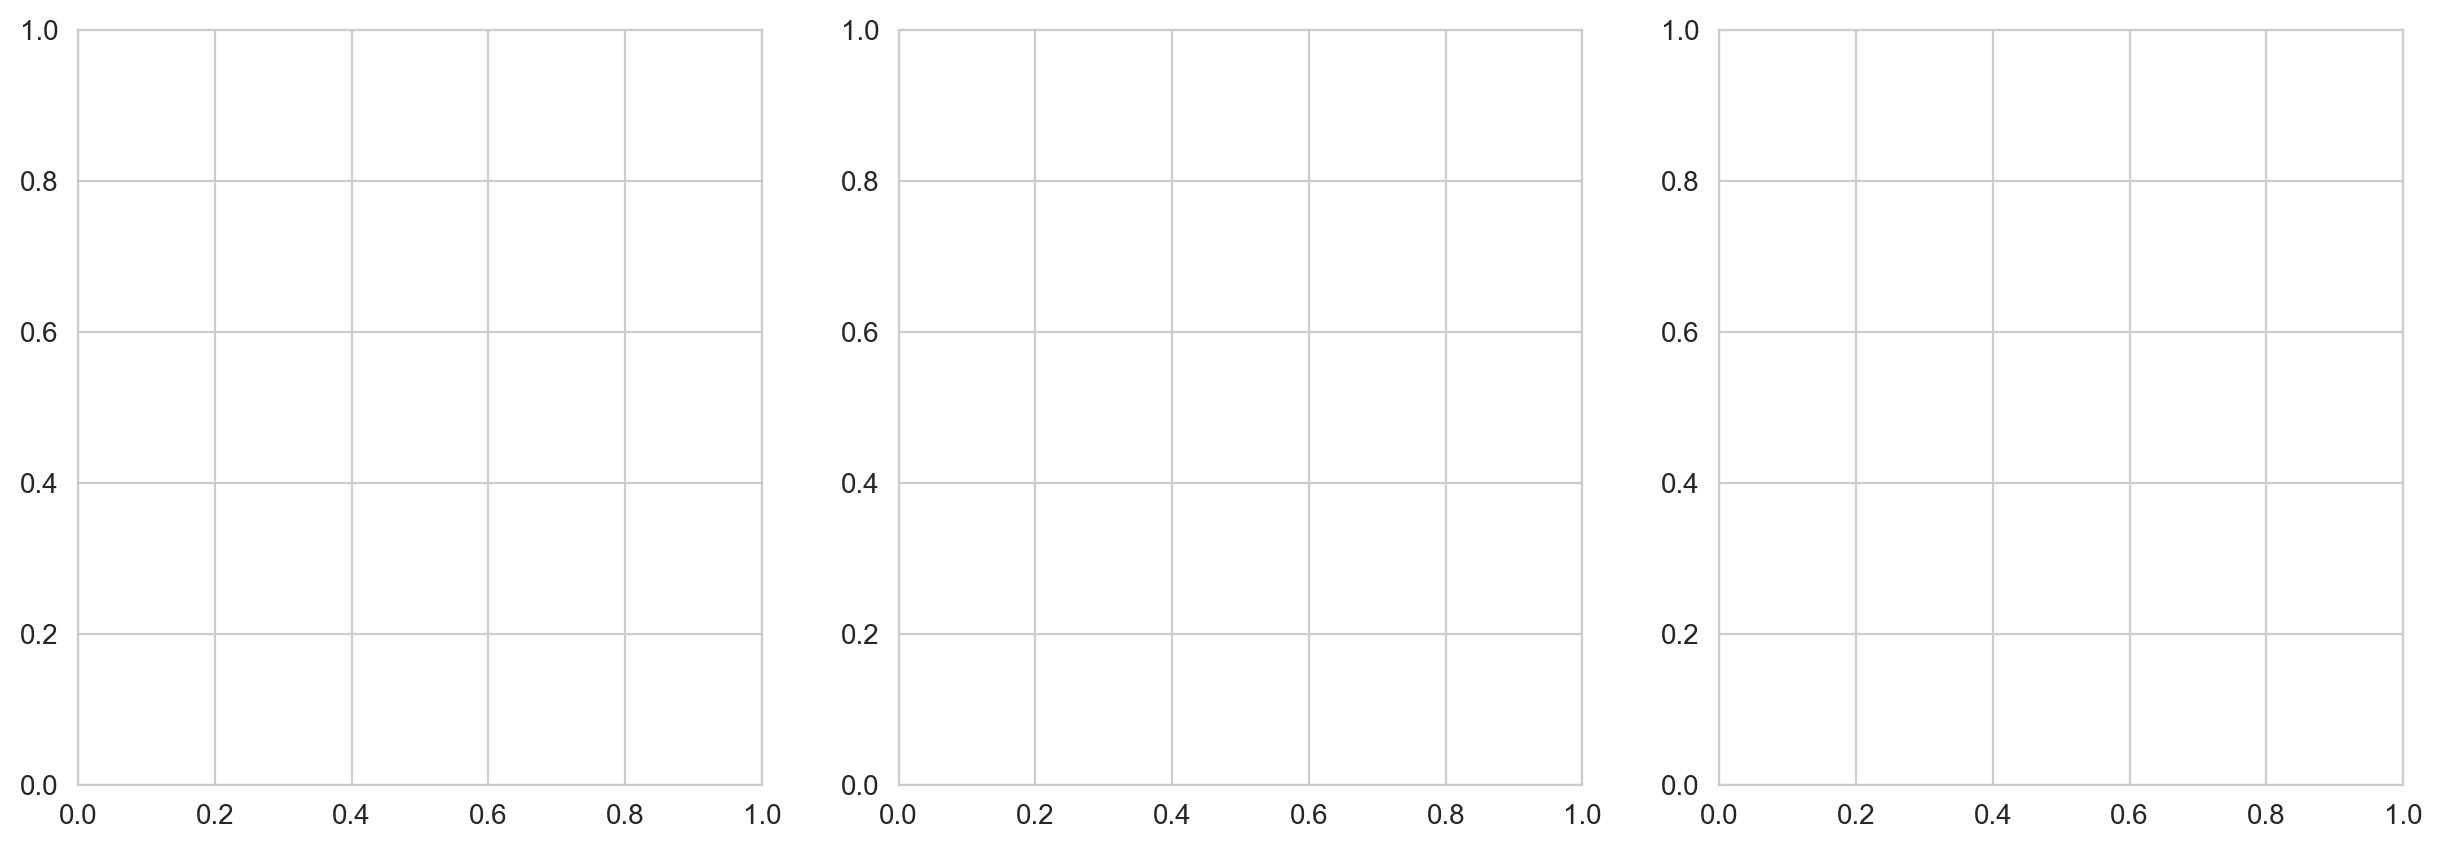

In [91]:
MERGED.domainDf = backup_prot_HPIBS.copy()
sns.set_style("whitegrid") #Seaborn style

fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[1,1,1], height_ratios=[1])
gs.update(hspace=0.05)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[0,2])



#1.1 Composition
graph_HPIBS_envir = sns.barplot(data=tc_sec_struc_HPIBS,
                    x="Secondary Structure",
                    y="Percentage",
                    hue="Surface",
                    palette=palette_IBS,
                    ax=ax0)
_= graph_HPIBS_envir.set(title="",#HPIBS HP environment",
         xlabel="",
         )

#2. SSE noHPIBS composition
MERGED.domainDf = backup_prot_noHPIBS.copy()
tc_sec_struc_noHPIBS_envir_prot = MERGED.domainDf.query("protrusion == True").groupby("IBS").sec_struc.value_counts(normalize=True).to_frame('Percentage').reset_index()
tc_sec_struc_noHPIBS_envir_prot["Surface"] = tc_sec_struc["IBS"].apply(lambda x: "IBS" if x == True else "nonIBS")
labelsdict = {"C":"Loop", "E":"β-strand","H":"α-helix"}
tc_sec_struc_noHPIBS_envir_prot["Secondary Structure"] = tc_sec_struc_noHPIBS_envir_prot["sec_struc"].apply(lambda x: labelsdict[x])
tc_sec_struc_noHPIBS_envir_prot["Percentage"] = tc_sec_struc_noHPIBS_envir_prot["Percentage"]*100

graph_noHPIBS_prot = sns.barplot(data=tc_sec_struc_noHPIBS_envir_prot,
                    x="Secondary Structure",
                    y="Percentage",
                    hue="Surface",
                    palette=palette_IBS,
                    ax=ax1)
_= graph_noHPIBS_prot.set(title="",#SSE noHPIBS protrusions",
         xlabel="")

#2. SSE noHPIBS environment

#1.1 Composition
graph_noHPIBS_envir = sns.barplot(data=tc_sec_struc_noHPIBS_envir,
                    x="Secondary Structure",
                    y="Percentage",
                    hue="Surface",
                    palette=palette_IBS,
                    ax=ax2)
_= graph_noHPIBS_envir.set(title="",#SSE noHPIBS protrusions' environment",
         xlabel="")

_= ax0.text(-0.1,1.02, "A",transform=ax0.transAxes, fontsize=20)
_= ax1.text(-0.1,1.02, "B",transform=ax1.transAxes, fontsize=20)
_= ax2.text(-0.1,1.02, "C",transform=ax2.transAxes, fontsize=20)

save_fig(f"Fig S3{filesufix}", transparent=False, format=FORMAT)

MERGED.domainDf = backup_all.copy()

## Figure S4 - Number of structures per domains with AlphaFold2

(<Figure size 2400x1000 with 1 Axes>, <AxesSubplot:>)

[Text(0, 0, 'PH'),
 Text(1, 0, 'C2'),
 Text(2, 0, 'ANNEXIN'),
 Text(3, 0, 'DIS-C2'),
 Text(4, 0, 'PX'),
 Text(5, 0, 'START')]

[Text(0, 0, 'PH'),
 Text(1, 0, 'C2'),
 Text(2, 0, 'ANNEXIN'),
 Text(3, 0, 'DIS-C2'),
 Text(4, 0, 'PX'),
 Text(5, 0, 'START')]

    domain  without hydrophobic protrusions  Number of PDBS  percentage
0  ANNEXIN                               25              35    0.714286
1       C2                               61             368    0.165761
2    C2DIS                               12              48    0.250000
3       PH                              154             599    0.257095
4       PX                               11             127    0.086614
5    START                               10              67    0.149254


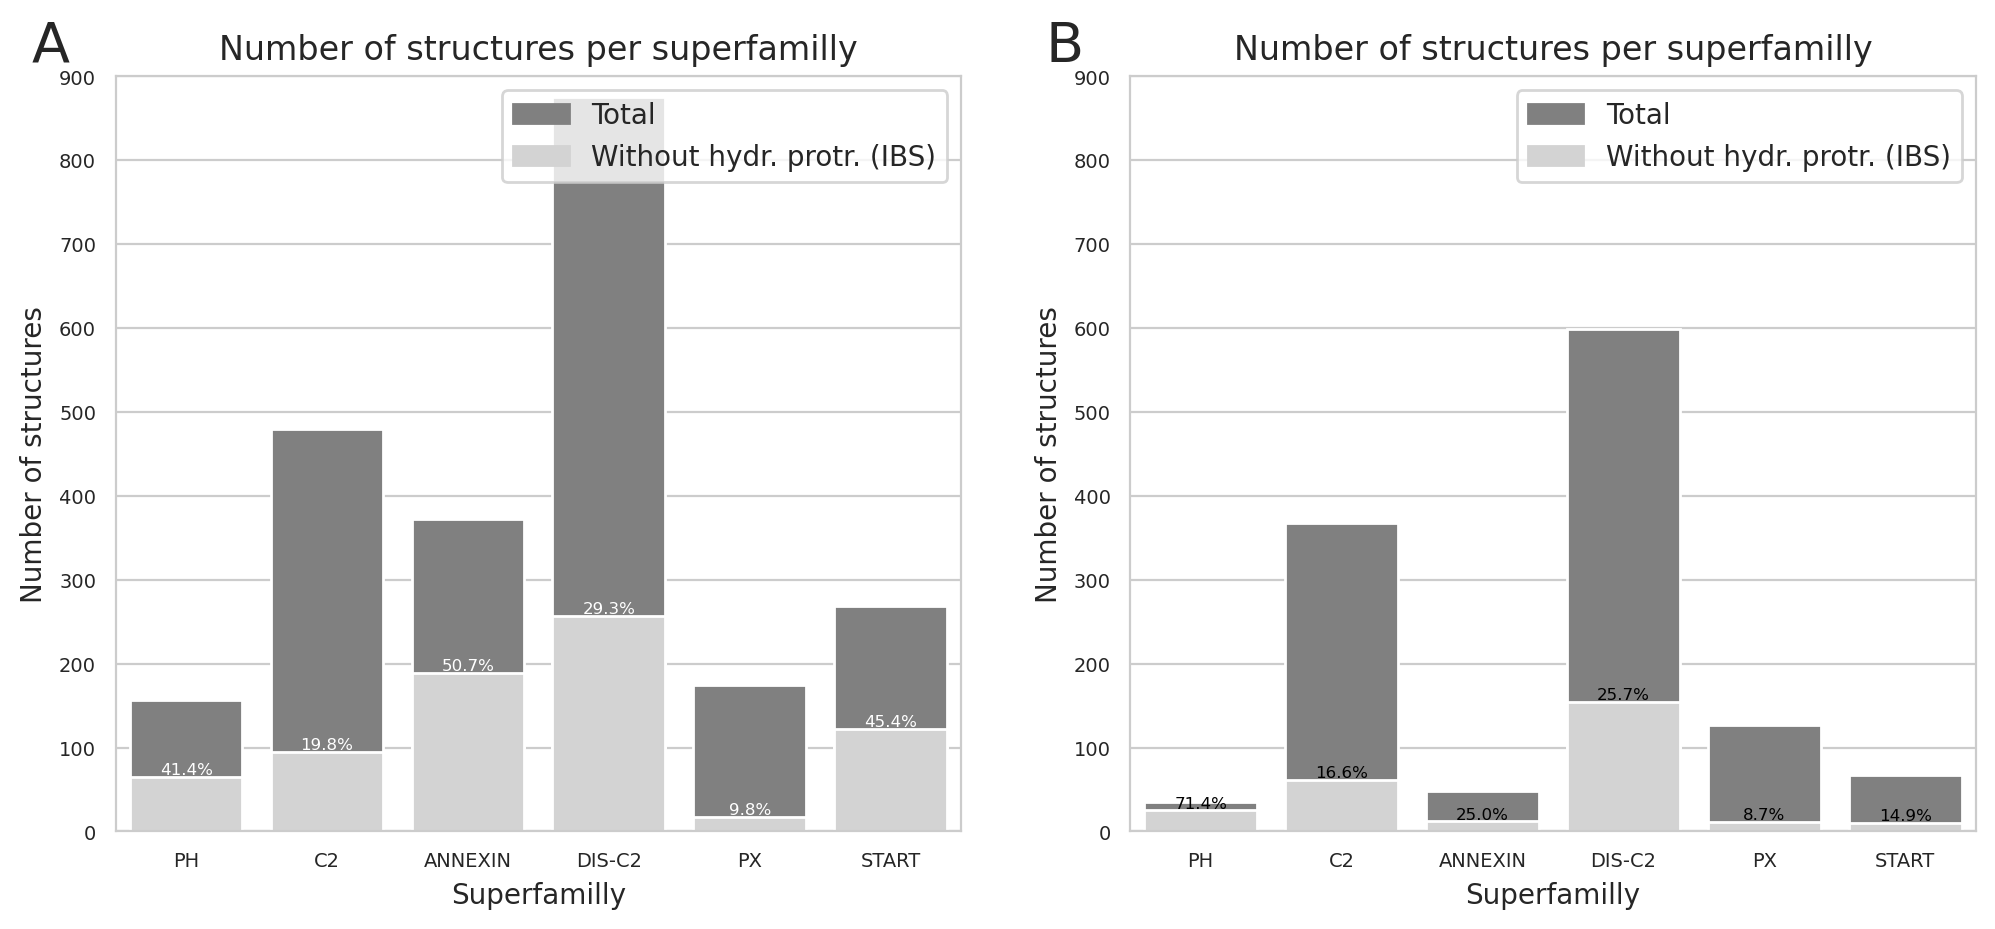

In [90]:
plt.subplots(figsize=(12, 5))

gs = gridspec.GridSpec(ncols=2, nrows=1)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])


order = ['C2DIS',
        'PH',
        'START',
        'PLA',
        'ANNEXIN',
        'C2',
        'PLD',
        # 'ENTH',
        'PX',
        'C1',
]
order.sort()


#---- A ------
count_no_hydrAF = backup_prot_noHPIBS_AF[["cathpdb","domain"]].drop_duplicates().domain.value_counts().to_frame().reset_index().rename(columns={"index":"domain","domain":"without hydrophobic protrusions"})
# count_no_hydr.set_index('domain')
number_of_structuresAF = MERGEDAF.domainDf[["cathpdb","domain"]].drop_duplicates().domain.value_counts()
#number_of_structures.name = 'Number of PDBS'
number_of_structuresAF = number_of_structuresAF.to_frame().reset_index().rename(columns={'domain':'Number of PDBS','index':'domain'})
count_no_hydrAF = count_no_hydrAF.merge(number_of_structuresAF)
count_no_hydrAF["percentage"] = count_no_hydrAF["without hydrophobic protrusions"] / count_no_hydrAF["Number of PDBS"]

#count_no_hydrAF.sort_values(by="Number of PDBS", inplace=True, ascending=False)
if includeAlfafold==True:
    count_no_hydrAF = count_no_hydrAF.set_index("domain")

    count_no_hydrAF = count_no_hydrAF.loc[order]
    count_no_hydrAF = count_no_hydrAF.reset_index()
    
count_no_hydrAF.domain = count_no_hydrAF.domain.astype(str)
import matplotlib.patches as mpatches

graphdata_nohydr = count_no_hydrAF.melt(value_vars=["without hydrophobic protrusions","Number of PDBS"],
                                      id_vars=["domain"],
                                      value_name="count",
                                      var_name="Observation")

graphdata_nohydr = graphdata_nohydr.query('domain not in @EXCLUDE_AF_FOR_DOMAIN') 
order = graphdata_nohydr.domain.unique()
order.sort()
g1_bar1 = sns.barplot(x="domain",
                   y="count",
                   data=graphdata_nohydr.query("Observation == 'Number of PDBS'"),
                   color='gray',
                   order=order,
                   ax=ax0) 

g1_bar2 = sns.barplot(x="domain",
                   y="count",
                   data=graphdata_nohydr.query("Observation == 'without hydrophobic protrusions'"),
                   color='lightgray',
                   ci=None,
                   order=order,
                   ax=ax0
                  )
groupedvalues=graphdata_nohydr.groupby('domain').sum().reset_index()

#Adding barplot
count_no_hydrAF = count_no_hydrAF.reset_index(drop=True)
count_no_hydrAF = count_no_hydrAF.set_index("domain").loc[order].reset_index()

for index, row in count_no_hydrAF.iterrows():
    _ = g1_bar2.text(row.name,
                  row["without hydrophobic protrusions"]+3,
                  f"{row['percentage']*100:.1f}%",
                  color="white",
                  ha="center",
                  size=6)

#Legend
top_bar = mpatches.Patch(color='gray', label='Total')
bottom_bar = mpatches.Patch(color='lightgray', label='Without hydr. protr. (IBS)')
_ = ax0.legend(handles=[top_bar, bottom_bar])

_ = ax0.set(title = "Number of structures per superfamilly",xlabel="Superfamilly", ylabel="Number of structures",
          ylim=None,
          )
_ = ax0.tick_params(labelsize=7)

## Graph with AF Only
count_no_hydrAF = backup_prot_noHPIBS_AF.query("data_type == 'alfafold' and b_factor > 70")[["cathpdb","domain"]].drop_duplicates().domain.value_counts().to_frame().reset_index().rename(columns={"index":"domain","domain":"without hydrophobic protrusions"})
# count_no_hydr.set_index('domain')
number_of_structuresAF = MERGEDAF.domainDf.query("data_type == 'alfafold' and b_factor > 70")[["cathpdb","domain"]].drop_duplicates().domain.value_counts()
#number_of_structures.name = 'Number of PDBS'
number_of_structuresAF = number_of_structuresAF.to_frame().reset_index().rename(columns={'domain':'Number of PDBS','index':'domain'})
count_no_hydrAF = count_no_hydrAF.merge(number_of_structuresAF)
count_no_hydrAF["percentage"] = count_no_hydrAF["without hydrophobic protrusions"] / count_no_hydrAF["Number of PDBS"]

#count_no_hydrAF.sort_values(by="Number of PDBS", inplace=True, ascending=False)
if includeAlfafold==True:
    count_no_hydrAF = count_no_hydrAF.set_index("domain")

    count_no_hydrAF = count_no_hydrAF.loc[order]
    count_no_hydrAF = count_no_hydrAF.reset_index()
    
count_no_hydrAF.domain = count_no_hydrAF.domain.astype(str)
import matplotlib.patches as mpatches

graphdata_nohydr = count_no_hydrAF.melt(value_vars=["without hydrophobic protrusions","Number of PDBS"],
                                      id_vars=["domain"],
                                      value_name="count",
                                      var_name="Observation")

graphdata_nohydr = graphdata_nohydr.query('domain not in @EXCLUDE_AF_FOR_DOMAIN') 
order = graphdata_nohydr.domain.unique()
order.sort()
g2_bar1 = sns.barplot(x="domain",
                   y="count",
                   data=graphdata_nohydr.query("Observation == 'Number of PDBS'"),
                   color='gray',
                   order=order,
                   ax=ax1) 

g2_bar2 = sns.barplot(x="domain",
                   y="count",
                   data=graphdata_nohydr.query("Observation == 'without hydrophobic protrusions'"),
                   color='lightgray',
                   ci=None,
                   order=order,
                   ax=ax1
                  )
groupedvalues=graphdata_nohydr.groupby('domain').sum().reset_index()

domainlist = list(graphdata_nohydr.domain.unique())
new_labels = [s.replace("C2DIS","DIS-C2") for s in domainlist]
new_labels = [s.replace("PLD","PLC/PLD") for s in new_labels]
g1_bar1.set_xticklabels(new_labels)
g2_bar1.set_xticklabels(new_labels)

#Adding barplot
count_no_hydrAF = count_no_hydrAF.reset_index(drop=True)
count_no_hydrAF = count_no_hydrAF.set_index("domain").loc[order].reset_index()

print(count_no_hydrAF)
for index, row in count_no_hydrAF.iterrows():
    _ = g2_bar2.text(row.name,
                  row["without hydrophobic protrusions"]+3,
                  f"{row['percentage']*100:.1f}%",
                  color="black",
                  ha="center",
                  size=6)

#Legend
top_bar = mpatches.Patch(color='gray', label='Total')
bottom_bar = mpatches.Patch(color='lightgray', label='Without hydr. protr. (IBS)')
_ = ax1.legend(handles=[top_bar, bottom_bar])

_ = ax1.set(title = "Number of structures per superfamilly",xlabel="Superfamilly", ylabel="Number of structures",
          ylim=None,
          )
_ = ax1.tick_params(labelsize=7)


_= ax0.text(-0.1,1.02, "A",transform=ax0.transAxes, fontsize=20)
_= ax1.text(-0.1,1.02, "B",transform=ax1.transAxes, fontsize=20)

_ = ax0.set(ylim=(0,900))
_ = ax1.set(ylim=(0,900))


save_fig(f"Fig S4", transparent=False, format=FORMAT)

In [60]:
MERGEDAF.domainDf[["cathpdb","domain"]].drop_duplicates().domain.value_counts()

PH         876
C2         480
C2DIS      373
START      269
C1         222
PX         174
PLA        171
ANNEXIN    157
PLD        115
Name: domain, dtype: int64

## Table S1 - Origin of the datas

In [16]:
all_taxons = MERGED.domainDf.query("data_type == 'cathpdb'").groupby("cathpdb").apply(lambda x: x.taxon.iloc[0].split("/"))

level0 = [x[0] if len(x) > 1 else "unknown" for x in list(all_taxons)]
level1 = [x[1] if len(x) > 1 else "unknown" for x in list(all_taxons)]
taxons = pd.DataFrame([level0, level1]).T.value_counts(normalize=False).to_frame().rename(columns={0:"count"})




In [17]:
print("those PDB don't have any information, let's find out manually")
unkownPdbs = MERGED.domainDf.query("taxon == ''").cathpdb.unique()
print(len(unkownPdbs))

those PDB don't have any information, let's find out manually
35


Manual searching for unkown pdbs
| cathid  | Taxon0/Taxon1 | 
| ------- | ------------- |
| 4f77e00 | Eukaryota/Metazoa |
| 1isdA03 | Eukaryota/Metazoa |
| 1qmmA02 | Eukaryota/Metazoa |
| 2wxeA03 | Eukaryota/Metazoa |
| 3kwtA00 | Eukaryota/Metazoa |
| 3rdlA00 | Eukaryota/Metazoa |
| 1fvzA00 | Eukaryota/Metazoa |
| 2vjgC00 | Eukaryota/Viridiplantae |
| 3k78A00 | Eukaryota/Viridiplantae |
| 3oh8A01 | Bacteria/Actinobacteria |
| 3qrzC00 | Eukaryota/Viridiplantae |
| 1jz0B01 | Bacteria/Proteobacteria |
| 2bq9C03 | Bacteria/Actinobacteria |
| 2j1fA00 | Bacteria/Firmicutes |
| 2w3jA00 | Bacteria/Actinobacteria |
| 2wz8A00 | Bacteria/Firmicutes |
| 2y8jA00 | Bacteria/Firmicutes |
| 3k4zA01 | Bacteria/Firmicutes |
| 4crrA00 | Bacteria/Bacteroidetes |
| 4oxwA00 | Synthetic construct and others |
| 2o55A00 | Eukaryota/Rhodophyta |
| 3qvqA00 | Bacteria/Proteobacteria |
| 3qvqB00 | Bacteria/Proteobacteria |
| 3qvqC00 | Bacteria/Proteobacteria |
| 3qvqD00 | Bacteria/Proteobacteria |
| 1lffA00 | Eukaryota/Metazoa |
| 1lfjA00 | Eukaryota/Metazoa |
| 1lfjB00 | Eukaryota/Metazoa |
| 1oyfB00 | Eukaryota/Metazoa |
| 1ozyA00 | Eukaryota/Metazoa |
| 1pwoD00 | Eukaryota/Metazoa |
| 1tjqA00 | Eukaryota/Metazoa |
| 2qhgC00 | Eukaryota/Metazoa |
| 3l69A00 | Eukaryota/Metazoa |
| 4h0qB00 | Eukaryota/Metazoa |

Updating the taxon table

In [18]:
#Update Missing taxons.
taxons.loc[("Eukaryota","Metazoa"),'count'] += 17
taxons.loc[("Bacteria","Proteobacteria"),'count'] += 5
taxons.loc[("Bacteria","Firmicutes"),'count'] += 4
taxons.loc[("Eukaryota","Viridiplantae"),'count'] += 3
taxons.loc[("Bacteria","Actinobacteria"),'count'] += 3
taxons.loc[("Bacteria","Bacteroidetes"),'count'] += 1
taxons.loc[("Bacteria","Rhodophyta"),'count'] = 1
taxons.loc[("Other","Synthetic construct"),'count'] = 1

taxons["percentage"] = taxons["count"]/sum(taxons["count"])*100
taxons["percentage"] = taxons["percentage"].round(2)
taxons = taxons.sort_values([0,"percentage"], ascending=False)
taxons = taxons.loc[["Eukaryota","Bacteria","Archaea","Viruses", "Other"]] #Remove unkwown since their are fixed now.

#Calculate all percentages + total
total = taxons["count"].sum()
taxons["percentage_per_taxon0"] = taxons["count"].groupby(level=0).transform(lambda x: (sum(x)/total*100).round(2))
taxons.loc[('total',''),:] = (total,100,100)

#Formating
taxons["count"] = taxons["count"].astype(int)

#Rename indexes and columns.
taxons.index = taxons.index.set_names(["Taxon L0","Taxon L1"])
taxons.rename(columns={"count":"Number of structures"}, inplace=True)


taxons.to_excel(f"{FIGURESFOLDER}article/table4.xlsx")
taxons

Number of structures  percentage  \
Taxon L0  Taxon L1                                                
Eukaryota Metazoa                               785       57.59   
          Viridiplantae                          90        6.60   
          Fungi                                  55        4.04   
          Metamonada                              8        0.59   
          Euglenozoa                              3        0.22   
          Alveolata                               2        0.15   
          Amoebozoa                               2        0.15   
          Sar                                     1        0.07   
Bacteria  Firmicutes                            166       12.18   
          Proteobacteria                        105        7.70   
          Actinobacteria                         44        3.23   
          Bacteroidetes                          42        3.08   
          Deinococcus-Thermus                     7        0.51   
          Thermotogae                             5        0.37   
          Tenericutes                             1        0.07   
          Rhodophyta                              1        0.07   
Archaea   Euryarchaeota                           5        0.37   
          Crenarchaeota                           2        0.15   
          Thaumarchaeota                          1        0.07   
Viruses   Poxviridae                              1        0.07   
          Caudovirales                            1        0.07   
Other     Synthetic construct                     1        0.07   
total                                          1328      100.00   

                               percentage_per_taxon0  
Taxon L0  Taxon L1                                    
Eukaryota Metazoa                              71.23  
          Viridiplantae                        71.23  
          Fungi                                71.23  
          Metamonada                           71.23  
          Euglenozoa                           71.23  
          Alveolata                            71.23  
          Amoebozoa                            71.23  
          Sar                                  71.23  
Bacteria  Firmicutes                           27.94  
          Proteobacteria                       27.94  
          Actinobacteria                       27.94  
          Bacteroidetes                        27.94  
          Deinococcus-Thermus                  27.94  
          Thermotogae                          27.94  
          Tenericutes                          27.94  
          Rhodophyta                           27.94  
Archaea   Euryarchaeota                         0.60  
          Crenarchaeota                         0.60  
          Thaumarchaeota                        0.60  
Viruses   Poxviridae                            0.15  
          Caudovirales                          0.15  
Other     Synthetic construct                   0.08  
total                                         100.00

In [47]:
count_no_hydrAF

,domain,without hydrophobic protrusions,Number of PDBS,percentage
0,PH,257,98,2.622449
1,C2DIS,189,11,17.181818
2,START,122,9,13.555556
3,C2,95,49,1.938776
4,ANNEXIN,65,11,5.909091
5,PLD,25,48,0.520833
6,PX,17,25,0.680000
7,C1,11,19,0.578947
8,PLA,8,4,2.000000


In [48]:
num_pdbs_AF_noAF = pd.concat([count_no_hydr.set_index('domain').sort_index()["Number of PDBS"],
                                count_no_hydrAF.set_index('domain').sort_index()["Number of PDBS"]],
                                axis=1)

num_pdbs_AF_noAF.columns = ["CATH","CATH+AF"]
num_pdbs_AF_noAF["fold"] = num_pdbs_AF_noAF["CATH+AF"] /  num_pdbs_AF_noAF["CATH"] 
num_pdbs_AF_noAF["increase"] = num_pdbs_AF_noAF["CATH+AF"] /  num_pdbs_AF_noAF["CATH"] *100

num_pdbs_AF_noAF.loc[["PH","C2","PX","C1"]]
num_pdbs_AF_noAF.loc[["C2DIS", "START", 
# "ENTH", 
"ANNEXIN", "PLD", "PLA"]]
         



,CATH,CATH+AF,fold,increase
domain,,,,
PH,275,98,0.356364,35.636364
C2,112,49,0.437500,43.750000
PX,47,25,0.531915,53.191489
C1,38,19,0.500000,50.000000


,CATH,CATH+AF,fold,increase
domain,,,,
C2DIS,325,11,0.033846,3.384615
START,201,9,0.044776,4.477612
ANNEXIN,122,11,0.090164,9.016393
PLD,67,48,0.716418,71.641791
PLA,141,4,0.028369,2.836879


In [49]:
## Composition per familly.

In [50]:
count_no_hydrAF.percentage.mean()

4.998607759779439

In [51]:
num_pdbs_AF_noAF = pd.concat([count_no_hydr.set_index('domain').sort_index()["Number of PDBS"],
                                count_no_hydrAF.set_index('domain').sort_index()["Number of PDBS"]],
                                axis=1)

num_pdbs_AF_noAF.columns = ["CATH","CATH+AF"]
num_pdbs_AF_noAF["fold"] = num_pdbs_AF_noAF["CATH+AF"] /  num_pdbs_AF_noAF["CATH"] 
num_pdbs_AF_noAF["increase"] = num_pdbs_AF_noAF["CATH+AF"] /  num_pdbs_AF_noAF["CATH"] *100

num_pdbs_AF_noAF.loc[["PH","C2","PX","C1"]]
num_pdbs_AF_noAF.loc[["C2DIS", "START", 
# "ENTH", 
"ANNEXIN", "PLD", "PLA"]]
         



,CATH,CATH+AF,fold,increase
domain,,,,
PH,275,98,0.356364,35.636364
C2,112,49,0.437500,43.750000
PX,47,25,0.531915,53.191489
C1,38,19,0.500000,50.000000


,CATH,CATH+AF,fold,increase
domain,,,,
C2DIS,325,11,0.033846,3.384615
START,201,9,0.044776,4.477612
ANNEXIN,122,11,0.090164,9.016393
PLD,67,48,0.716418,71.641791
PLA,141,4,0.028369,2.836879


## Figure S5 

(<Figure size 2800x1000 with 1 Axes>, <AxesSubplot:>)

NameError: name 'make_ibs_perdomain_graph' is not defined

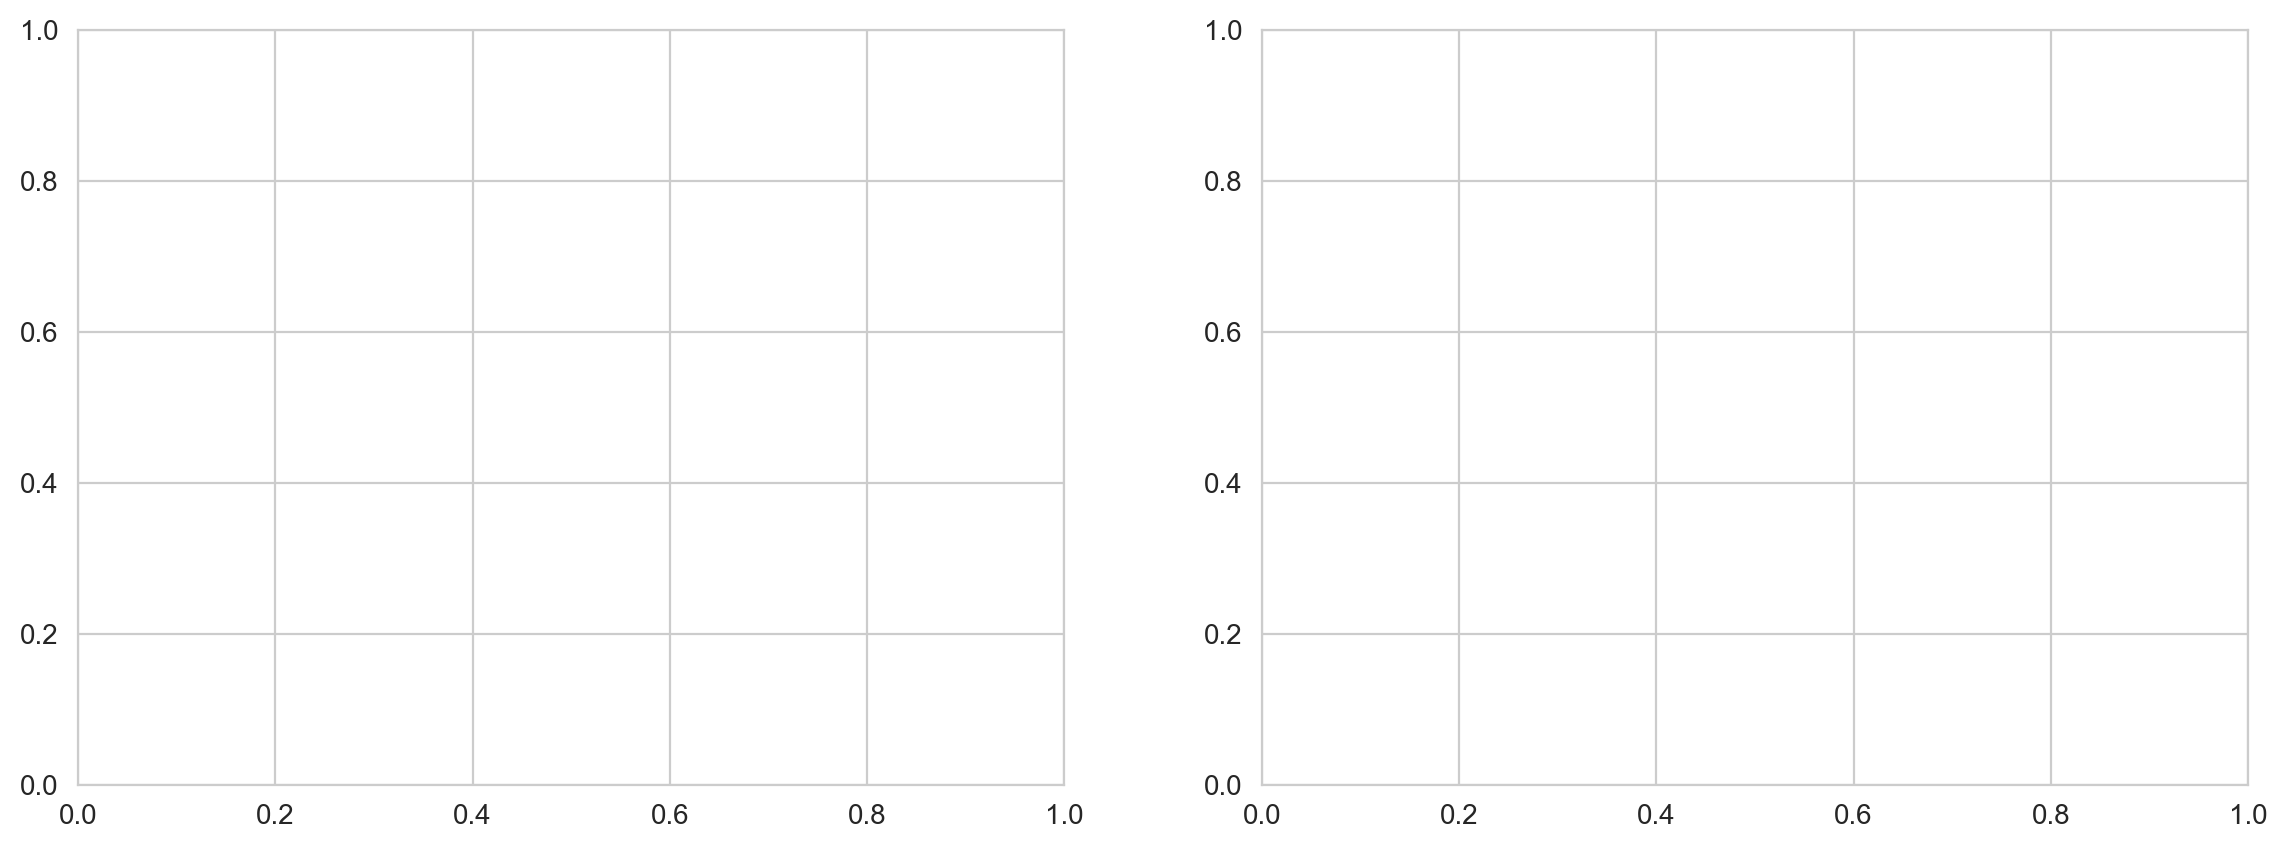

In [16]:
plt.subplots(figsize=(14, 5))

gs = gridspec.GridSpec(ncols=2, nrows=1)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

backup_prot_HPIBS_AF["type"] = backup_prot_HPIBS_AF.residue_name.apply(lambda x: AATYPE[x])
# print(backup_prot_HPIBS_AF[["type","residue_name"]].drop_duplicates())
# print(backup_prot_HPIBS_AF.domain.unique())

graph_superfamilies_type = make_ibs_perdomain_graph(data=backup_prot_HPIBS_AF.query("(data_type == 'cathpdb') or (data_type == 'alfafold' and b_factor >= 70)"),
                         MERGED=MERGEDAF,
                         PERTYPE=True,
                         nrow=3,
                         title="",#Hydrophobic protrusions exposed environment at the IBS",
                          outputname="IBS_protrusions_composition_HYDRO_perdomain2",
                         ax=ax0,
                         legend=True,
                              envir=True,
                         alldom=True,
#                               showstat=["Negative","Positive", "Polar","Non-polar", "Hydrophobic,H-aromatic","Hydrophobic,H-non-aromatic"],
                        )

graph_superfamilies_aa = make_ibs_perdomain_graph(data=backup_prot_HPIBS_AF.query("(data_type == 'cathpdb') or (data_type == 'alfafold' and b_factor >= 70)"),
                         MERGED=MERGEDAF,
                         PERTYPE=False,
                         nrow=3,
                         title="",#Hydrophobic protrusions exposed environment at the IBS",
                          outputname="IBS_protrusions_composition_HYDRO_perdomain2",
                         ax=ax1,
                         legend=True,
                              envir=True,
                         alldom=True,
#                               showstat=["Negative","Positive", "Polar","Non-polar", "Hydrophobic,H-aromatic","Hydrophobic,H-non-aromatic"],
                        )

_= ax0.text(-0.1,1.02, "A",transform=ax0.transAxes, fontsize=20)
_= ax1.text(-0.1,1.02, "B",transform=ax1.transAxes, fontsize=20)

save_fig(f"Fig S5", transparent=False, format=FORMAT)

In [250]:
order_domains=["ANNEXIN",'PH','C2','PX','PLA','START','PLD','C2DIS','C1']
graph_superfamilies_type

Percentage
domain residue_name            
PH     GLY            10.413464
       GLN             3.705801
       ARG             8.973218
       TRP             3.827170
       LEU             4.854762
...                         ...
PLA    MET             1.625668
       CYS             2.866310
       THR             3.144385
       PRO             1.176471
       GLU             1.390374

[180 rows x 1 columns]

## File S1

In [ ]:
## saving dataset for PlosOne
# MERGEDAF.domainDf.query("data_type == 'alfafold'")
from Bio import AlignIO
import re
import requests
import json
from urllib.error import URLError

REGEX = re.compile("^(\w+)\|(\w+)\/(\d+)-(\d+)")         
use_uniprot_boundaries = True

def get_prosite_boundaries_dict(domain):
    boundaries = {}
    prosite_ids = DOMAIN_PROSITE[domain]
    if type(prosite_ids) != type([]):
        prosite_ids = [prosite_ids]
    for msafile in prosite_ids:
        msafilepath = f"{PROSITEFOLDER}/msa/{msafile}.msa"
        msa = AlignIO.read(msafilepath,'fasta')
        for record in msa:
            seqid = record.id
            match = REGEX.match(seqid)
            if match:
                uniprot_id = match.group(2)
                start = match.group(3)
                end = match.group(4)
                boundaries[uniprot_id] = (int(start),int(end))
    return boundaries

def get_json(uniprot_acc, domain, source='ssf'):
    def request_URL(link, trial=1):
        try:
            response = requests.get(link).text
            return response
        except URLError as e:
            print(e, link)
            if trial >3 :
                print('3rd fail, skipping this one.')
                return None
            else:
                print(f"Trial {trial}, waiting 10s and trying again")
                sleep(10)
                return request_URL(link, trial=trial+1)
            
            
    jsonfolder = f"{ALFAFOLDFOLDER}/{domain}/json"
    if not os.path.exists(jsonfolder):
        os.makedirs(jsonfolder)
        
    jsonfile = f"{jsonfolder}/{uniprot_acc}.json"
    if os.path.isfile(jsonfile):
        f = open(jsonfile)
        interpro = json.load(f)
    else:
        #make the query on ebi/interpro
        response = request_URL(f"https://www.ebi.ac.uk/interpro/api/entry/{source}/protein/reviewed/{uniprot_acc}/?page_size=200")
        if response == None:
            return None
        try:
            interpro = json.loads(response)
        except:
            print(f"no data for {uniprot_acc}.")
            return None
        with open(jsonfile,'w') as out:
            json.dump(interpro, out, indent=2)
            
    return(interpro)


def get_domain_fragment_query(uniprot_acc, domain, boundaries_prosite):
    start_PS,end_PS = boundaries_prosite[uniprot_acc]
    starts_ends = [boundaries_prosite[uniprot_acc]]

    if DOMAIN_INTERPRO_REFINE[domain] == True:
        if domain == "PLA":
            source = 'cathgene3d'
        else:
            source = 'ssf'
        interpro = get_json(uniprot_acc, domain, source)
        if interpro == None:
            return None
        QueryString = None
        
        for result in interpro["results"]:
            if result["metadata"]["accession"] == DOMAIN_INTERPRO[domain]:
                entry_protein_locations = result["proteins"][0]["entry_protein_locations"]
                for entry in entry_protein_locations: #Get the number of truncation in the domain.
                    nfrag = len(entry['fragments'])
                    
                    if domain == 'PLA': #Special case for PLA, we will ignore PROSITE annotation that are actually wrong.
                        frag = entry['fragments'][0] #Get first monomer only
                        s = entry['fragments'][0].get('start')
                        e = entry['fragments'][0].get('end')
                        starts_ends = [[s,e]]
                    else:
                        if nfrag >= 2 and ( entry['fragments'][0].get('start') - 50 <= start_PS <= entry['fragments'][0].get('start')+50) : #if truncated domain AND correspond to the prosite domain
                            #print(f"splitting {domain}-{uniprot_acc}")
                            queries = []
                            starts_ends = []
                            for frag in entry['fragments']:
                                s=int(frag.get("start"))
                                e=int(frag.get("end"))
                                starts_ends.append([s,e])
                            if use_uniprot_boundaries == True:
                                starts_ends[0][0] = start_PS
                                starts_ends[-1][-1] = end_PS

                        else: #use prosite fragment
                            starts_ends = [[start_PS, end_PS]]
                    

                QueryString = " or ".join([f"({x} <= residue_number <= {y})" for x,y in starts_ends])
        
    else:
        QueryString = " or ".join([f"({x} <= residue_number <= {y})" for x,y in starts_ends])
    
    return QueryString


df = MERGEDAF.domainDf[["cathpdb","domain","data_type"]].drop_duplicates()

domains = df.domain.unique()
boundaries = {}
for domain in domains:
    boundaries[domain]  = get_prosite_boundaries_dict(domain)


def add_boundaries(group, boundaries):
    domain = group.domain
    data_type = group.data_type
    if data_type == "alfafold":
        name = group.cathpdb
        query = get_domain_fragment_query(name, domain, boundaries[domain])
    else:
        query=""
    return query


def clean_segments(group):
    regex = r"(\d+)"
    segment = group.segment_temp
    res = re.findall(regex, segment)
    if res:
        if len(res) == 4:
            formated_segment = f"{res[0]}-{res[1]}/{res[2]}-{res[3]}"
        elif len(res) == 2:
            formated_segment = f"{res[0]}-{res[1]}"
    else:
        formated_segment = ""
    return formated_segment


df["segment_temp"] = df.apply(lambda x: add_boundaries(x, boundaries), axis=1)
df["segment"] = df.apply(lambda x: clean_segments(x), axis=1)     

df = df[["cathpdb","domain","data_type","segment"]].rename(columns={"cathpdb":"id"})

df = df.replace("alfafold","alphafold")
df.to_excel(f"{FIGURESFOLDER}/article/datalist.xlsx", index=False)

## FIle S2

In [25]:
#group = MERGEDAF.domainDf.query("cathpdb == '2da0A00'")
def format_file_S2(group):
    domain = group["domain"].unique()[0]
    pdbid=group['cathpdb'].unique()[0]
    datatype = group['data_type'].unique()[0]
    group = group.replace('alfafold', "alphafold")


    #IBS
    IBS_Exposed_vert = len(group.query("IBS == True and exposed == True and convhull_vertex == True"))
    IBS_Exposed_protr = len(group.query("IBS == True and exposed == True and protrusion == True "))
    IBS_Exposed_HP = len(group.query("IBS == True and exposed == True and is_hydrophobic_protrusion == True "))

    IBS_nonExposed_vert = len(group.query("IBS == True and exposed == False and convhull_vertex == True"))
    IBS_nonExposed_protr = len(group.query("IBS == True and exposed == False and protrusion == True "))
    IBS_nonExposed_HP = len(group.query("IBS == True and exposed == False and is_hydrophobic_protrusion == True "))

    #Non IBS
    nonIBS_Exposed_vert = len(group.query("IBS == False and exposed == True and convhull_vertex == True"))
    nonIBS_Exposed_protr = len(group.query("IBS == False and exposed == True and protrusion == True "))
    nonIBS_Exposed_HP = len(group.query("IBS == False and exposed == True and is_hydrophobic_protrusion == True "))

    nonIBS_nonExposed_vert = len(group.query("IBS == False and exposed == False and convhull_vertex == True"))
    nonIBS_nonExposed_protr = len(group.query("IBS == False and exposed == False and protrusion == True "))
    nonIBS_nonExposed_HP = len(group.query("IBS == False and exposed == False and is_hydrophobic_protrusion == True "))

    data = (domain, pdbid, datatype,
                          IBS_Exposed_vert, IBS_Exposed_protr, IBS_Exposed_HP,
                          IBS_nonExposed_vert, IBS_nonExposed_protr, IBS_nonExposed_HP,
                          nonIBS_Exposed_vert, nonIBS_Exposed_protr, nonIBS_Exposed_HP,
                          nonIBS_nonExposed_vert, nonIBS_nonExposed_protr, nonIBS_nonExposed_HP)

    index = (("domain","",""),("pdbid","",""),("datatype","",""),
                              ("IBS","Exposed","vertex"),
                              ("IBS","Exposed","protrusions"),
                              ("IBS","Exposed","Hydrophobic_protrusions"),
                              ("IBS","nonExposed","vertex"),
                              ("IBS","nonExposed","protrusions"),
                              ("IBS","nonExposed","Hydrophobic_protrusions"),
                              ("nonIBS","Exposed","vertex"),
                              ("nonIBS","Exposed","protrusions"),
                              ("nonIBS","Exposed","Hydrophobic_protrusions"),
                              ("nonIBS","nonExposed","vertex"),
                              ("nonIBS","nonExposed","protrusions"),
                              ("nonIBS","nonExposed","Hydrophobic_protrusions"),
              )

    df = pd.DataFrame(data, index = pd.MultiIndex.from_tuples(index)).T
    return df

fileS2df = MERGEDAF.domainDf.groupby("cathpdb", as_index=False).progress_apply(lambda group: format_file_S2(group))

In [27]:
fileS2df.to_excel(f"{FIGURESFOLDER}/article/S1 File.xlsx")
fileS2df.to_csv(f"{FIGURESFOLDER}/article/S1 File.csv", sep=';', index=False)